# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [192]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

In [193]:
def read_image(image_path):
    """Reads and returns image."""
    return mpimg.imread(image_path)

def read_image_and_print_dims(image_path):
    """Reads and returns image.
    Helper function to examine how an image is represented.
    """
    #reading in an image
    image = mpimg.imread(image_path)
    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimensions:', image.shape)
    plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image
    return image

In [194]:
# Read and save test images to array
test_images = [read_image('test_images/' + i) for i in os.listdir('test_images/')]

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [195]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    # print("Hough lines: ", lines)
    line_img = np.zeros(img.shape, dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [196]:
def intersection_x(coef1, intercept1, coef2, intercept2):
    """Returns x-coordinate of intersection of two lines."""
    x = (intercept2-intercept1)/(coef1-coef2)
    return x

def draw_linear_regression_line(coef, intercept, intersection_x, img, imshape=[540,960], color=[255, 0, 0], thickness=2):
    
    # Get starting and ending points of regression line, ints.
    point_one = (int(intersection_x), int(intersection_x * coef + intercept))
    if coef > 0:
        point_two = (imshape[1], int(imshape[1] * coef + intercept))
    elif coef < 0:
        point_two = (0, int(0 * coef + intercept))
    print("Point one: ", point_one, "Point two: ", point_two)
    
    # Draw line using cv2.line
    cv2.line(img, point_one, point_two, color, thickness)

In [197]:
def find_line_fit(slope_intercept):
    """slope_intercept is an array [[slope, intercept], [slope, intercept]...]."""

    # Initialise arrays
    kept_slopes = []
    kept_intercepts = []
    # print("Slope & intercept: ", slope_intercept)
    if len(slope_intercept) == 1:
        return slope_intercept[0][0], slope_intercept[0][1]

    # Remove points with slope not within 1.5 standard deviations of the mean
    slopes = [pair[0] for pair in slope_intercept]
    mean_slope = np.mean(slopes)
    slope_std = np.std(slopes)
    for pair in slope_intercept:
        slope = pair[0]
        if slope - mean_slope < 1.5 * slope_std:
            kept_slopes.append(slope)
            kept_intercepts.append(pair[1])

    # Take estimate of slope, intercept to be the mean of remaining values
    positive_slope = np.mean(kept_slopes)
    positive_intercept = np.mean(kept_intercepts)
    print("Slope: ", positive_slope, "Intercept: ", positive_intercept)
    return positive_slope, positive_intercept

In [198]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # Image parameters (hard-coded. TODO: Make not hard-coded.)
    imshape = [540, 960]
    
    # Initialise arrays
    positive_slope_points = []
    negative_slope_points = []
    positive_slope_intercept = []
    negative_slope_intercept = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:            
            slope = (y1-y2)/(x1-x2)
            # print("Points: ", [x1, y1, x2, y2])
            length = math.sqrt((x1-x2)**2 + (y1-y2)**2)
            # print("Length: ", length)
            if not math.isnan(slope):
                if length > 50:
                    if slope > 0:
                        positive_slope_points.append([x1, y1])
                        positive_slope_points.append([x2, y2])
                        positive_slope_intercept.append([slope, y1-slope*x1])
                    elif slope < 0:
                        negative_slope_points.append([x1, y1])
                        negative_slope_points.append([x2, y2])
                        negative_slope_intercept.append([slope, y1-slope*x1])
        
        # If either array is empty, waive length requirement
        if not positive_slope_points:
            for x1,y1,x2,y2 in line:            
                slope = (y1-y2)/(x1-x2)
                if slope > 0:
                    positive_slope_points.append([x1, y1])
                    positive_slope_points.append([x2, y2])
                    positive_slope_intercept.append([slope, y1-slope*x1])
        if not positive_slope_points:
            for x1,y1,x2,y2 in line:            
                slope = (y1-y2)/(x1-x2)
                if slope < 0:
                    negative_slope_points.append([x1, y1])
                    negative_slope_points.append([x2, y2])
                    negative_slope_intercept.append([slope, y1-slope*x1])
    
    # Even though positive_slope_points is not used, I am keeping it for debugging purposes.
    positive_slope_points = np.array(positive_slope_points)
    negative_slope_points = np.array(negative_slope_points)
    # print("Positive slope line points: ", positive_slope_points)
    # print("Negative slope line points: ", negative_slope_points)
    # print("positive slope points dtype: ", positive_slope_points.dtype)

    # Get intercept and coefficient of fitted lines
    pos_coef, pos_intercept = find_line_fit(positive_slope_intercept)
    neg_coef, neg_intercept = find_line_fit(negative_slope_intercept)
    
    # Discarded Linear Regression Option:
    # Get intercept and coefficient of linear regression lines
    # pos_coef, pos_intercept = find_linear_regression_line(positive_slope_points)
    # neg_coef, neg_intercept = find_linear_regression_line(negative_slope_points)
    
    # Get intersection point
    intersection_x_coord = intersection_x(pos_coef, pos_intercept, neg_coef, neg_intercept)
    
    # Plot lines
    draw_linear_regression_line(pos_coef, pos_intercept, intersection_x_coord, img)
    draw_linear_regression_line(neg_coef, neg_intercept, intersection_x_coord, img)

In [199]:
# Not used
from sklearn.linear_model import LinearRegression

def find_linear_regression_line(points):
    # Separate points into X and y to fit LinearRegression model
    points_x = [[point[0]] for point in points]
    points_y = [point[1] for point in points]
    # points_x_print = [point[0] for point in points]
    # print("X points: ", points_x, "Length: ", len(points_x))
    # print("X points: ", points_x_print, "Length: ", len(points_x))
    # print("Y points: ", points_y, "Length: ", len(points_y))

    # Fit points to LinearRegression line
    clf = LinearRegression().fit(points_x, points_y)

    # Get parameters from line
    coef = clf.coef_[0]
    intercept = clf.intercept_
    print("Coefficients: ", coef, "Intercept: ", intercept)
    return coef, intercept

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [200]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

### Pipeline

Steps:
1. Read in and grayscale the image
2. Define a kernel size and apply Gaussian smoothing
3. Define our parameters for Canny and apply to get edges image
4. Mask edges image using cv2.fillPoly() (ignore everything outside region of interest)
5. Define Hough transform parameters and run Hough transform on masked edge-detected image
6. Draw line segments
7. Draw lines extrapolated from line segments
8. Combine line image with original image to see how accurate the line annotations are.

Slope:  0.564152709349 Intercept:  37.3004566564
Slope:  -0.768295476236 Intercept:  678.75027465
Point one:  (481, 308) Point two:  (960, 578)
Point one:  (481, 308) Point two:  (0, 678)


array([[[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ..., 
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 82, 118, 151]],

       [[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ..., 
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 83, 119, 152]],

       [[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ..., 
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 83, 119, 152]],

       ..., 
       [[ 68,  70,  76],
        [ 68,  70,  76],
        [ 68,  70,  76],
        ..., 
        [ 65,  65,  73],
        [ 64,  64,  72],
        [ 63,  63,  71]],

       [[ 69,  69,  75],
        [ 69,  69,  75],
        [ 70,  70,  76],
        ..., 
        [ 62,  64,  71],
        [ 62,  64,  71],
        [ 61,  63,  70]],

       [[ 67,  67,  74],
        [ 67,  67,  74],
        [ 67,  67,  74],
        ..., 
        [ 61,  62,  72],
        [ 60,  62,  71],
        [ 59,  61,

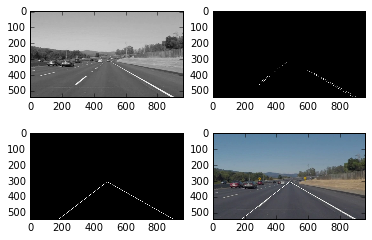

In [201]:
# Pipeline

def draw_lane_lines(image):
    """Draw lane lines in white on original image."""
    # Print image details
    # print("image.shape: ", image.shape)
    imshape = image.shape
    
    # Greyscale image
    greyscaled_image = grayscale(image)
    plt.subplot(2,2,1)
    plt.imshow(greyscaled_image, cmap="gray")
    
    # Gaussian Blur
    blurred_grey_image = gaussian_blur(greyscaled_image, 5)
    
    # Canny edge detection
    edges_image = canny(blurred_grey_image, 50, 150)
    
    # Mask edges image
    border = 0
    vertices = np.array([[(0,imshape[0]),(465, 320), (475, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    edges_image_with_mask = region_of_interest(edges_image, vertices)
    ## Plot masked edges image
    bw_edges_image_with_mask = cv2.cvtColor(edges_image_with_mask, cv2.COLOR_GRAY2BGR)
    plt.subplot(2,2,2)
    plt.imshow(bw_edges_image_with_mask)
    
    # Hough lines
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 20 #minimum number of pixels making up a line
    max_line_gap = 40    # maximum gap in pixels between connectable line segments
    lines_image = hough_lines(edges_image_with_mask, rho, theta, threshold, min_line_len, max_line_gap)
    
    # Convert Hough from single channel to RGB to prep for weighted
    # TODO: Have it convert the lines to red, not white.
    hough_rgb_image = cv2.cvtColor(lines_image, cv2.COLOR_GRAY2BGR)
    # hough_rgb_image.dtype: uint8.  Shape: (540,960,3).
    # hough_rgb_image is like [[[0 0 0], [0 0 0],...] [[0 0 0], [0 0 0],...]]
    ## Plot Hough lines image
    plt.subplot(2,2,3)
    plt.imshow(hough_rgb_image)    
    
    # Combine lines image with original image
    final_image = weighted_img(hough_rgb_image, image)
    ## Plot final image
    plt.subplot(2,2,4)
    plt.imshow(final_image)
    return final_image

draw_lane_lines(test_images[0])

## Testing the Pipeline on the test_images

Slope:  0.564152709349 Intercept:  37.3004566564
Slope:  -0.768295476236 Intercept:  678.75027465
Point one:  (481, 308) Point two:  (960, 578)
Point one:  (481, 308) Point two:  (0, 678)


array([[[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ..., 
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 82, 118, 151]],

       [[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ..., 
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 83, 119, 152]],

       [[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ..., 
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 83, 119, 152]],

       ..., 
       [[ 68,  70,  76],
        [ 68,  70,  76],
        [ 68,  70,  76],
        ..., 
        [ 65,  65,  73],
        [ 64,  64,  72],
        [ 63,  63,  71]],

       [[ 69,  69,  75],
        [ 69,  69,  75],
        [ 70,  70,  76],
        ..., 
        [ 62,  64,  71],
        [ 62,  64,  71],
        [ 61,  63,  70]],

       [[ 67,  67,  74],
        [ 67,  67,  74],
        [ 67,  67,  74],
        ..., 
        [ 61,  62,  72],
        [ 60,  62,  71],
        [ 59,  61,

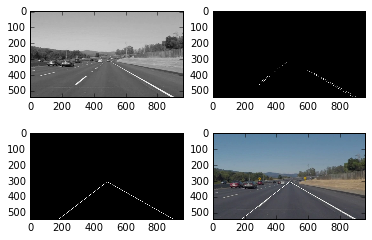

In [202]:
draw_lane_lines(test_images[0])

Slope:  0.634908963585 Intercept:  1.02712630507
Slope:  -0.693779967159 Intercept:  642.933479853
Point one:  (483, 307) Point two:  (960, 610)
Point one:  (483, 307) Point two:  (0, 642)


array([[[144, 157, 167],
        [114, 129, 141],
        [107, 125, 143],
        ..., 
        [109, 123, 142],
        [117, 127, 141],
        [149, 156, 168]],

       [[114, 129, 141],
        [114, 133, 147],
        [107, 128, 146],
        ..., 
        [110, 127, 146],
        [114, 127, 143],
        [118, 129, 142]],

       [[105, 126, 143],
        [106, 129, 146],
        [102, 127, 150],
        ..., 
        [103, 125, 148],
        [109, 126, 146],
        [107, 122, 141]],

       ..., 
       [[ 96,  97, 100],
        [ 73,  74,  78],
        [ 66,  67,  71],
        ..., 
        [ 70,  71,  74],
        [ 75,  76,  79],
        [ 96,  97, 100]],

       [[110, 111, 114],
        [ 84,  85,  88],
        [ 71,  72,  76],
        ..., 
        [ 78,  78,  82],
        [ 87,  88,  91],
        [111, 112, 115]],

       [[144, 145, 148],
        [112, 113, 116],
        [ 94,  94,  98],
        ..., 
        [ 98,  98, 100],
        [112, 113, 114],
        [143, 144,

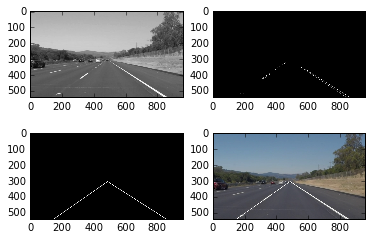

In [203]:
draw_lane_lines(test_images[1])

Slope:  0.574621212121 Intercept:  42.0287878788
Slope:  -0.746517794842 Intercept:  666.145981128
Point one:  (472, 313) Point two:  (960, 593)
Point one:  (472, 313) Point two:  (0, 666)


array([[[ 82, 125, 162],
        [ 82, 125, 162],
        [ 82, 125, 162],
        ..., 
        [ 77, 122, 157],
        [ 75, 121, 155],
        [ 70, 116, 150]],

       [[ 82, 125, 160],
        [ 82, 125, 160],
        [ 82, 125, 160],
        ..., 
        [ 77, 122, 157],
        [ 75, 121, 155],
        [ 70, 116, 150]],

       [[ 82, 126, 158],
        [ 82, 126, 158],
        [ 82, 126, 158],
        ..., 
        [ 78, 122, 157],
        [ 77, 120, 155],
        [ 72, 115, 150]],

       ..., 
       [[ 76,  80,  85],
        [ 76,  80,  85],
        [ 76,  80,  85],
        ..., 
        [ 58,  63,  74],
        [ 58,  63,  74],
        [ 58,  63,  74]],

       [[ 76,  80,  85],
        [ 76,  80,  85],
        [ 76,  80,  85],
        ..., 
        [ 57,  62,  73],
        [ 57,  62,  73],
        [ 57,  62,  73]],

       [[ 75,  79,  84],
        [ 75,  79,  84],
        [ 75,  79,  84],
        ..., 
        [ 58,  62,  71],
        [ 58,  62,  71],
        [ 58,  62,

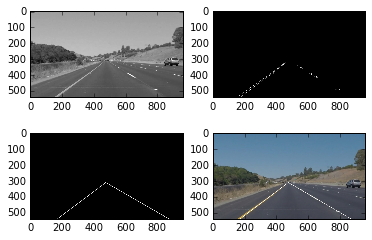

In [204]:
draw_lane_lines(test_images[2])

Slope:  0.596914008704 Intercept:  23.8442964492
Slope:  -0.752641227018 Intercept:  668.970033334
Point one:  (478, 309) Point two:  (960, 596)
Point one:  (478, 309) Point two:  (0, 668)


array([[[ 83, 126, 162],
        [ 83, 126, 162],
        [ 83, 126, 162],
        ..., 
        [ 78, 125, 160],
        [ 76, 123, 158],
        [ 74, 122, 157]],

       [[ 83, 126, 162],
        [ 83, 126, 162],
        [ 83, 126, 162],
        ..., 
        [ 77, 124, 159],
        [ 75, 122, 158],
        [ 72, 121, 156]],

       [[ 82, 126, 161],
        [ 83, 126, 162],
        [ 82, 127, 162],
        ..., 
        [ 75, 124, 159],
        [ 74, 122, 158],
        [ 72, 121, 156]],

       ..., 
       [[ 82,  82,  88],
        [ 82,  82,  88],
        [ 82,  82,  88],
        ..., 
        [ 62,  66,  74],
        [ 62,  66,  74],
        [ 62,  66,  74]],

       [[ 82,  81,  87],
        [ 82,  81,  87],
        [ 82,  81,  87],
        ..., 
        [ 62,  66,  73],
        [ 62,  65,  72],
        [ 62,  65,  72]],

       [[ 79,  78,  85],
        [ 79,  78,  85],
        [ 79,  78,  85],
        ..., 
        [ 62,  65,  72],
        [ 62,  65,  72],
        [ 62,  65,

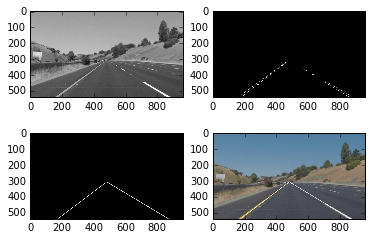

In [205]:
draw_lane_lines(test_images[3])

Slope:  0.621711758416 Intercept:  9.78511680196
Slope:  -0.715960151798 Intercept:  646.840274227
Point one:  (476, 305) Point two:  (960, 606)
Point one:  (476, 305) Point two:  (0, 646)


array([[[147, 157, 168],
        [115, 127, 142],
        [106, 123, 142],
        ..., 
        [102, 122, 141],
        [112, 129, 142],
        [146, 159, 171]],

       [[114, 126, 142],
        [115, 130, 147],
        [106, 125, 146],
        ..., 
        [ 99, 123, 144],
        [110, 127, 144],
        [113, 128, 142]],

       [[105, 122, 141],
        [106, 125, 146],
        [100, 123, 147],
        ..., 
        [ 94, 120, 145],
        [ 98, 120, 142],
        [100, 121, 139]],

       ..., 
       [[103, 102, 107],
        [ 92,  91,  96],
        [ 88,  87,  92],
        ..., 
        [ 66,  66,  74],
        [ 70,  70,  78],
        [ 95,  95, 103]],

       [[113, 112, 116],
        [100,  99, 103],
        [ 92,  91,  95],
        ..., 
        [ 70,  70,  78],
        [ 85,  85,  91],
        [109, 109, 115]],

       [[141, 140, 144],
        [111, 110, 114],
        [102, 102, 106],
        ..., 
        [ 95,  95, 102],
        [110, 110, 116],
        [146, 146,

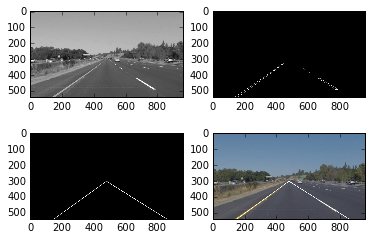

In [206]:
draw_lane_lines(test_images[4])

Slope:  0.569934717392 Intercept:  39.2694669039
Slope:  -0.755664602605 Intercept:  677.791063444
Point one:  (481, 313) Point two:  (960, 586)
Point one:  (481, 313) Point two:  (0, 677)


array([[[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ..., 
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       [[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ..., 
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       [[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ..., 
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       ..., 
       [[ 76,  80,  85],
        [ 75,  79,  84],
        [ 75,  79,  84],
        ..., 
        [ 67,  70,  82],
        [ 66,  68,  80],
        [ 63,  66,  78]],

       [[ 75,  79,  84],
        [ 75,  79,  84],
        [ 74,  78,  83],
        ..., 
        [ 67,  70,  80],
        [ 66,  69,  78],
        [ 62,  66,  75]],

       [[ 72,  78,  82],
        [ 71,  77,  82],
        [ 71,  77,  82],
        ..., 
        [ 66,  70,  79],
        [ 65,  68,  78],
        [ 62,  66,

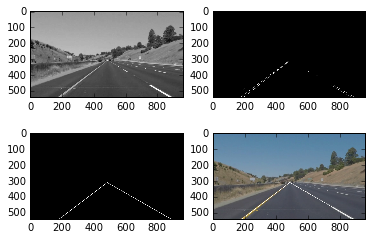

In [207]:
draw_lane_lines(test_images[5])

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [208]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [209]:
def process_image(image):
    """Puts image through pipeline and returns 3-channel image for processing video below."""
    result = draw_lane_lines(image)
    print(result.shape)
    return result

Slope:  0.569934717392 Intercept:  39.2694669039
Slope:  -0.755664602605 Intercept:  677.791063444
Point one:  (481, 313) Point two:  (960, 586)
Point one:  (481, 313) Point two:  (0, 677)
(540, 960, 3)


array([[[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ..., 
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       [[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ..., 
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       [[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ..., 
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       ..., 
       [[ 76,  80,  85],
        [ 75,  79,  84],
        [ 75,  79,  84],
        ..., 
        [ 67,  70,  82],
        [ 66,  68,  80],
        [ 63,  66,  78]],

       [[ 75,  79,  84],
        [ 75,  79,  84],
        [ 74,  78,  83],
        ..., 
        [ 67,  70,  80],
        [ 66,  69,  78],
        [ 62,  66,  75]],

       [[ 72,  78,  82],
        [ 71,  77,  82],
        [ 71,  77,  82],
        ..., 
        [ 66,  70,  79],
        [ 65,  68,  78],
        [ 62,  66,

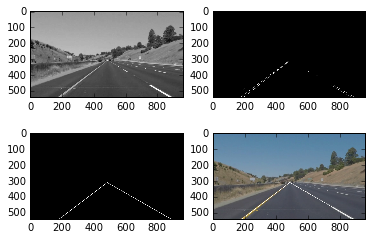

In [210]:
process_image(image)

Let's try the one with the solid white lane on the right first ...

Slope:  0.626108962272 Intercept:  2.91539595246
Slope:  -0.743359422281 Intercept:  658.93296864
Point one:  (479, 302) Point two:  (960, 603)
Point one:  (479, 302) Point two:  (0, 658)
(540, 960, 3)
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4








  0%|          | 0/222 [00:00<?, ?it/s]





  1%|          | 2/222 [00:00<00:16, 13.18it/s]

Slope:  0.626108962272 Intercept:  2.91539595246
Slope:  -0.743359422281 Intercept:  658.93296864
Point one:  (479, 302) Point two:  (960, 603)
Point one:  (479, 302) Point two:  (0, 658)
(540, 960, 3)
Slope:  0.620219445396 Intercept:  5.905146483
Slope:  -0.742430998309 Intercept:  658.69356929
Point one:  (479, 303) Point two:  (960, 601)
Point one:  (479, 303) Point two:  (0, 658)
(540, 960, 3)
Slope:  0.633461974185 Intercept:  -1.4164128932
Slope:  -0.721600332969 Intercept:  651.821832546
Point one:  (482, 303) Point two:  (960, 606)
Point one:  (482, 303) Point two:  (0, 651)


(540, 960, 3)
Slope:  0.612659347415 Intercept:  13.2514990836
Slope:  -0.748876986645 Intercept:  659.839214826
Point one:  (474, 304) Point two:  (960, 601)
Point one:  (474, 304) Point two:  (0, 659)








  2%|▏         | 4/222 [00:00<00:15, 13.89it/s]

(540, 960, 3)
Slope:  0.606972366041 Intercept:  16.757092916
Slope:  -0.730696004842 Intercept:  653.749091974
Point one:  (476, 305) Point two:  (960, 599)
Point one:  (476, 305) Point two:  (0, 653)
(540, 960, 3)
Slope:  0.615145560252 Intercept:  11.5811816025
Slope:  -0.72445372997 Intercept:  650.74379776
Point one:  (477, 305) Point two:  (960, 602)
Point one:  (477, 305) Point two:  (0, 650)








  3%|▎         | 6/222 [00:00<00:14, 14.59it/s]

(540, 960, 3)
Slope:  0.612762330772 Intercept:  12.3287947578
Slope:  -0.740486746758 Intercept:  656.942753065
Point one:  (476, 304) Point two:  (960, 600)
Point one:  (476, 304) Point two:  (0, 656)
(540, 960, 3)








  4%|▎         | 8/222 [00:00<00:14, 15.20it/s]

Slope:  0.609301028761 Intercept:  11.3061045353
Slope:  -0.70236985096 Intercept:  642.18307298
Point one:  (480, 304) Point two:  (960, 596)
Point one:  (480, 304) Point two:  (0, 642)
(540, 960, 3)
Slope:  0.612550573468 Intercept:  12.5577662864
Slope:  -0.734240351608 Intercept:  654.568942191
Point one:  (476, 304) Point two:  (960, 600)
Point one:  (476, 304) Point two:  (0, 654)
(540, 960, 3)


Slope:  0.614016761128 Intercept:  13.2193693693
Slope:  -0.714207913707 Intercept:  649.813350237
Point one:  (479, 307) Point two:  (960, 602)
Point one:  (479, 307) Point two:  (0, 649)








  5%|▍         | 10/222 [00:00<00:13, 15.69it/s]

(540, 960, 3)
Slope:  0.623179450912 Intercept:  10.2380571537
Slope:  -0.713099823726 Intercept:  650.722373497
Point one:  (479, 308) Point two:  (960, 608)
Point one:  (479, 308) Point two:  (0, 650)








  5%|▌         | 12/222 [00:00<00:13, 15.88it/s]

(540, 960, 3)
Slope:  0.632700235403 Intercept:  5.23489137249
Slope:  -0.740300469229 Intercept:  659.498817537
Point one:  (476, 306) Point two:  (960, 612)
Point one:  (476, 306) Point two:  (0, 659)
(540, 960, 3)
Slope:  0.636317740078 Intercept:  3.2940290599
Slope:  -0.700510041517 Intercept:  645.049461843
Point one:  (480, 308) Point two:  (960, 614)
Point one:  (480, 308) Point two:  (0, 645)
(540, 960, 3)








  6%|▋         | 14/222 [00:00<00:12, 16.06it/s]

Slope:  0.606629915563 Intercept:  19.3631581463
Slope:  -0.725378705354 Intercept:  651.571033191
Point one:  (474, 307) Point two:  (960, 601)
Point one:  (474, 307) Point two:  (0, 651)
(540, 960, 3)








  7%|▋         | 16/222 [00:01<00:12, 16.18it/s]

Slope:  0.584833375307 Intercept:  32.4721317851
Slope:  -0.736999679035 Intercept:  654.088941618
Point one:  (470, 307) Point two:  (960, 593)
Point one:  (470, 307) Point two:  (0, 654)
(540, 960, 3)
Slope:  0.659564393939 Intercept:  -15.3252840909
Slope:  -0.712817923321 Intercept:  642.025149652
Point one:  (478, 300) Point two:  (960, 617)
Point one:  (478, 300) Point two:  (0, 642)
(540, 960, 3)
Slope:  0.632787672881 Intercept:  -1.21695960419
Slope:  -0.71010884156 Intercept:  643.168367792
Point one:  (479, 302) Point two:  (960, 606)
Point one:  (479, 302) Point two:  (0, 643)


(540, 960, 3)
Slope:  0.652457786136 Intercept:  -13.3864848337
Slope:  -0.688302277433 Intercept:  634.192106625
Point one:  (482, 301) Point two:  (960, 612)
Point one:  (482, 301) Point two:  (0, 634)








  8%|▊         | 18/222 [00:01<00:12, 16.27it/s]

(540, 960, 3)
Slope:  0.639372354735 Intercept:  0.385121800302
Slope:  -0.722556089744 Intercept:  649.795472756
Point one:  (476, 305) Point two:  (960, 614)
Point one:  (476, 305) Point two:  (0, 649)
(540, 960, 3)
Slope:  0.645280049728 Intercept:  -4.03224223519
Slope:  -0.717714631333 Intercept:  650.049507734
Point one:  (479, 305) Point two:  (960, 615)
Point one:  (479, 305) Point two:  (0, 650)








  9%|▉         | 20/222 [00:01<00:12, 16.49it/s]

(540, 960, 3)
Slope:  0.638293498176 Intercept:  1.65623172807
Slope:  -0.695269375368 Intercept:  642.375610349
Point one:  (480, 308) Point two:  (960, 614)
Point one:  (480, 308) Point two:  (0, 642)
(540, 960, 3)








 10%|▉         | 22/222 [00:01<00:12, 16.51it/s]

Slope:  0.629939152238 Intercept:  5.87461689911
Slope:  -0.675500480074 Intercept:  634.485128635
Point one:  (481, 309) Point two:  (960, 610)
Point one:  (481, 309) Point two:  (0, 634)
(540, 960, 3)
Slope:  0.636481621049 Intercept:  1.36485395543
Slope:  -0.713143667289 Intercept:  649.144191465
Point one:  (479, 306) Point two:  (960, 612)
Point one:  (479, 306) Point two:  (0, 649)
(540, 960, 3)


Slope:  0.650367595368 Intercept:  -8.86709364709
Slope:  -0.724627118718 Intercept:  654.582465016
Point one:  (482, 304) Point two:  (960, 615)
Point one:  (482, 304) Point two:  (0, 654)








 11%|█         | 24/222 [00:01<00:12, 16.44it/s]

(540, 960, 3)
Slope:  0.636203433713 Intercept:  0.792276296889
Slope:  -0.737048427737 Intercept:  656.768769923
Point one:  (477, 304) Point two:  (960, 611)
Point one:  (477, 304) Point two:  (0, 656)








 12%|█▏        | 26/222 [00:01<00:11, 16.51it/s]

(540, 960, 3)
Slope:  0.651822868919 Intercept:  -9.61491279506
Slope:  -0.72418092755 Intercept:  653.655906998
Point one:  (482, 304) Point two:  (960, 616)
Point one:  (482, 304) Point two:  (0, 653)
(540, 960, 3)
Slope:  0.637402986541 Intercept:  1.16335627974
Slope:  -0.698047643055 Intercept:  643.67793112
Point one:  (481, 307) Point two:  (960, 613)
Point one:  (481, 307) Point two:  (0, 643)
(540, 960, 3)








 13%|█▎        | 28/222 [00:01<00:11, 16.49it/s]

Slope:  0.638472786518 Intercept:  0.013478879241
Slope:  -0.71023713921 Intercept:  647.804903393
Point one:  (480, 306) Point two:  (960, 612)
Point one:  (480, 306) Point two:  (0, 647)
(540, 960, 3)








 14%|█▎        | 30/222 [00:01<00:11, 16.58it/s]

Slope:  0.639129640503 Intercept:  -1.14597929572
Slope:  -0.73008511567 Intercept:  655.683053252
Point one:  (479, 305) Point two:  (960, 612)
Point one:  (479, 305) Point two:  (0, 655)
(540, 960, 3)
Slope:  0.637027027027 Intercept:  0.316951951952
Slope:  -0.722946204882 Intercept:  652.017918445
Point one:  (479, 305) Point two:  (960, 611)
Point one:  (479, 305) Point two:  (0, 652)
(540, 960, 3)
Slope:  0.63685748113 Intercept:  0.40606886049
Slope:  -0.726463761605 Intercept:  653.780023959
Point one:  (479, 305) Point two:  (960, 611)
Point one:  (479, 305) Point two:  (0, 653)


(540, 960, 3)








 14%|█▍        | 32/222 [00:02<00:13, 14.35it/s]

Slope:  0.63606501893 Intercept:  -1.19348630199
Slope:  -0.708963231524 Intercept:  645.556335604
Point one:  (480, 304) Point two:  (960, 609)
Point one:  (480, 304) Point two:  (0, 645)
(540, 960, 3)
Slope:  0.635726033473 Intercept:  -1.67406174564
Slope:  -0.714377393275 Intercept:  646.931693195
Point one:  (480, 303) Point two:  (960, 608)
Point one:  (480, 303) Point two:  (0, 646)
(540, 960, 3)
Slope:  0.601933561705 Intercept:  21.2172559726
Slope:  -0.714426924967 Intercept:  648.955698217
Point one:  (476, 308) Point two:  (960, 599)
Point one:  (476, 308) Point two:  (0, 648)








 15%|█▌        | 34/222 [00:02<00:13, 13.65it/s]

(540, 960, 3)
Slope:  0.63598314745 Intercept:  0.0482529709681
Slope:  -0.735902755186 Intercept:  654.691522198
Point one:  (477, 303) Point two:  (960, 610)
Point one:  (477, 303) Point two:  (0, 654)
(540, 960, 3)
Slope:  0.635791062355 Intercept:  1.93955367027
Slope:  -0.710842132716 Intercept:  647.606799212
Point one:  (479, 306) Point two:  (960, 612)
Point one:  (479, 306) Point two:  (0, 647)
(540, 960, 3)








 16%|█▌        | 36/222 [00:02<00:12, 14.43it/s]

Slope:  0.642299233966 Intercept:  -0.930281700865
Slope:  -0.719938693821 Intercept:  651.244484213
Point one:  (478, 306) Point two:  (960, 615)
Point one:  (478, 306) Point two:  (0, 651)
(540, 960, 3)








 17%|█▋        | 38/222 [00:02<00:12, 15.00it/s]

Slope:  0.637847466689 Intercept:  0.640784487671
Slope:  -0.704027704531 Intercept:  646.142024068
Point one:  (481, 307) Point two:  (960, 612)
Point one:  (481, 307) Point two:  (0, 646)
(540, 960, 3)
Slope:  0.638261719965 Intercept:  0.0192835143905
Slope:  -0.743485448382 Intercept:  657.156340539
Point one:  (475, 303) Point two:  (960, 612)
Point one:  (475, 303) Point two:  (0, 657)
(540, 960, 3)
Slope:  0.627251147444 Intercept:  6.23156540852
Slope:  -0.732354026515 Intercept:  654.30385253
Point one:  (476, 305) Point two:  (960, 608)
Point one:  (476, 305) Point two:  (0, 654)








 18%|█▊        | 40/222 [00:02<00:11, 15.46it/s]

(540, 960, 3)
Slope:  0.638347836596 Intercept:  0.540766130751
Slope:  -0.742008471997 Intercept:  658.26042101
Point one:  (476, 304) Point two:  (960, 613)
Point one:  (476, 304) Point two:  (0, 658)








 19%|█▉        | 42/222 [00:02<00:11, 15.83it/s]

(540, 960, 3)
Slope:  0.643105829979 Intercept:  -5.0634641211
Slope:  -0.742163400345 Intercept:  657.304211939
Point one:  (478, 302) Point two:  (960, 612)
Point one:  (478, 302) Point two:  (0, 657)
(540, 960, 3)
Slope:  0.66388907426 Intercept:  -16.656608514
Slope:  -0.729804234667 Intercept:  650.899775568
Point one:  (478, 301) Point two:  (960, 620)
Point one:  (478, 301) Point two:  (0, 650)
(540, 960, 3)


Slope:  0.662865958947 Intercept:  -16.0414555061
Slope:  -0.731220515556 Intercept:  651.347729771
Point one:  (478, 301) Point two:  (960, 620)
Point one:  (478, 301) Point two:  (0, 651)








 20%|█▉        | 44/222 [00:02<00:11, 16.02it/s]

(540, 960, 3)








 21%|██        | 46/222 [00:02<00:10, 16.23it/s]

Slope:  0.657036343408 Intercept:  -11.9530267516
Slope:  -0.733331570156 Intercept:  652.289943663
Point one:  (477, 301) Point two:  (960, 618)
Point one:  (477, 301) Point two:  (0, 652)
(540, 960, 3)
Slope:  0.656168014619 Intercept:  -12.4205074273
Slope:  -0.725827257783 Intercept:  649.458449146
Point one:  (478, 301) Point two:  (960, 617)
Point one:  (478, 301) Point two:  (0, 649)
(540, 960, 3)
Slope:  0.655037098643 Intercept:  -11.7011934849
Slope:  -0.736073876589 Intercept:  653.252834636
Point one:  (478, 301) Point two:  (960, 617)
Point one:  (478, 301) Point two:  (0, 653)
(540, 960, 3)


Slope:  0.648877490104 Intercept:  -8.2716546011
Slope:  -0.734204314547 Intercept:  652.222804381
Point one:  (477, 301) Point two:  (960, 614)
Point one:  (477, 301) Point two:  (0, 652)








 22%|██▏       | 48/222 [00:03<00:10, 16.32it/s]





 23%|██▎       | 50/222 [00:03<00:10, 16.09it/s]

(540, 960, 3)
Slope:  0.64867606718 Intercept:  -8.2076670479
Slope:  -0.740457050618 Intercept:  654.847557039
Point one:  (477, 301) Point two:  (960, 614)
Point one:  (477, 301) Point two:  (0, 654)
(540, 960, 3)
Slope:  0.615543912701 Intercept:  12.1248162212
Slope:  -0.718593070561 Intercept:  645.916427829
Point one:  (475, 304) Point two:  (960, 603)
Point one:  (475, 304) Point two:  (0, 645)
(540, 960, 3)
Slope:  0.636245998369 Intercept:  -0.402664603974
Slope:  -0.693563763632 Intercept:  637.383591488
Point one:  (479, 304) Point two:  (960, 610)
Point one:  (479, 304) Point two:  (0, 637)
(540, 960, 3)








 23%|██▎       | 52/222 [00:03<00:10, 16.03it/s]

Slope:  0.652953527195 Intercept:  -11.3098427522
Slope:  -0.699743431138 Intercept:  638.201335395
Point one:  (480, 302) Point two:  (960, 615)
Point one:  (480, 302) Point two:  (0, 638)
(540, 960, 3)
Slope:  0.622554338796 Intercept:  8.0192631148
Slope:  -0.739056962922 Intercept:  652.493839985
Point one:  (473, 302) Point two:  (960, 605)
Point one:  (473, 302) Point two:  (0, 652)
(540, 960, 3)
Slope:  0.65278360472 Intercept:  -9.52786676208
Slope:  -0.70689339498 Intercept:  640.952350705
Point one:  (478, 302) Point two:  (960, 617)
Point one:  (478, 302) Point two:  (0, 640)








 24%|██▍       | 54/222 [00:03<00:10, 16.15it/s]

(540, 960, 3)
Slope:  0.651333063454 Intercept:  -9.18123821196
Slope:  -0.702800487221 Intercept:  639.160793179
Point one:  (478, 302) Point two:  (960, 616)
Point one:  (478, 302) Point two:  (0, 639)








 25%|██▌       | 56/222 [00:03<00:10, 16.46it/s]

(540, 960, 3)
Slope:  0.633963093716 Intercept:  -0.200682418112
Slope:  -0.713955144451 Intercept:  643.201194206
Point one:  (477, 302) Point two:  (960, 608)
Point one:  (477, 302) Point two:  (0, 643)
(540, 960, 3)
Slope:  0.646224714343 Intercept:  -3.1786879788
Slope:  -0.67756950892 Intercept:  631.144342086
Point one:  (479, 306) Point two:  (960, 617)
Point one:  (479, 306) Point two:  (0, 631)
(540, 960, 3)


Slope:  0.63193591278 Intercept:  6.02501772556
Slope:  -0.669664103244 Intercept:  628.621996347
Point one:  (478, 308) Point two:  (960, 612)
Point one:  (478, 308) Point two:  (0, 628)








 26%|██▌       | 58/222 [00:03<00:09, 16.42it/s]

(540, 960, 3)








 27%|██▋       | 60/222 [00:03<00:09, 16.33it/s]

Slope:  0.630171644784 Intercept:  6.85262012495
Slope:  -0.677733545538 Intercept:  632.530110319
Point one:  (478, 308) Point two:  (960, 611)
Point one:  (478, 308) Point two:  (0, 632)
(540, 960, 3)
Slope:  0.659366102366 Intercept:  -12.4720852391
Slope:  -0.702085862133 Intercept:  640.702647128
Point one:  (479, 303) Point two:  (960, 620)
Point one:  (479, 303) Point two:  (0, 640)
(540, 960, 3)
Slope:  0.653830823208 Intercept:  -9.13700529455
Slope:  -0.687853505976 Intercept:  633.867199965
Point one:  (479, 304) Point two:  (960, 618)
Point one:  (479, 304) Point two:  (0, 633)
(540, 960, 3)


Slope:  0.656786859922 Intercept:  -11.8331309712
Slope:  -0.692577497477 Intercept:  638.372863043
Point one:  (481, 304) Point two:  (960, 618)
Point one:  (481, 304) Point two:  (0, 638)








 28%|██▊       | 62/222 [00:03<00:09, 16.24it/s]





 29%|██▉       | 64/222 [00:04<00:09, 16.33it/s]

(540, 960, 3)
Slope:  0.642175819584 Intercept:  0.151984468547
Slope:  -0.740739836295 Intercept:  646.986166734
Point one:  (467, 300) Point two:  (960, 616)
Point one:  (467, 300) Point two:  (0, 646)
(540, 960, 3)
Slope:  0.660675556183 Intercept:  -11.4978678977
Slope:  -0.697526244671 Intercept:  636.326845032
Point one:  (476, 303) Point two:  (960, 622)
Point one:  (476, 303) Point two:  (0, 636)
(540, 960, 3)
Slope:  0.65840382523 Intercept:  -10.0566580155
Slope:  -0.670729759918 Intercept:  628.357888608
Point one:  (480, 306) Point two:  (960, 622)
Point one:  (480, 306) Point two:  (0, 628)
(540, 960, 3)








 30%|██▉       | 66/222 [00:04<00:09, 16.44it/s]

Slope:  0.650001960891 Intercept:  -3.65424533773
Slope:  -0.681385660815 Intercept:  632.095049606
Point one:  (477, 306) Point two:  (960, 620)
Point one:  (477, 306) Point two:  (0, 632)
(540, 960, 3)
Slope:  0.656981313424 Intercept:  -12.0734845575
Slope:  -0.68330240188 Intercept:  630.610161513
Point one:  (479, 302) Point two:  (960, 618)
Point one:  (479, 302) Point two:  (0, 630)
(540, 960, 3)
Slope:  0.648393351817 Intercept:  -3.31775061345
Slope:  -0.669622337965 Intercept:  625.689435744
Point one:  (477, 306) Point two:  (960, 619)
Point one:  (477, 306) Point two:  (0, 625)








 31%|███       | 68/222 [00:04<00:09, 16.33it/s]

(540, 960, 3)
Slope:  0.655453921929 Intercept:  -8.10869404036
Slope:  -0.692061786341 Intercept:  635.358372995
Point one:  (477, 304) Point two:  (960, 621)
Point one:  (477, 304) Point two:  (0, 635)








 32%|███▏      | 70/222 [00:04<00:09, 16.24it/s]

(540, 960, 3)
Slope:  0.660880109396 Intercept:  -12.5545568686
Slope:  -0.694189851825 Intercept:  635.970270904
Point one:  (478, 303) Point two:  (960, 621)
Point one:  (478, 303) Point two:  (0, 635)
(540, 960, 3)
Slope:  0.657885056505 Intercept:  -8.04249308532
Slope:  -0.693996313952 Intercept:  634.33126898
Point one:  (475, 304) Point two:  (960, 623)
Point one:  (475, 304) Point two:  (0, 634)
(540, 960, 3)


Slope:  0.654887769842 Intercept:  -9.02842354968
Slope:  -0.683990940014 Intercept:  631.227168765
Point one:  (478, 304) Point two:  (960, 619)
Point one:  (478, 304) Point two:  (0, 631)








 32%|███▏      | 72/222 [00:04<00:09, 16.39it/s]

(540, 960, 3)








 33%|███▎      | 74/222 [00:04<00:09, 16.29it/s]

Slope:  0.659790486771 Intercept:  -10.4035395879
Slope:  -0.667272940929 Intercept:  625.269286018
Point one:  (479, 305) Point two:  (960, 622)
Point one:  (479, 305) Point two:  (0, 625)
(540, 960, 3)
Slope:  0.677339173143 Intercept:  -19.6567433495
Slope:  -0.673622625484 Intercept:  627.515715674
Point one:  (479, 304) Point two:  (960, 630)
Point one:  (479, 304) Point two:  (0, 627)
(540, 960, 3)
Slope:  0.661878787879 Intercept:  -12.4312727273
Slope:  -0.668163843929 Intercept:  625.795696042
Point one:  (479, 305) Point two:  (960, 622)
Point one:  (479, 305) Point two:  (0, 625)
(540, 960, 3)


Slope:  0.665940361601 Intercept:  -14.6418429899
Slope:  -0.676825976379 Intercept:  627.515365646
Point one:  (478, 303) Point two:  (960, 624)
Point one:  (478, 303) Point two:  (0, 627)








 34%|███▍      | 76/222 [00:04<00:08, 16.44it/s]





 35%|███▌      | 78/222 [00:04<00:08, 16.26it/s]

(540, 960, 3)
Slope:  0.668405575395 Intercept:  -13.9065113473
Slope:  -0.666304637527 Intercept:  622.390080846
Point one:  (476, 304) Point two:  (960, 627)
Point one:  (476, 304) Point two:  (0, 622)
(540, 960, 3)
Slope:  0.673880306934 Intercept:  -18.3689730604
Slope:  -0.700980392157 Intercept:  636.992156863
Point one:  (476, 302) Point two:  (960, 628)
Point one:  (476, 302) Point two:  (0, 636)
(540, 960, 3)
Slope:  0.656835906989 Intercept:  -3.39325134155
Slope:  -0.677996914695 Intercept:  627.747411821
Point one:  (472, 307) Point two:  (960, 627)
Point one:  (472, 307) Point two:  (0, 627)
(540, 960, 3)








 36%|███▌      | 80/222 [00:04<00:08, 16.25it/s]

Slope:  0.674119722226 Intercept:  -16.7123439405
Slope:  -0.640526526408 Intercept:  612.880899443
Point one:  (478, 306) Point two:  (960, 630)
Point one:  (478, 306) Point two:  (0, 612)
(540, 960, 3)
Slope:  0.673599530425 Intercept:  -16.4830592865
Slope:  -0.695621232827 Intercept:  633.01975036
Point one:  (474, 303) Point two:  (960, 630)
Point one:  (474, 303) Point two:  (0, 633)
(540, 960, 3)
Slope:  0.66137048685 Intercept:  -9.37557141852
Slope:  -0.648168949055 Intercept:  616.554752961
Point one:  (477, 306) Point two:  (960, 625)
Point one:  (477, 306) Point two:  (0, 616)








 37%|███▋      | 82/222 [00:05<00:08, 16.13it/s]

(540, 960, 3)
Slope:  0.645276092419 Intercept:  -0.350744622173
Slope:  -0.683528168367 Intercept:  628.73599853
Point one:  (473, 305) Point two:  (960, 619)
Point one:  (473, 305) Point two:  (0, 628)








 38%|███▊      | 84/222 [00:05<00:08, 16.12it/s]

(540, 960, 3)
Slope:  0.678575866118 Intercept:  -23.5558705863
Slope:  -0.672154434872 Intercept:  626.426319332
Point one:  (481, 302) Point two:  (960, 627)
Point one:  (481, 302) Point two:  (0, 626)
(540, 960, 3)
Slope:  0.686492312394 Intercept:  -26.2543399669
Slope:  -0.661959749595 Intercept:  621.320935287
Point one:  (480, 303) Point two:  (960, 632)
Point one:  (480, 303) Point two:  (0, 621)
(540, 960, 3)


Slope:  0.686511551998 Intercept:  -27.5018163061
Slope:  -0.643915842347 Intercept:  616.882276596
Point one:  (484, 305) Point two:  (960, 631)
Point one:  (484, 305) Point two:  (0, 616)








 39%|███▊      | 86/222 [00:05<00:08, 16.00it/s]

(540, 960, 3)








 40%|███▉      | 88/222 [00:05<00:08, 16.18it/s]

Slope:  0.686234117054 Intercept:  -25.4376539709
Slope:  -0.675706524879 Intercept:  628.300173744
Point one:  (480, 303) Point two:  (960, 633)
Point one:  (480, 303) Point two:  (0, 628)
(540, 960, 3)
Slope:  0.670893877112 Intercept:  -14.5769362226
Slope:  -0.662117648267 Intercept:  623.867112927
Point one:  (478, 306) Point two:  (960, 629)
Point one:  (478, 306) Point two:  (0, 623)
(540, 960, 3)
Slope:  0.652809527668 Intercept:  -3.70824192529
Slope:  -0.651742435344 Intercept:  619.129233568
Point one:  (477, 307) Point two:  (960, 622)
Point one:  (477, 307) Point two:  (0, 619)
(540, 960, 3)


Slope:  0.635874558349 Intercept:  6.38513372574
Slope:  -0.646659616826 Intercept:  616.633058442
Point one:  (475, 308) Point two:  (960, 616)
Point one:  (475, 308) Point two:  (0, 616)








 41%|████      | 90/222 [00:05<00:08, 16.35it/s]





 41%|████▏     | 92/222 [00:05<00:07, 16.46it/s]

(540, 960, 3)
Slope:  0.689725452893 Intercept:  -23.1533537956
Slope:  -0.664059175935 Intercept:  624.629404924
Point one:  (478, 306) Point two:  (960, 638)
Point one:  (478, 306) Point two:  (0, 624)
(540, 960, 3)
Slope:  0.712595457447 Intercept:  -39.1594434055
Slope:  -0.653350540215 Intercept:  621.361577841
Point one:  (483, 305) Point two:  (960, 644)
Point one:  (483, 305) Point two:  (0, 621)
(540, 960, 3)
Slope:  0.669470087617 Intercept:  -12.3246191449
Slope:  -0.672457961724 Intercept:  628.620889075
Point one:  (477, 307) Point two:  (960, 630)
Point one:  (477, 307) Point two:  (0, 628)
(540, 960, 3)








 42%|████▏     | 94/222 [00:05<00:07, 16.31it/s]

Slope:  0.68147941446 Intercept:  -20.3070109951
Slope:  -0.656119519006 Intercept:  622.482013794
Point one:  (480, 307) Point two:  (960, 633)
Point one:  (480, 307) Point two:  (0, 622)
(540, 960, 3)
Slope:  0.687607386586 Intercept:  -26.1695955533
Slope:  -0.675187674339 Intercept:  628.742278708
Point one:  (480, 304) Point two:  (960, 633)
Point one:  (480, 304) Point two:  (0, 628)
(540, 960, 3)
Slope:  0.635789251116 Intercept:  5.47640915731
Slope:  -0.672161037522 Intercept:  626.987076405
Point one:  (475, 307) Point two:  (960, 615)
Point one:  (475, 307) Point two:  (0, 626)








 43%|████▎     | 96/222 [00:05<00:07, 16.53it/s]

(540, 960, 3)
Slope:  0.680841765024 Intercept:  -21.414832874
Slope:  -0.65829296365 Intercept:  622.384100357
Point one:  (480, 305) Point two:  (960, 632)
Point one:  (480, 305) Point two:  (0, 622)








 44%|████▍     | 98/222 [00:06<00:07, 16.50it/s]

(540, 960, 3)
Slope:  0.698130873301 Intercept:  -36.9796622728
Slope:  -0.650422985163 Intercept:  618.066595525
Point one:  (485, 302) Point two:  (960, 633)
Point one:  (485, 302) Point two:  (0, 618)
(540, 960, 3)
Slope:  0.679779483564 Intercept:  -23.8769797741
Slope:  -0.644045952106 Intercept:  616.449489643
Point one:  (483, 304) Point two:  (960, 628)
Point one:  (483, 304) Point two:  (0, 616)
(540, 960, 3)


Slope:  0.698529986735 Intercept:  -38.0998066394
Slope:  -0.673644594426 Intercept:  623.833802145
Point one:  (482, 298) Point two:  (960, 632)
Point one:  (482, 298) Point two:  (0, 623)








 45%|████▌     | 100/222 [00:06<00:07, 16.40it/s]

(540, 960, 3)








 46%|████▌     | 102/222 [00:06<00:07, 16.24it/s]

Slope:  0.696752095911 Intercept:  -36.3443074586
Slope:  -0.65790284901 Intercept:  622.694939762
Point one:  (486, 302) Point two:  (960, 632)
Point one:  (486, 302) Point two:  (0, 622)
(540, 960, 3)
Slope:  0.686238834641 Intercept:  -25.2467518061
Slope:  -0.672750580738 Intercept:  629.687048766
Point one:  (481, 305) Point two:  (960, 633)
Point one:  (481, 305) Point two:  (0, 629)
(540, 960, 3)
Slope:  0.686056070559 Intercept:  -26.1830331172
Slope:  -0.687292619776 Intercept:  635.417777265
Point one:  (481, 304) Point two:  (960, 632)
Point one:  (481, 304) Point two:  (0, 635)
(540, 960, 3)


Slope:  0.677431389106 Intercept:  -18.5131817102
Slope:  -0.672326084918 Intercept:  631.134368926
Point one:  (481, 307) Point two:  (960, 631)
Point one:  (481, 307) Point two:  (0, 631)








 47%|████▋     | 104/222 [00:06<00:07, 16.33it/s]





 48%|████▊     | 106/222 [00:06<00:07, 16.15it/s]

(540, 960, 3)
Slope:  0.688105238976 Intercept:  -27.7848170406
Slope:  -0.680108979782 Intercept:  633.014793009
Point one:  (482, 304) Point two:  (960, 632)
Point one:  (482, 304) Point two:  (0, 633)
(540, 960, 3)
Slope:  0.70068958956 Intercept:  -38.8021379126
Slope:  -0.646254134329 Intercept:  621.251430232
Point one:  (490, 304) Point two:  (960, 633)
Point one:  (490, 304) Point two:  (0, 621)
(540, 960, 3)
Slope:  0.684998884101 Intercept:  -27.7577291498
Slope:  -0.645142454313 Intercept:  617.789588713
Point one:  (485, 304) Point two:  (960, 629)
Point one:  (485, 304) Point two:  (0, 617)
(540, 960, 3)








 49%|████▊     | 108/222 [00:06<00:06, 16.33it/s]

Slope:  0.686492293191 Intercept:  -30.1493208028
Slope:  -0.682997302248 Intercept:  634.604087423
Point one:  (485, 303) Point two:  (960, 628)
Point one:  (485, 303) Point two:  (0, 634)
(540, 960, 3)
Slope:  0.691319314914 Intercept:  -32.966498848
Slope:  -0.722258525191 Intercept:  647.782328474
Point one:  (481, 299) Point two:  (960, 630)
Point one:  (481, 299) Point two:  (0, 647)
(540, 960, 3)
Slope:  0.687826239194 Intercept:  -29.1382472604
Slope:  -0.705635824711 Intercept:  643.738190885
Point one:  (482, 303) Point two:  (960, 631)
Point one:  (482, 303) Point two:  (0, 643)








 50%|████▉     | 110/222 [00:06<00:06, 16.52it/s]

(540, 960, 3)
Slope:  0.641583245853 Intercept:  -2.26607776719
Slope:  -0.67044500462 Intercept:  629.934579366
Point one:  (481, 306) Point two:  (960, 613)
Point one:  (481, 306) Point two:  (0, 629)








 50%|█████     | 112/222 [00:06<00:06, 16.55it/s]

(540, 960, 3)
Slope:  0.691977987512 Intercept:  -34.580013534
Slope:  -0.696387360306 Intercept:  638.430764622
Point one:  (484, 300) Point two:  (960, 629)
Point one:  (484, 300) Point two:  (0, 638)
(540, 960, 3)
Slope:  0.681930752538 Intercept:  -28.3551098582
Slope:  -0.693304129978 Intercept:  637.868093588
Point one:  (484, 302) Point two:  (960, 626)
Point one:  (484, 302) Point two:  (0, 637)
(540, 960, 3)


Slope:  0.683632763893 Intercept:  -29.2246094064
Slope:  -0.695559269162 Intercept:  640.180159791
Point one:  (485, 302) Point two:  (960, 627)
Point one:  (485, 302) Point two:  (0, 640)








 51%|█████▏    | 114/222 [00:07<00:06, 16.65it/s]

(540, 960, 3)








 52%|█████▏    | 116/222 [00:07<00:06, 16.50it/s]

Slope:  0.684144865727 Intercept:  -32.0656488272
Slope:  -0.679297119737 Intercept:  632.332352202
Point one:  (487, 301) Point two:  (960, 624)
Point one:  (487, 301) Point two:  (0, 632)
(540, 960, 3)
Slope:  0.684719087743 Intercept:  -31.8110007486
Slope:  -0.666019266103 Intercept:  626.150183128
Point one:  (487, 301) Point two:  (960, 625)
Point one:  (487, 301) Point two:  (0, 626)
(540, 960, 3)
Slope:  0.639244903679 Intercept:  -0.789915853885
Slope:  -0.681612878176 Intercept:  631.067884776
Point one:  (478, 305) Point two:  (960, 612)
Point one:  (478, 305) Point two:  (0, 631)
(540, 960, 3)


Slope:  0.673644937806 Intercept:  -24.5131098732
Slope:  -0.675373251972 Intercept:  631.420509183
Point one:  (486, 303) Point two:  (960, 622)
Point one:  (486, 303) Point two:  (0, 631)








 53%|█████▎    | 118/222 [00:07<00:06, 16.43it/s]





 54%|█████▍    | 120/222 [00:07<00:06, 16.53it/s]

(540, 960, 3)
Slope:  0.678712147686 Intercept:  -29.7306147678
Slope:  -0.694691786782 Intercept:  638.662522758
Point one:  (486, 300) Point two:  (960, 621)
Point one:  (486, 300) Point two:  (0, 638)
(540, 960, 3)
Slope:  0.661829056488 Intercept:  -15.6527526201
Slope:  -0.691931041189 Intercept:  637.511756639
Point one:  (482, 303) Point two:  (960, 619)
Point one:  (482, 303) Point two:  (0, 637)
(540, 960, 3)
Slope:  0.648797652895 Intercept:  -6.24713951715
Slope:  -0.694815834447 Intercept:  639.242438623
Point one:  (480, 305) Point two:  (960, 616)
Point one:  (480, 305) Point two:  (0, 639)
(540, 960, 3)








 55%|█████▍    | 122/222 [00:07<00:06, 16.50it/s]

Slope:  0.652191982167 Intercept:  -7.47257761462
Slope:  -0.673460124732 Intercept:  632.159749451
Point one:  (482, 307) Point two:  (960, 618)
Point one:  (482, 307) Point two:  (0, 632)
(540, 960, 3)
Slope:  0.661906926122 Intercept:  -17.596121686
Slope:  -0.691583660889 Intercept:  638.038857955
Point one:  (484, 303) Point two:  (960, 617)
Point one:  (484, 303) Point two:  (0, 638)
(540, 960, 3)
Slope:  0.638591752009 Intercept:  -1.91887544036
Slope:  -0.702614882205 Intercept:  643.23122103
Point one:  (481, 305) Point two:  (960, 611)
Point one:  (481, 305) Point two:  (0, 643)








 56%|█████▌    | 124/222 [00:07<00:05, 16.56it/s]

(540, 960, 3)
Slope:  0.654250327861 Intercept:  -15.3433274544
Slope:  -0.704919199307 Intercept:  644.986939395
Point one:  (485, 302) Point two:  (960, 612)
Point one:  (485, 302) Point two:  (0, 644)








 57%|█████▋    | 126/222 [00:07<00:05, 16.49it/s]

(540, 960, 3)
Slope:  0.638415913379 Intercept:  -1.84776759314
Slope:  -0.691554357277 Intercept:  640.216400836
Point one:  (482, 306) Point two:  (960, 611)
Point one:  (482, 306) Point two:  (0, 640)
(540, 960, 3)
Slope:  0.631783029607 Intercept:  -0.105982173121
Slope:  -0.68367933678 Intercept:  636.94716074
Point one:  (484, 305) Point two:  (960, 606)
Point one:  (484, 305) Point two:  (0, 636)
(540, 960, 3)


Slope:  0.63341150625 Intercept:  -0.56336269913
Slope:  -0.700175455857 Intercept:  643.993301522
Point one:  (483, 305) Point two:  (960, 607)
Point one:  (483, 305) Point two:  (0, 643)








 58%|█████▊    | 128/222 [00:07<00:05, 16.48it/s]

(540, 960, 3)








 59%|█████▊    | 130/222 [00:08<00:05, 16.40it/s]

Slope:  0.634396464042 Intercept:  -0.494911152327
Slope:  -0.678651579107 Intercept:  636.123542248
Point one:  (484, 307) Point two:  (960, 608)
Point one:  (484, 307) Point two:  (0, 636)
(540, 960, 3)
Slope:  0.638371838178 Intercept:  -2.78469944457
Slope:  -0.69986879012 Intercept:  643.795930514
Point one:  (483, 305) Point two:  (960, 610)
Point one:  (483, 305) Point two:  (0, 643)
(540, 960, 3)
Slope:  0.6282020915 Intercept:  2.90285800308
Slope:  -0.700286897418 Intercept:  645.874343617
Point one:  (483, 306) Point two:  (960, 605)
Point one:  (483, 306) Point two:  (0, 645)
(540, 960, 3)


Slope:  0.637844234861 Intercept:  -3.15889529679
Slope:  -0.739951885211 Intercept:  660.189475336
Point one:  (481, 303) Point two:  (960, 609)
Point one:  (481, 303) Point two:  (0, 660)








 59%|█████▉    | 132/222 [00:08<00:05, 16.52it/s]





 60%|██████    | 134/222 [00:08<00:05, 16.53it/s]

(540, 960, 3)
Slope:  0.635070586321 Intercept:  -0.524666415961
Slope:  -0.716495275107 Intercept:  652.472000222
Point one:  (483, 306) Point two:  (960, 609)
Point one:  (483, 306) Point two:  (0, 652)
(540, 960, 3)
Slope:  0.639818721322 Intercept:  -4.55813381473
Slope:  -0.709242905455 Intercept:  648.938421259
Point one:  (484, 305) Point two:  (960, 609)
Point one:  (484, 305) Point two:  (0, 648)
(540, 960, 3)
Slope:  0.650085326637 Intercept:  -11.8537085451
Slope:  -0.724698678592 Intercept:  653.042409912
Point one:  (483, 302) Point two:  (960, 612)
Point one:  (483, 302) Point two:  (0, 653)
(540, 960, 3)








 61%|██████▏   | 136/222 [00:08<00:05, 16.47it/s]

Slope:  0.63673028885 Intercept:  -5.50188524309
Slope:  -0.721317196392 Intercept:  649.29715803
Point one:  (482, 301) Point two:  (960, 605)
Point one:  (482, 301) Point two:  (0, 649)
(540, 960, 3)
Slope:  0.624759579097 Intercept:  0.0735122066365
Slope:  -0.69905288387 Intercept:  642.914910179
Point one:  (485, 303) Point two:  (960, 599)
Point one:  (485, 303) Point two:  (0, 642)
(540, 960, 3)
Slope:  0.626645827685 Intercept:  2.9497345793
Slope:  -0.728664226242 Intercept:  654.344656187
Point one:  (480, 304) Point two:  (960, 604)
Point one:  (480, 304) Point two:  (0, 654)








 62%|██████▏   | 138/222 [00:08<00:05, 16.40it/s]

(540, 960, 3)
Slope:  0.586303679521 Intercept:  29.3195885469
Slope:  -0.686860517699 Intercept:  637.301744928
Point one:  (477, 309) Point two:  (960, 592)
Point one:  (477, 309) Point two:  (0, 637)








 63%|██████▎   | 140/222 [00:08<00:04, 16.52it/s]

(540, 960, 3)
Slope:  0.631104596061 Intercept:  -0.114948634393
Slope:  -0.703717351752 Intercept:  646.076562538
Point one:  (484, 305) Point two:  (960, 605)
Point one:  (484, 305) Point two:  (0, 646)
(540, 960, 3)
Slope:  0.638311248016 Intercept:  -3.39126252747
Slope:  -0.719118011853 Intercept:  652.657751727
Point one:  (483, 305) Point two:  (960, 609)
Point one:  (483, 305) Point two:  (0, 652)
(540, 960, 3)


Slope:  0.636097621604 Intercept:  -0.793831798848
Slope:  -0.701730557612 Intercept:  647.18984965
Point one:  (484, 307) Point two:  (960, 609)
Point one:  (484, 307) Point two:  (0, 647)








 64%|██████▍   | 142/222 [00:08<00:04, 16.52it/s]

(540, 960, 3)








 65%|██████▍   | 144/222 [00:08<00:04, 16.65it/s]

Slope:  0.639624857237 Intercept:  -1.61493853241
Slope:  -0.700637663853 Intercept:  648.792883547
Point one:  (485, 308) Point two:  (960, 612)
Point one:  (485, 308) Point two:  (0, 648)
(540, 960, 3)
Slope:  0.630710955711 Intercept:  4.75588578089
Slope:  -0.736559767029 Intercept:  661.485751029
Point one:  (480, 307) Point two:  (960, 610)
Point one:  (480, 307) Point two:  (0, 661)
(540, 960, 3)
Slope:  0.626998404479 Intercept:  3.60363084752
Slope:  -0.72402452163 Intercept:  656.566355157
Point one:  (483, 306) Point two:  (960, 605)
Point one:  (483, 306) Point two:  (0, 656)
(540, 960, 3)


Slope:  0.635823372099 Intercept:  -4.92001532566
Slope:  -0.699415687006 Intercept:  645.75316142
Point one:  (487, 304) Point two:  (960, 605)
Point one:  (487, 304) Point two:  (0, 645)








 66%|██████▌   | 146/222 [00:09<00:04, 16.71it/s]





 67%|██████▋   | 148/222 [00:09<00:04, 16.63it/s]

(540, 960, 3)
Slope:  0.641315166315 Intercept:  -9.00032097532
Slope:  -0.7329798339 Intercept:  658.888242798
Point one:  (485, 302) Point two:  (960, 606)
Point one:  (485, 302) Point two:  (0, 658)
(540, 960, 3)
Slope:  0.625364782125 Intercept:  2.04373807252
Slope:  -0.745495120441 Intercept:  661.444783399
Point one:  (481, 302) Point two:  (960, 602)
Point one:  (481, 302) Point two:  (0, 661)
(540, 960, 3)
Slope:  0.625776742866 Intercept:  0.980886300873
Slope:  -0.742127271693 Intercept:  662.221183773
Point one:  (483, 303) Point two:  (960, 601)
Point one:  (483, 303) Point two:  (0, 662)
(540, 960, 3)








 68%|██████▊   | 150/222 [00:09<00:04, 16.55it/s]

Slope:  0.636048287108 Intercept:  -4.80469012556
Slope:  -0.728758922037 Intercept:  657.547982952
Point one:  (485, 303) Point two:  (960, 605)
Point one:  (485, 303) Point two:  (0, 657)
(540, 960, 3)
Slope:  0.604073978219 Intercept:  16.0761431746
Slope:  -0.736075036075 Intercept:  660.725613276
Point one:  (481, 306) Point two:  (960, 595)
Point one:  (481, 306) Point two:  (0, 660)
(540, 960, 3)
Slope:  0.631599126775 Intercept:  -1.46025929095
Slope:  -0.742883110376 Intercept:  664.997358647
Point one:  (484, 304) Point two:  (960, 604)
Point one:  (484, 304) Point two:  (0, 664)








 68%|██████▊   | 152/222 [00:09<00:04, 16.43it/s]

(540, 960, 3)
Slope:  0.631339469531 Intercept:  -1.79804536133
Slope:  -0.730526827038 Intercept:  658.809984191
Point one:  (485, 304) Point two:  (960, 604)
Point one:  (485, 304) Point two:  (0, 658)








 69%|██████▉   | 154/222 [00:09<00:04, 16.34it/s]

(540, 960, 3)
Slope:  0.635232309693 Intercept:  -6.64422679197
Slope:  -0.728030590696 Intercept:  657.47379488
Point one:  (487, 302) Point two:  (960, 603)
Point one:  (487, 302) Point two:  (0, 657)
(540, 960, 3)
Slope:  0.636480688737 Intercept:  -9.54895738204
Slope:  -0.701911126811 Intercept:  648.117713665
Point one:  (491, 303) Point two:  (960, 601)
Point one:  (491, 303) Point two:  (0, 648)
(540, 960, 3)


Slope:  0.639057172201 Intercept:  -8.17185803948
Slope:  -0.759524165258 Intercept:  668.026123391
Point one:  (483, 300) Point two:  (960, 605)
Point one:  (483, 300) Point two:  (0, 668)








 70%|███████   | 156/222 [00:09<00:04, 16.44it/s]

(540, 960, 3)








 71%|███████   | 158/222 [00:09<00:03, 16.36it/s]

Slope:  0.638297127632 Intercept:  -10.9470232402
Slope:  -0.725457668454 Intercept:  657.907859919
Point one:  (490, 302) Point two:  (960, 601)
Point one:  (490, 302) Point two:  (0, 657)
(540, 960, 3)
Slope:  0.625165025616 Intercept:  -0.712734279825
Slope:  -0.737814940498 Intercept:  659.763591886
Point one:  (484, 302) Point two:  (960, 599)
Point one:  (484, 302) Point two:  (0, 659)
(540, 960, 3)
Slope:  0.612826458346 Intercept:  8.41017509762
Slope:  -0.756312797482 Intercept:  664.303091369
Point one:  (479, 301) Point two:  (960, 596)
Point one:  (479, 301) Point two:  (0, 664)
(540, 960, 3)


Slope:  0.612966925268 Intercept:  7.12174213664
Slope:  -0.737063133644 Intercept:  661.495598381
Point one:  (484, 304) Point two:  (960, 595)
Point one:  (484, 304) Point two:  (0, 661)








 72%|███████▏  | 160/222 [00:09<00:03, 16.23it/s]





 73%|███████▎  | 162/222 [00:09<00:03, 16.16it/s]

(540, 960, 3)
Slope:  0.615952595995 Intercept:  1.8860000027
Slope:  -0.741449734346 Intercept:  666.056363681
Point one:  (489, 303) Point two:  (960, 593)
Point one:  (489, 303) Point two:  (0, 666)
(540, 960, 3)
Slope:  0.612621635023 Intercept:  3.80763096157
Slope:  -0.759978850314 Intercept:  673.596469733
Point one:  (487, 302) Point two:  (960, 591)
Point one:  (487, 302) Point two:  (0, 673)
(540, 960, 3)
Slope:  0.591981265005 Intercept:  17.9059099601
Slope:  -0.76820664713 Intercept:  676.647041406
Point one:  (484, 304) Point two:  (960, 586)
Point one:  (484, 304) Point two:  (0, 676)
(540, 960, 3)








 74%|███████▍  | 164/222 [00:10<00:03, 16.06it/s]

Slope:  0.577422386523 Intercept:  27.9498320337
Slope:  -0.763997279479 Intercept:  675.422082887
Point one:  (482, 306) Point two:  (960, 582)
Point one:  (482, 306) Point two:  (0, 675)
(540, 960, 3)
Slope:  0.586802284771 Intercept:  24.1027957352
Slope:  -0.776301429671 Intercept:  681.034964997
Point one:  (481, 306) Point two:  (960, 587)
Point one:  (481, 306) Point two:  (0, 681)
(540, 960, 3)
Slope:  0.588517327289 Intercept:  22.6559163641
Slope:  -0.739332519934 Intercept:  667.434779027
Point one:  (485, 308) Point two:  (960, 587)
Point one:  (485, 308) Point two:  (0, 667)








 75%|███████▍  | 166/222 [00:10<00:03, 16.04it/s]

(540, 960, 3)
Slope:  0.587140764458 Intercept:  24.9391053772
Slope:  -0.772117986113 Intercept:  679.561538143
Point one:  (481, 307) Point two:  (960, 588)
Point one:  (481, 307) Point two:  (0, 679)








 76%|███████▌  | 168/222 [00:10<00:03, 16.11it/s]

(540, 960, 3)
Slope:  0.579626148705 Intercept:  27.5688874965
Slope:  -0.802886310046 Intercept:  690.205458333
Point one:  (479, 305) Point two:  (960, 584)
Point one:  (479, 305) Point two:  (0, 690)
(540, 960, 3)
Slope:  0.58668897153 Intercept:  22.4636462164
Slope:  -0.778898450177 Intercept:  681.742486481
Point one:  (482, 305) Point two:  (960, 585)
Point one:  (482, 305) Point two:  (0, 681)
(540, 960, 3)


Slope:  0.591697731154 Intercept:  21.4712201471
Slope:  -0.806716210771 Intercept:  692.464189573
Point one:  (479, 305) Point two:  (960, 589)
Point one:  (479, 305) Point two:  (0, 692)








 77%|███████▋  | 170/222 [00:10<00:03, 16.23it/s]

(540, 960, 3)








 77%|███████▋  | 172/222 [00:10<00:03, 15.94it/s]

Slope:  0.595152647434 Intercept:  19.1370437956
Slope:  -0.808417673787 Intercept:  693.615792384
Point one:  (480, 305) Point two:  (960, 590)
Point one:  (480, 305) Point two:  (0, 693)
(540, 960, 3)
Slope:  0.589738955823 Intercept:  22.1151004016
Slope:  -0.774451529728 Intercept:  681.169529672
Point one:  (483, 307) Point two:  (960, 588)
Point one:  (483, 307) Point two:  (0, 681)
(540, 960, 3)
Slope:  0.593225993665 Intercept:  22.1460758397
Slope:  -0.793351877142 Intercept:  688.653012631
Point one:  (480, 307) Point two:  (960, 591)
Point one:  (480, 307) Point two:  (0, 688)
(540, 960, 3)


Slope:  0.574123809582 Intercept:  33.3714272299
Slope:  -0.784226295382 Intercept:  683.884460363
Point one:  (478, 308) Point two:  (960, 584)
Point one:  (478, 308) Point two:  (0, 683)








 78%|███████▊  | 174/222 [00:10<00:03, 15.74it/s]





 79%|███████▉  | 176/222 [00:10<00:02, 15.84it/s]

(540, 960, 3)
Slope:  0.586081435483 Intercept:  26.3460621037
Slope:  -0.796908466724 Intercept:  689.290975012
Point one:  (479, 307) Point two:  (960, 588)
Point one:  (479, 307) Point two:  (0, 689)
(540, 960, 3)
Slope:  0.588656433142 Intercept:  24.5426050603
Slope:  -0.769038197305 Intercept:  677.730675253
Point one:  (481, 307) Point two:  (960, 589)
Point one:  (481, 307) Point two:  (0, 677)
(540, 960, 3)
Slope:  0.587713229619 Intercept:  27.0757830989
Slope:  -0.787286392443 Intercept:  685.950062292
Point one:  (479, 308) Point two:  (960, 591)
Point one:  (479, 308) Point two:  (0, 685)
(540, 960, 3)








 80%|████████  | 178/222 [00:10<00:02, 16.02it/s]

Slope:  0.58983460018 Intercept:  22.5568097192
Slope:  -0.765636097534 Intercept:  677.650530035
Point one:  (483, 307) Point two:  (960, 588)
Point one:  (483, 307) Point two:  (0, 677)
(540, 960, 3)
Slope:  0.585152641041 Intercept:  27.0470761509
Slope:  -0.791464254532 Intercept:  688.314385712
Point one:  (480, 308) Point two:  (960, 588)
Point one:  (480, 308) Point two:  (0, 688)
(540, 960, 3)
Slope:  0.586886091008 Intercept:  22.459145915
Slope:  -0.7875594613 Intercept:  685.377643384
Point one:  (482, 305) Point two:  (960, 585)
Point one:  (482, 305) Point two:  (0, 685)








 81%|████████  | 180/222 [00:11<00:02, 16.14it/s]

(540, 960, 3)
Slope:  0.603223799131 Intercept:  10.6263636901
Slope:  -0.838414718007 Intercept:  704.467295711
Point one:  (481, 300) Point two:  (960, 589)
Point one:  (481, 300) Point two:  (0, 704)








 82%|████████▏ | 182/222 [00:11<00:02, 16.30it/s]

(540, 960, 3)
Slope:  0.589606246037 Intercept:  21.4398483773
Slope:  -0.80480290778 Intercept:  692.977502552
Point one:  (481, 305) Point two:  (960, 587)
Point one:  (481, 305) Point two:  (0, 692)
(540, 960, 3)
Slope:  0.591025748036 Intercept:  19.9575930265
Slope:  -0.80593774538 Intercept:  692.883790939
Point one:  (481, 304) Point two:  (960, 587)
Point one:  (481, 304) Point two:  (0, 692)
(540, 960, 3)


Slope:  0.589855126427 Intercept:  20.0834269022
Slope:  -0.80247944608 Intercept:  690.281915495
Point one:  (481, 304) Point two:  (960, 586)
Point one:  (481, 304) Point two:  (0, 690)








 83%|████████▎ | 184/222 [00:11<00:02, 16.07it/s]

(540, 960, 3)








 84%|████████▍ | 186/222 [00:11<00:02, 16.23it/s]

Slope:  0.585661466078 Intercept:  24.0790914667
Slope:  -0.814913000108 Intercept:  695.048693501
Point one:  (479, 304) Point two:  (960, 586)
Point one:  (479, 304) Point two:  (0, 695)
(540, 960, 3)
Slope:  0.601969852094 Intercept:  11.5443989266
Slope:  -0.829351013558 Intercept:  701.66768627
Point one:  (482, 301) Point two:  (960, 589)
Point one:  (482, 301) Point two:  (0, 701)
(540, 960, 3)
Slope:  0.591742617074 Intercept:  21.1025289863
Slope:  -0.812220606191 Intercept:  694.907063851
Point one:  (479, 305) Point two:  (960, 589)
Point one:  (479, 305) Point two:  (0, 694)
(540, 960, 3)


Slope:  0.588681796823 Intercept:  20.2017358014
Slope:  -0.790757761623 Intercept:  684.934419622
Point one:  (481, 303) Point two:  (960, 585)
Point one:  (481, 303) Point two:  (0, 684)








 85%|████████▍ | 188/222 [00:11<00:02, 16.22it/s]





 86%|████████▌ | 190/222 [00:11<00:01, 16.23it/s]

(540, 960, 3)
Slope:  0.589535067594 Intercept:  15.147386997
Slope:  -0.778081075341 Intercept:  677.604600484
Point one:  (484, 300) Point two:  (960, 581)
Point one:  (484, 300) Point two:  (0, 677)
(540, 960, 3)
Slope:  0.586736989823 Intercept:  15.1845097046
Slope:  -0.788488660187 Intercept:  679.262824471
Point one:  (482, 298) Point two:  (960, 578)
Point one:  (482, 298) Point two:  (0, 679)
(540, 960, 3)
Slope:  0.572042985828 Intercept:  27.8465677747
Slope:  -0.796454462279 Intercept:  682.383638943
Point one:  (478, 301) Point two:  (960, 577)
Point one:  (478, 301) Point two:  (0, 682)
(540, 960, 3)








 86%|████████▋ | 192/222 [00:11<00:01, 16.29it/s]

Slope:  0.568092622439 Intercept:  31.3765229645
Slope:  -0.797763682145 Intercept:  686.661052276
Point one:  (479, 303) Point two:  (960, 576)
Point one:  (479, 303) Point two:  (0, 686)
(540, 960, 3)
Slope:  0.578043008894 Intercept:  26.6680140589
Slope:  -0.818952394653 Intercept:  700.180334271
Point one:  (482, 305) Point two:  (960, 581)
Point one:  (482, 305) Point two:  (0, 700)
(540, 960, 3)
Slope:  0.58720005766 Intercept:  21.3816204263
Slope:  -0.803483458704 Intercept:  692.954231951
Point one:  (482, 304) Point two:  (960, 585)
Point one:  (482, 304) Point two:  (0, 692)








 87%|████████▋ | 194/222 [00:11<00:01, 16.25it/s]

(540, 960, 3)
Slope:  0.588746029112 Intercept:  20.6093543309
Slope:  -0.76193435123 Intercept:  675.179086703
Point one:  (484, 305) Point two:  (960, 585)
Point one:  (484, 305) Point two:  (0, 675)








 88%|████████▊ | 196/222 [00:12<00:01, 16.05it/s]

(540, 960, 3)
Slope:  0.588288659059 Intercept:  22.9265481282
Slope:  -0.776603332963 Intercept:  681.9594594
Point one:  (482, 306) Point two:  (960, 587)
Point one:  (482, 306) Point two:  (0, 681)
(540, 960, 3)
Slope:  0.570359527405 Intercept:  32.1636397088
Slope:  -0.819313010057 Intercept:  696.628417297
Point one:  (478, 304) Point two:  (960, 579)
Point one:  (478, 304) Point two:  (0, 696)
(540, 960, 3)


Slope:  0.579688086987 Intercept:  25.6648848583
Slope:  -0.774258098787 Intercept:  679.545737123
Point one:  (482, 305) Point two:  (960, 582)
Point one:  (482, 305) Point two:  (0, 679)








 89%|████████▉ | 198/222 [00:12<00:01, 15.93it/s]

(540, 960, 3)








 90%|█████████ | 200/222 [00:12<00:01, 15.69it/s]

Slope:  0.594086739715 Intercept:  16.5194322823
Slope:  -0.793056390721 Intercept:  686.074964058
Point one:  (482, 303) Point two:  (960, 586)
Point one:  (482, 303) Point two:  (0, 686)
(540, 960, 3)
Slope:  0.591617428648 Intercept:  20.1305318042
Slope:  -0.73598109206 Intercept:  662.924552852
Point one:  (484, 306) Point two:  (960, 588)
Point one:  (484, 306) Point two:  (0, 662)
(540, 960, 3)
Slope:  0.594357078109 Intercept:  14.6073062811
Slope:  -0.638677771987 Intercept:  651.018084397
Point one:  (516, 321) Point two:  (960, 585)
Point one:  (516, 321) Point two:  (0, 651)
(540, 960, 3)


Slope:  0.479065202894 Intercept:  117.162646969
Slope:  -0.538625415522 Intercept:  634.452768153
Point one:  (508, 360) Point two:  (960, 577)
Point one:  (508, 360) Point two:  (0, 634)








 91%|█████████ | 202/222 [00:12<00:01, 15.71it/s]





 92%|█████████▏| 204/222 [00:12<00:01, 15.72it/s]

(540, 960, 3)
Slope:  0.568152342599 Intercept:  34.3140183033
Slope:  -0.83921397858 Intercept:  703.002853685
Point one:  (475, 304) Point two:  (960, 579)
Point one:  (475, 304) Point two:  (0, 703)
(540, 960, 3)
Slope:  0.567685175052 Intercept:  35.1293540597
Slope:  -0.81305488354 Intercept:  694.62377706
Point one:  (477, 306) Point two:  (960, 580)
Point one:  (477, 306) Point two:  (0, 694)
(540, 960, 3)
Slope:  0.57726282314 Intercept:  24.9326584861
Slope:  -0.875755938539 Intercept:  713.554324761
Point one:  (473, 298) Point two:  (960, 579)
Point one:  (473, 298) Point two:  (0, 713)
(540, 960, 3)








 93%|█████████▎| 206/222 [00:12<00:01, 15.57it/s]

Slope:  0.568473733725 Intercept:  30.3817671594
Slope:  -0.787614670117 Intercept:  685.300924866
Point one:  (482, 304) Point two:  (960, 576)
Point one:  (482, 304) Point two:  (0, 685)
(540, 960, 3)
Slope:  0.565562700013 Intercept:  34.409010884
Slope:  -0.781488879293 Intercept:  679.602930488
Point one:  (478, 305) Point two:  (960, 577)
Point one:  (478, 305) Point two:  (0, 679)
(540, 960, 3)
Slope:  0.564886402999 Intercept:  33.5533520796
Slope:  -0.81880558896 Intercept:  694.430167447
Point one:  (477, 303) Point two:  (960, 575)
Point one:  (477, 303) Point two:  (0, 694)








 94%|█████████▎| 208/222 [00:12<00:00, 15.95it/s]

(540, 960, 3)
Slope:  0.56707871011 Intercept:  31.9630536089
Slope:  -0.759276603239 Intercept:  672.741325948
Point one:  (483, 305) Point two:  (960, 576)
Point one:  (483, 305) Point two:  (0, 672)








 95%|█████████▍| 210/222 [00:12<00:00, 15.94it/s]

(540, 960, 3)
Slope:  0.569885805605 Intercept:  29.3211383993
Slope:  -0.740390585635 Intercept:  663.285818312
Point one:  (483, 305) Point two:  (960, 576)
Point one:  (483, 305) Point two:  (0, 663)
(540, 960, 3)
Slope:  0.565222359802 Intercept:  30.6285763291
Slope:  -0.715384615385 Intercept:  653.933333333
Point one:  (486, 305) Point two:  (960, 573)
Point one:  (486, 305) Point two:  (0, 653)
(540, 960, 3)


Slope:  0.562715597421 Intercept:  35.4362700043
Slope:  -0.793646887093 Intercept:  687.172451032
Point one:  (480, 305) Point two:  (960, 575)
Point one:  (480, 305) Point two:  (0, 687)








 95%|█████████▌| 212/222 [00:13<00:00, 15.90it/s]

(540, 960, 3)








 96%|█████████▋| 214/222 [00:13<00:00, 15.79it/s]

Slope:  0.558232485478 Intercept:  35.2753355483
Slope:  -0.790820818446 Intercept:  686.830231919
Point one:  (482, 304) Point two:  (960, 571)
Point one:  (482, 304) Point two:  (0, 686)
(540, 960, 3)
Slope:  0.561627569817 Intercept:  38.4633703928
Slope:  -0.771121948753 Intercept:  677.924786662
Point one:  (479, 307) Point two:  (960, 577)
Point one:  (479, 307) Point two:  (0, 677)
(540, 960, 3)
Slope:  0.565049295852 Intercept:  36.0822781008
Slope:  -0.791737826295 Intercept:  686.900846204
Point one:  (479, 307) Point two:  (960, 578)
Point one:  (479, 307) Point two:  (0, 686)
(540, 960, 3)


Slope:  0.56125683699 Intercept:  38.4354232887
Slope:  -0.745002436275 Intercept:  667.833667454
Point one:  (481, 308) Point two:  (960, 577)
Point one:  (481, 308) Point two:  (0, 667)








 97%|█████████▋| 216/222 [00:13<00:00, 15.97it/s]





 98%|█████████▊| 218/222 [00:13<00:00, 16.12it/s]

(540, 960, 3)
Slope:  0.56826554131 Intercept:  34.5141941663
Slope:  -0.827831983115 Intercept:  696.296993005
Point one:  (474, 303) Point two:  (960, 580)
Point one:  (474, 303) Point two:  (0, 696)
(540, 960, 3)
Slope:  0.563864450961 Intercept:  38.5350276963
Slope:  -0.757549026837 Intercept:  672.913978565
Point one:  (480, 309) Point two:  (960, 579)
Point one:  (480, 309) Point two:  (0, 672)
(540, 960, 3)
Slope:  0.565742638117 Intercept:  37.60087903
Slope:  -0.777420391365 Intercept:  679.958143504
Point one:  (478, 308) Point two:  (960, 580)
Point one:  (478, 308) Point two:  (0, 679)
(540, 960, 3)








 99%|█████████▉| 220/222 [00:13<00:00, 15.99it/s]





100%|█████████▉| 221/222 [00:13<00:00, 16.15it/s]

Slope:  0.568851127952 Intercept:  36.6077735951
Slope:  -0.80294485838 Intercept:  689.282442764
Point one:  (475, 307) Point two:  (960, 582)
Point one:  (475, 307) Point two:  (0, 689)
(540, 960, 3)
Slope:  0.569579321423 Intercept:  36.0630063441
Slope:  -0.773196152379 Intercept:  677.863403437
Point one:  (477, 308) Point two:  (960, 582)
Point one:  (477, 308) Point two:  (0, 677)
(540, 960, 3)
[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 13.2 s, sys: 2.54 s, total: 15.7 s
Wall time: 14.2 s


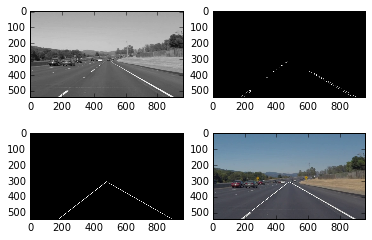

In [211]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [212]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

Slope:  0.649871592369 Intercept:  -5.14646736146
Slope:  -0.637454983912 Intercept:  618.177325303
Point one:  (484, 309) Point two:  (960, 618)
Point one:  (484, 309) Point two:  (0, 618)
(540, 960, 3)
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4








  0%|          | 0/682 [00:00<?, ?it/s]

Slope:  0.649871592369 Intercept:  -5.14646736146
Slope:  -0.637454983912 Intercept:  618.177325303
Point one:  (484, 309) Point two:  (960, 618)
Point one:  (484, 309) Point two:  (0, 618)








  0%|          | 1/682 [00:00<01:18,  8.63it/s]

(540, 960, 3)
Slope:  0.644840016981 Intercept:  -2.38669443966
Slope:  -0.614394540115 Intercept:  609.117858259
Point one:  (485, 310) Point two:  (960, 616)
Point one:  (485, 310) Point two:  (0, 609)








  0%|          | 3/682 [00:00<01:10,  9.68it/s]

(540, 960, 3)
Slope:  0.658286201437 Intercept:  -11.0470748995
Slope:  -0.629248130517 Intercept:  612.742700064
Point one:  (484, 307) Point two:  (960, 620)
Point one:  (484, 307) Point two:  (0, 612)
(540, 960, 3)
Slope:  0.669811509466 Intercept:  -17.9810820043
Slope:  -0.64122415943 Intercept:  619.351079504
Point one:  (486, 307) Point two:  (960, 625)
Point one:  (486, 307) Point two:  (0, 619)


(540, 960, 3)
Slope:  0.599478769387 Intercept:  38.1648868548
Slope:  -0.639097569671 Intercept:  617.769441588
Point one:  (467, 318) Point two:  (960, 613)
Point one:  (467, 318) Point two:  (0, 617)








  1%|          | 5/682 [00:00<01:02, 10.80it/s]

(540, 960, 3)
Slope:  0.623571428571 Intercept:  7.14928571429
Slope:  -0.642504398713 Intercept:  623.438022091
Point one:  (486, 310) Point two:  (960, 605)
Point one:  (486, 310) Point two:  (0, 623)
(540, 960, 3)
Slope:  0.623148148148 Intercept:  9.30555555556
Slope:  -0.648408836396 Intercept:  625.307471053
Point one:  (484, 311) Point two:  (960, 607)
Point one:  (484, 311) Point two:  (0, 625)








  1%|          | 7/682 [00:00<00:57, 11.84it/s]

(540, 960, 3)
Slope:  0.685142769889 Intercept:  -30.1230722248
Slope:  -0.650789335993 Intercept:  625.204604146
Point one:  (490, 305) Point two:  (960, 627)
Point one:  (490, 305) Point two:  (0, 625)
(540, 960, 3)








  1%|▏         | 9/682 [00:00<00:53, 12.65it/s]

Slope:  0.679495542509 Intercept:  -29.4437921287
Slope:  -0.637824626819 Intercept:  619.695812404
Point one:  (492, 305) Point two:  (960, 622)
Point one:  (492, 305) Point two:  (0, 619)
(540, 960, 3)
Slope:  0.713037770806 Intercept:  -50.1117029821
Slope:  -0.640976149671 Intercept:  621.0561724
Point one:  (495, 303) Point two:  (960, 634)
Point one:  (495, 303) Point two:  (0, 621)
(540, 960, 3)








  2%|▏         | 11/682 [00:00<00:50, 13.31it/s]

Slope:  0.593939393939 Intercept:  24.8848484848
Slope:  -0.683702507932 Intercept:  636.37563566
Point one:  (478, 309) Point two:  (960, 595)
Point one:  (478, 309) Point two:  (0, 636)
(540, 960, 3)
Slope:  0.713797313797 Intercept:  -50.9096459096
Slope:  -0.658935110158 Intercept:  625.800761004
Point one:  (492, 300) Point two:  (960, 634)
Point one:  (492, 300) Point two:  (0, 625)








  2%|▏         | 13/682 [00:00<00:47, 13.97it/s]

(540, 960, 3)
Slope:  0.646971691903 Intercept:  -9.01761026991
Slope:  -0.655095170864 Intercept:  624.788596501
Point one:  (486, 305) Point two:  (960, 612)
Point one:  (486, 305) Point two:  (0, 624)
(540, 960, 3)
Slope:  0.626262544925 Intercept:  3.77236964898
Slope:  -0.674451259326 Intercept:  633.980879011
Point one:  (484, 307) Point two:  (960, 604)
Point one:  (484, 307) Point two:  (0, 633)








  2%|▏         | 15/682 [00:01<00:46, 14.47it/s]

(540, 960, 3)
Slope:  0.624512291442 Intercept:  6.19904613176
Slope:  -0.716674673962 Intercept:  648.558223371
Point one:  (478, 305) Point two:  (960, 605)
Point one:  (478, 305) Point two:  (0, 648)
(540, 960, 3)








  2%|▏         | 17/682 [00:01<00:44, 14.96it/s]

Slope:  0.620381379753 Intercept:  9.03475534285
Slope:  -0.672637113464 Intercept:  633.268794346
Point one:  (482, 308) Point two:  (960, 604)
Point one:  (482, 308) Point two:  (0, 633)
(540, 960, 3)
Slope:  0.63526025202 Intercept:  -1.59970198894
Slope:  -0.668734436836 Intercept:  631.976048853
Point one:  (485, 307) Point two:  (960, 608)
Point one:  (485, 307) Point two:  (0, 631)
(540, 960, 3)


Slope:  -0.687630708501 Intercept:  639.145878519
Point one:  (483, 306) Point two:  (960, 612)
Point one:  (483, 306) Point two:  (0, 639)
(540, 960, 3)
Slope:  -0.68649959531 Intercept:  636.619570228
Point one:  (479, 307) Point two:  (960, 598)
Point one:  (479, 307) Point two:  (0, 636)








  3%|▎         | 19/682 [00:01<00:43, 15.35it/s]

(540, 960, 3)
Slope:  0.579328756674 Intercept:  31.0709382151
Slope:  -0.710630556827 Intercept:  649.032095756
Point one:  (479, 308) Point two:  (960, 587)
Point one:  (479, 308) Point two:  (0, 649)
(540, 960, 3)
Slope:  0.625053713539 Intercept:  2.36410044862
Slope:  -0.747502275296 Intercept:  662.466732285
Point one:  (480, 302) Point two:  (960, 602)
Point one:  (480, 302) Point two:  (0, 662)








  3%|▎         | 21/682 [00:01<00:42, 15.48it/s]

(540, 960, 3)
Slope:  0.604195804196 Intercept:  16.7304195804
Slope:  -0.694545751778 Intercept:  639.140872555
Point one:  (479, 306) Point two:  (960, 596)
Point one:  (479, 306) Point two:  (0, 639)
(540, 960, 3)








  3%|▎         | 23/682 [00:01<00:42, 15.52it/s]

Slope:  0.643495916237 Intercept:  -8.57581828789
Slope:  -0.685334030744 Intercept:  634.591423249
Point one:  (484, 302) Point two:  (960, 609)
Point one:  (484, 302) Point two:  (0, 634)
(540, 960, 3)
Slope:  0.610287410054 Intercept:  10.0733482975
Slope:  -0.705503081232 Intercept:  643.47933835
Point one:  (481, 303) Point two:  (960, 595)
Point one:  (481, 303) Point two:  (0, 643)
(540, 960, 3)








  4%|▎         | 25/682 [00:01<00:42, 15.60it/s]

Slope:  0.637617529704 Intercept:  -5.2358532698
Slope:  -0.692084939969 Intercept:  639.662878154
Point one:  (484, 304) Point two:  (960, 606)
Point one:  (484, 304) Point two:  (0, 639)
(540, 960, 3)
Slope:  0.632823998054 Intercept:  -3.11487675603
Slope:  -0.725762598732 Intercept:  655.48225008
Point one:  (484, 303) Point two:  (960, 604)
Point one:  (484, 303) Point two:  (0, 655)








  4%|▍         | 27/682 [00:01<00:44, 14.73it/s]

(540, 960, 3)
Slope:  0.611207256882 Intercept:  12.9825300728
Slope:  -0.67744285629 Intercept:  635.239739986
Point one:  (482, 308) Point two:  (960, 599)
Point one:  (482, 308) Point two:  (0, 635)
(540, 960, 3)


Slope:  0.598071670436 Intercept:  19.8320708173
Slope:  -0.749273806081 Intercept:  664.699022986
Point one:  (478, 306) Point two:  (960, 593)
Point one:  (478, 306) Point two:  (0, 664)
(540, 960, 3)
Slope:  0.58195010927 Intercept:  32.4454501563
Slope:  -0.693318055292 Intercept:  642.528872755
Point one:  (478, 310) Point two:  (960, 591)
Point one:  (478, 310) Point two:  (0, 642)








  4%|▍         | 29/682 [00:02<00:48, 13.43it/s]

(540, 960, 3)
Slope:  0.601780664546 Intercept:  14.9451661364
Slope:  -0.692260236405 Intercept:  639.45435293
Point one:  (482, 305) Point two:  (960, 592)
Point one:  (482, 305) Point two:  (0, 639)








  5%|▍         | 31/682 [00:02<00:48, 13.44it/s]

(540, 960, 3)
Slope:  -0.723012036485 Intercept:  652.31173127
Point one:  (477, 306) Point two:  (960, 582)
Point one:  (477, 306) Point two:  (0, 652)
(540, 960, 3)
Slope:  -0.729601682541 Intercept:  653.795015471
Point one:  (474, 307) Point two:  (960, 581)
Point one:  (474, 307) Point two:  (0, 653)








  5%|▍         | 33/682 [00:02<00:45, 14.14it/s]

(540, 960, 3)
Slope:  -0.740819973338 Intercept:  658.911451799
Point one:  (478, 304) Point two:  (960, 593)
Point one:  (478, 304) Point two:  (0, 658)
(540, 960, 3)








  5%|▌         | 35/682 [00:02<00:43, 14.80it/s]

Slope:  0.619216480919 Intercept:  3.40391759541
Slope:  -0.716127632422 Intercept:  647.999186128
Point one:  (482, 302) Point two:  (960, 597)
Point one:  (482, 302) Point two:  (0, 647)
(540, 960, 3)
Slope:  0.609430664785 Intercept:  9.92169120118
Slope:  -0.733845806288 Intercept:  655.991450014
Point one:  (480, 303) Point two:  (960, 594)
Point one:  (480, 303) Point two:  (0, 655)
(540, 960, 3)


Slope:  0.597677853193 Intercept:  16.8447712418
Slope:  -0.76113538737 Intercept:  665.842825966
Point one:  (477, 302) Point two:  (960, 590)
Point one:  (477, 302) Point two:  (0, 665)
(540, 960, 3)
Slope:  0.605487474117 Intercept:  11.2384328805
Slope:  -0.72891512492 Intercept:  654.100067088
Point one:  (481, 302) Point two:  (960, 592)
Point one:  (481, 302) Point two:  (0, 654)








  5%|▌         | 37/682 [00:02<00:42, 15.05it/s]

(540, 960, 3)
Slope:  0.590383707618 Intercept:  22.6604635337
Slope:  -0.736638367876 Intercept:  654.063883194
Point one:  (475, 303) Point two:  (960, 589)
Point one:  (475, 303) Point two:  (0, 654)
(540, 960, 3)
Slope:  0.584630165756 Intercept:  26.698401781
Slope:  -0.731746292244 Intercept:  652.66466045
Point one:  (475, 304) Point two:  (960, 587)
Point one:  (475, 304) Point two:  (0, 652)








  6%|▌         | 39/682 [00:02<00:41, 15.49it/s]

(540, 960, 3)
Slope:  0.600071123775 Intercept:  14.9937588581
Slope:  -0.738191329458 Intercept:  657.862818977
Point one:  (480, 303) Point two:  (960, 591)
Point one:  (480, 303) Point two:  (0, 657)
(540, 960, 3)








  6%|▌         | 41/682 [00:02<00:40, 15.73it/s]

Slope:  0.625478670825 Intercept:  -4.09152835154
Slope:  -0.743915303451 Intercept:  653.712614484
Point one:  (480, 296) Point two:  (960, 596)
Point one:  (480, 296) Point two:  (0, 653)
(540, 960, 3)
Slope:  0.582517992861 Intercept:  29.1011111993
Slope:  -0.730465864548 Intercept:  651.839670119
Point one:  (474, 305) Point two:  (960, 588)
Point one:  (474, 305) Point two:  (0, 651)
(540, 960, 3)








  6%|▋         | 43/682 [00:02<00:40, 15.71it/s]

Slope:  -0.740129706368 Intercept:  655.877888732
Point one:  (374, 378) Point two:  (960, 466)
Point one:  (374, 378) Point two:  (0, 655)
(540, 960, 3)
Slope:  -0.727323145213 Intercept:  650.447382857
Point one:  (477, 303) Point two:  (960, 592)
Point one:  (477, 303) Point two:  (0, 650)








  7%|▋         | 45/682 [00:03<00:40, 15.74it/s]

(540, 960, 3)
Slope:  -0.72254231799 Intercept:  649.417839016
Point one:  (475, 305) Point two:  (960, 588)
Point one:  (475, 305) Point two:  (0, 649)
(540, 960, 3)
Slope:  0.662209302326 Intercept:  -20.6226744186
Slope:  -0.737237421389 Intercept:  653.45785803
Point one:  (481, 298) Point two:  (960, 615)
Point one:  (481, 298) Point two:  (0, 653)








  7%|▋         | 47/682 [00:03<00:40, 15.83it/s]

(540, 960, 3)
Slope:  0.602262268544 Intercept:  15.8155416712
Slope:  -0.706885028886 Intercept:  642.958064768
Point one:  (479, 304) Point two:  (960, 593)
Point one:  (479, 304) Point two:  (0, 642)
(540, 960, 3)








  7%|▋         | 49/682 [00:03<00:40, 15.78it/s]

Slope:  0.608756188119 Intercept:  11.286355198
Slope:  -0.737353662816 Intercept:  656.374294584
Point one:  (479, 303) Point two:  (960, 595)
Point one:  (479, 303) Point two:  (0, 656)
(540, 960, 3)
Slope:  0.626961389157 Intercept:  -0.954518308177
Slope:  -0.731338562116 Intercept:  651.648320466
Point one:  (480, 300) Point two:  (960, 600)
Point one:  (480, 300) Point two:  (0, 651)
(540, 960, 3)


Slope:  0.621618923434 Intercept:  1.85333523491
Slope:  -0.73082100455 Intercept:  652.283729711
Point one:  (480, 300) Point two:  (960, 598)
Point one:  (480, 300) Point two:  (0, 652)
(540, 960, 3)
Slope:  0.609719642521 Intercept:  10.2647877466
Slope:  -0.740140600461 Intercept:  653.13573196
Point one:  (476, 300) Point two:  (960, 595)
Point one:  (476, 300) Point two:  (0, 653)








  7%|▋         | 51/682 [00:03<00:40, 15.58it/s]

(540, 960, 3)
Slope:  0.593004336527 Intercept:  22.4712366221
Slope:  -0.756756395175 Intercept:  658.960706889
Point one:  (471, 302) Point two:  (960, 591)
Point one:  (471, 302) Point two:  (0, 658)
(540, 960, 3)
Slope:  0.601139692944 Intercept:  16.1244960998
Slope:  -0.789786862794 Intercept:  670.47208509
Point one:  (470, 298) Point two:  (960, 593)
Point one:  (470, 298) Point two:  (0, 670)








  8%|▊         | 53/682 [00:03<00:40, 15.57it/s]

(540, 960, 3)
Slope:  0.595514508533 Intercept:  22.5081911176
Slope:  -0.725035524899 Intercept:  649.41094776
Point one:  (474, 305) Point two:  (960, 594)
Point one:  (474, 305) Point two:  (0, 649)
(540, 960, 3)








  8%|▊         | 55/682 [00:03<00:39, 15.75it/s]

Slope:  0.616619243851 Intercept:  4.64213762428
Slope:  -0.725407777523 Intercept:  649.014436711
Point one:  (480, 300) Point two:  (960, 596)
Point one:  (480, 300) Point two:  (0, 649)
(540, 960, 3)
Slope:  -0.746243910129 Intercept:  658.222862886
Point one:  (465, 310) Point two:  (960, 565)
Point one:  (465, 310) Point two:  (0, 658)
(540, 960, 3)








  8%|▊         | 57/682 [00:03<00:39, 15.83it/s]

Slope:  -0.743946316391 Intercept:  655.680014595
Point one:  (471, 304) Point two:  (960, 577)
Point one:  (471, 304) Point two:  (0, 655)
(540, 960, 3)
Slope:  0.608823529412 Intercept:  13.5529411765
Slope:  -0.721851012857 Intercept:  650.60053988
Point one:  (478, 305) Point two:  (960, 598)
Point one:  (478, 305) Point two:  (0, 650)








  9%|▊         | 59/682 [00:03<00:39, 15.82it/s]

(540, 960, 3)
Slope:  0.618181818182 Intercept:  8.09696969697
Slope:  -0.750334383008 Intercept:  659.180256408
Point one:  (475, 302) Point two:  (960, 601)
Point one:  (475, 302) Point two:  (0, 659)
(540, 960, 3)
Slope:  0.613933236575 Intercept:  11.4470246734
Slope:  -0.700429150415 Intercept:  640.678328602
Point one:  (478, 305) Point two:  (960, 600)
Point one:  (478, 305) Point two:  (0, 640)








  9%|▉         | 61/682 [00:04<00:39, 15.88it/s]

(540, 960, 3)
Slope:  0.606603703428 Intercept:  15.0487262752
Slope:  -0.717867493863 Intercept:  646.410619985
Point one:  (476, 304) Point two:  (960, 597)
Point one:  (476, 304) Point two:  (0, 646)
(540, 960, 3)








  9%|▉         | 63/682 [00:04<00:38, 15.91it/s]

Slope:  0.582844112978 Intercept:  31.1584360066
Slope:  -0.714258722726 Intercept:  643.010196459
Point one:  (471, 306) Point two:  (960, 590)
Point one:  (471, 306) Point two:  (0, 643)
(540, 960, 3)
Slope:  0.60071917656 Intercept:  16.1064748121
Slope:  -0.69229653243 Intercept:  636.33759991
Point one:  (479, 304) Point two:  (960, 592)
Point one:  (479, 304) Point two:  (0, 636)
(540, 960, 3)


Slope:  0.614140021995 Intercept:  10.6306077415
Slope:  -0.718697656204 Intercept:  644.103369259
Point one:  (475, 302) Point two:  (960, 600)
Point one:  (475, 302) Point two:  (0, 644)
(540, 960, 3)
Slope:  0.611659292046 Intercept:  12.1499595009
Slope:  -0.71384291514 Intercept:  644.951761014
Point one:  (477, 304) Point two:  (960, 599)
Point one:  (477, 304) Point two:  (0, 644)








 10%|▉         | 65/682 [00:04<00:38, 15.90it/s]

(540, 960, 3)
Slope:  0.603016513432 Intercept:  18.5824871189
Slope:  -0.713569732581 Intercept:  645.046651744
Point one:  (475, 305) Point two:  (960, 597)
Point one:  (475, 305) Point two:  (0, 645)
(540, 960, 3)
Slope:  0.561581054604 Intercept:  49.0754834313
Slope:  -0.711019613335 Intercept:  643.524894481
Point one:  (467, 311) Point two:  (960, 588)
Point one:  (467, 311) Point two:  (0, 643)








 10%|▉         | 67/682 [00:04<00:38, 16.02it/s]

(540, 960, 3)
Slope:  -0.711981346542 Intercept:  644.230057044
Point one:  (486, 297) Point two:  (960, 613)
Point one:  (486, 297) Point two:  (0, 644)
(540, 960, 3)








 10%|█         | 69/682 [00:04<00:39, 15.68it/s]

Slope:  0.596445029625 Intercept:  25.3459512837
Slope:  -0.712383276489 Intercept:  642.463468379
Point one:  (471, 306) Point two:  (960, 597)
Point one:  (471, 306) Point two:  (0, 642)
(540, 960, 3)
Slope:  0.614516129032 Intercept:  14.7693548387
Slope:  -0.725059151385 Intercept:  643.803606641
Point one:  (469, 303) Point two:  (960, 604)
Point one:  (469, 303) Point two:  (0, 643)
(540, 960, 3)








 10%|█         | 71/682 [00:04<00:38, 15.95it/s]

Slope:  -0.711105903277 Intercept:  643.756018206
Point one:  (482, 300) Point two:  (960, 607)
Point one:  (482, 300) Point two:  (0, 643)
(540, 960, 3)
Slope:  0.597221465046 Intercept:  22.7545203438
Slope:  -0.751085848281 Intercept:  663.072678472
Point one:  (474, 306) Point two:  (960, 596)
Point one:  (474, 306) Point two:  (0, 663)








 11%|█         | 73/682 [00:04<00:38, 16.01it/s]

(540, 960, 3)
Slope:  0.592516911534 Intercept:  25.7616895407
Slope:  -0.716146538542 Intercept:  649.430119184
Point one:  (476, 308) Point two:  (960, 594)
Point one:  (476, 308) Point two:  (0, 649)
(540, 960, 3)
Slope:  0.624260285357 Intercept:  7.32661934832
Slope:  -0.729520882197 Intercept:  653.168067264
Point one:  (477, 305) Point two:  (960, 606)
Point one:  (477, 305) Point two:  (0, 653)








 11%|█         | 75/682 [00:04<00:37, 16.15it/s]

(540, 960, 3)
Slope:  0.620557083253 Intercept:  10.1595601755
Slope:  -0.69207766593 Intercept:  638.754000209
Point one:  (478, 307) Point two:  (960, 605)
Point one:  (478, 307) Point two:  (0, 638)
(540, 960, 3)








 11%|█▏        | 77/682 [00:05<00:38, 15.59it/s]

Slope:  0.623776381775 Intercept:  8.47489674943
Slope:  -0.714333287084 Intercept:  645.996261055
Point one:  (476, 305) Point two:  (960, 607)
Point one:  (476, 305) Point two:  (0, 645)
(540, 960, 3)
Slope:  0.621549019288 Intercept:  10.4447666357
Slope:  -0.724638566722 Intercept:  652.018309078
Point one:  (476, 306) Point two:  (960, 607)
Point one:  (476, 306) Point two:  (0, 652)
(540, 960, 3)


Slope:  0.619108803301 Intercept:  11.1325871716
Slope:  -0.717004891488 Intercept:  645.229726243
Point one:  (474, 304) Point two:  (960, 605)
Point one:  (474, 304) Point two:  (0, 645)
(540, 960, 3)
Slope:  0.628514806435 Intercept:  6.38236075451
Slope:  -0.723606604027 Intercept:  650.576378505
Point one:  (476, 305) Point two:  (960, 609)
Point one:  (476, 305) Point two:  (0, 650)








 12%|█▏        | 79/682 [00:05<00:37, 15.91it/s]

(540, 960, 3)
Slope:  0.637724599426 Intercept:  -1.17869084005
Slope:  -0.708293790497 Intercept:  642.968681624
Point one:  (478, 304) Point two:  (960, 611)
Point one:  (478, 304) Point two:  (0, 642)
(540, 960, 3)
Slope:  -0.697349093944 Intercept:  639.471128935
Point one:  (480, 304) Point two:  (960, 604)
Point one:  (480, 304) Point two:  (0, 639)








 12%|█▏        | 81/682 [00:05<00:37, 16.11it/s]

(540, 960, 3)
Slope:  -0.721703910258 Intercept:  646.854500965
Point one:  (472, 305) Point two:  (960, 606)
Point one:  (472, 305) Point two:  (0, 646)
(540, 960, 3)








 12%|█▏        | 83/682 [00:05<00:36, 16.31it/s]

Slope:  -0.712033212206 Intercept:  642.145031288
Point one:  (473, 304) Point two:  (960, 609)
Point one:  (473, 304) Point two:  (0, 642)
(540, 960, 3)
Slope:  0.686669338142 Intercept:  -30.3842583317
Slope:  -0.693927473745 Intercept:  636.855268868
Point one:  (483, 301) Point two:  (960, 628)
Point one:  (483, 301) Point two:  (0, 636)
(540, 960, 3)








 12%|█▏        | 85/682 [00:05<00:36, 16.55it/s]

Slope:  0.615655454027 Intercept:  14.2769018134
Slope:  -0.704388067904 Intercept:  641.447917082
Point one:  (475, 306) Point two:  (960, 605)
Point one:  (475, 306) Point two:  (0, 641)
(540, 960, 3)
Slope:  0.610648148148 Intercept:  16.9277777778
Slope:  -0.708368924425 Intercept:  640.663386533
Point one:  (472, 305) Point two:  (960, 603)
Point one:  (472, 305) Point two:  (0, 640)








 13%|█▎        | 87/682 [00:05<00:35, 16.60it/s]

(540, 960, 3)
Slope:  0.639541693099 Intercept:  -2.10090355279
Slope:  -0.694247890339 Intercept:  638.326588437
Point one:  (480, 304) Point two:  (960, 611)
Point one:  (480, 304) Point two:  (0, 638)
(540, 960, 3)
Slope:  0.611752896488 Intercept:  16.3799291329
Slope:  -0.706591214253 Intercept:  642.312703768
Point one:  (474, 306) Point two:  (960, 603)
Point one:  (474, 306) Point two:  (0, 642)








 13%|█▎        | 89/682 [00:05<00:35, 16.51it/s]

(540, 960, 3)
Slope:  0.60274955694 Intercept:  20.7553209952
Slope:  -0.693494233506 Intercept:  636.164149583
Point one:  (474, 306) Point two:  (960, 599)
Point one:  (474, 306) Point two:  (0, 636)
(540, 960, 3)








 13%|█▎        | 91/682 [00:05<00:35, 16.65it/s]

Slope:  0.6157508578 Intercept:  11.8183608015
Slope:  -0.685897816884 Intercept:  634.186443138
Point one:  (478, 306) Point two:  (960, 602)
Point one:  (478, 306) Point two:  (0, 634)
(540, 960, 3)
Slope:  0.62862216369 Intercept:  6.56579006746
Slope:  -0.690065746643 Intercept:  636.78629135
Point one:  (477, 306) Point two:  (960, 610)
Point one:  (477, 306) Point two:  (0, 636)
(540, 960, 3)


Slope:  0.662362953816 Intercept:  -16.2081887114
Slope:  -0.687867541683 Intercept:  638.312217134
Point one:  (484, 304) Point two:  (960, 619)
Point one:  (484, 304) Point two:  (0, 638)
(540, 960, 3)
Slope:  0.630866570309 Intercept:  7.3129924346
Slope:  -0.68118598703 Intercept:  637.187667233
Point one:  (480, 310) Point two:  (960, 612)
Point one:  (480, 310) Point two:  (0, 637)








 14%|█▎        | 93/682 [00:06<00:35, 16.71it/s]

(540, 960, 3)
Slope:  0.634858156028 Intercept:  3.52443262411
Slope:  -0.685875727539 Intercept:  637.810899046
Point one:  (480, 308) Point two:  (960, 612)
Point one:  (480, 308) Point two:  (0, 637)
(540, 960, 3)
Slope:  0.606387764283 Intercept:  20.7883490778
Slope:  -0.691082980254 Intercept:  639.041717726
Point one:  (476, 309) Point two:  (960, 602)
Point one:  (476, 309) Point two:  (0, 639)








 14%|█▍        | 95/682 [00:06<00:35, 16.75it/s]

(540, 960, 3)
Slope:  0.638329430133 Intercept:  1.6043715847
Slope:  -0.690207125432 Intercept:  640.885724266
Point one:  (481, 308) Point two:  (960, 614)
Point one:  (481, 308) Point two:  (0, 640)
(540, 960, 3)








 14%|█▍        | 97/682 [00:06<00:34, 16.86it/s]

Slope:  0.596266369462 Intercept:  25.4183616606
Slope:  -0.698066911988 Intercept:  645.22729229
Point one:  (478, 310) Point two:  (960, 597)
Point one:  (478, 310) Point two:  (0, 645)
(540, 960, 3)
Slope:  0.624022608306 Intercept:  10.7572376924
Slope:  -0.704100734728 Intercept:  647.366487844
Point one:  (479, 309) Point two:  (960, 609)
Point one:  (479, 309) Point two:  (0, 647)
(540, 960, 3)








 15%|█▍        | 99/682 [00:06<00:34, 16.78it/s]

Slope:  0.65361192981 Intercept:  -9.82012130203
Slope:  -0.747696537332 Intercept:  657.434420643
Point one:  (476, 301) Point two:  (960, 617)
Point one:  (476, 301) Point two:  (0, 657)
(540, 960, 3)
Slope:  0.639801864802 Intercept:  -0.0547785547786
Slope:  -0.69092282556 Intercept:  640.824253149
Point one:  (481, 308) Point two:  (960, 614)
Point one:  (481, 308) Point two:  (0, 640)








 15%|█▍        | 101/682 [00:06<00:34, 16.62it/s]

(540, 960, 3)
Slope:  0.63850128137 Intercept:  0.770113144142
Slope:  -0.69067959708 Intercept:  640.99617756
Point one:  (481, 308) Point two:  (960, 613)
Point one:  (481, 308) Point two:  (0, 640)
(540, 960, 3)
Slope:  0.618238177847 Intercept:  12.2832589127
Slope:  -0.720174936893 Intercept:  649.365680024
Point one:  (475, 306) Point two:  (960, 605)
Point one:  (475, 306) Point two:  (0, 649)








 15%|█▌        | 103/682 [00:06<00:35, 16.44it/s]

(540, 960, 3)
Slope:  0.636284048027 Intercept:  1.84123020466
Slope:  -0.734718975187 Intercept:  654.329634062
Point one:  (475, 304) Point two:  (960, 612)
Point one:  (475, 304) Point two:  (0, 654)
(540, 960, 3)








 15%|█▌        | 105/682 [00:06<00:35, 16.44it/s]

Slope:  0.637564796424 Intercept:  -0.62995883304
Slope:  -0.687729278235 Intercept:  637.59759726
Point one:  (481, 306) Point two:  (960, 611)
Point one:  (481, 306) Point two:  (0, 637)
(540, 960, 3)
Slope:  0.588849410548 Intercept:  36.4967056005
Slope:  -0.681298740735 Intercept:  634.295486994
Point one:  (470, 313) Point two:  (960, 601)
Point one:  (470, 313) Point two:  (0, 634)
(540, 960, 3)


Slope:  0.529518971954 Intercept:  82.7964936329
Slope:  -0.686061578998 Intercept:  636.222348397
Point one:  (455, 323) Point two:  (960, 591)
Point one:  (455, 323) Point two:  (0, 636)
(540, 960, 3)
Slope:  0.581481481481 Intercept:  34.0962962963
Slope:  -0.694816883632 Intercept:  639.815639046
Point one:  (474, 310) Point two:  (960, 592)
Point one:  (474, 310) Point two:  (0, 639)








 16%|█▌        | 107/682 [00:06<00:35, 16.38it/s]

(540, 960, 3)
Slope:  0.624074074074 Intercept:  11.7740740741
Slope:  -0.719333865226 Intercept:  646.658218388
Point one:  (472, 306) Point two:  (960, 610)
Point one:  (472, 306) Point two:  (0, 646)
(540, 960, 3)
Slope:  0.651368871643 Intercept:  -8.27577605322
Slope:  -0.664621533218 Intercept:  630.508163892
Point one:  (485, 307) Point two:  (960, 617)
Point one:  (485, 307) Point two:  (0, 630)








 16%|█▌        | 109/682 [00:06<00:34, 16.38it/s]

(540, 960, 3)
Slope:  0.6471543512 Intercept:  -5.45145840909
Slope:  -0.663161973327 Intercept:  628.759747846
Point one:  (484, 307) Point two:  (960, 615)
Point one:  (484, 307) Point two:  (0, 628)
(540, 960, 3)








 16%|█▋        | 111/682 [00:07<00:35, 16.14it/s]

Slope:  0.609695258 Intercept:  20.0126557192
Slope:  -0.684102591856 Intercept:  638.855884145
Point one:  (478, 311) Point two:  (960, 605)
Point one:  (478, 311) Point two:  (0, 638)
(540, 960, 3)
Slope:  0.634374733638 Intercept:  3.19031350579
Slope:  -0.687463066281 Intercept:  640.270513551
Point one:  (481, 308) Point two:  (960, 612)
Point one:  (481, 308) Point two:  (0, 640)
(540, 960, 3)








 17%|█▋        | 113/682 [00:07<00:35, 15.96it/s]

Slope:  0.632371740892 Intercept:  4.64508039297
Slope:  -0.707427830054 Intercept:  646.477576801
Point one:  (479, 307) Point two:  (960, 611)
Point one:  (479, 307) Point two:  (0, 646)
(540, 960, 3)
Slope:  0.614569285592 Intercept:  14.9160371828
Slope:  -0.714484689399 Intercept:  649.612979669
Point one:  (477, 308) Point two:  (960, 604)
Point one:  (477, 308) Point two:  (0, 649)








 17%|█▋        | 115/682 [00:07<00:36, 15.74it/s]

(540, 960, 3)
Slope:  0.627825307224 Intercept:  6.25565788682
Slope:  -0.721812938127 Intercept:  651.614904242
Point one:  (478, 306) Point two:  (960, 608)
Point one:  (478, 306) Point two:  (0, 651)
(540, 960, 3)
Slope:  0.612448935798 Intercept:  16.4861285367
Slope:  -0.683069485355 Intercept:  639.228173377
Point one:  (480, 310) Point two:  (960, 604)
Point one:  (480, 310) Point two:  (0, 639)








 17%|█▋        | 117/682 [00:07<00:35, 15.76it/s]

(540, 960, 3)
Slope:  0.647362856577 Intercept:  -7.4637639973
Slope:  -0.69984136292 Intercept:  643.720060486
Point one:  (483, 305) Point two:  (960, 614)
Point one:  (483, 305) Point two:  (0, 643)
(540, 960, 3)








 17%|█▋        | 119/682 [00:07<00:35, 15.91it/s]

Slope:  0.621737550051 Intercept:  11.2763195579
Slope:  -0.704555798155 Intercept:  647.296852761
Point one:  (479, 309) Point two:  (960, 608)
Point one:  (479, 309) Point two:  (0, 647)
(540, 960, 3)
Slope:  0.632653061224 Intercept:  3.66326530612
Slope:  -0.734219262215 Intercept:  651.75860291
Point one:  (474, 303) Point two:  (960, 611)
Point one:  (474, 303) Point two:  (0, 651)
(540, 960, 3)


Slope:  0.621212121212 Intercept:  9.5303030303
Slope:  -0.730534190872 Intercept:  650.55471027
Point one:  (474, 304) Point two:  (960, 605)
Point one:  (474, 304) Point two:  (0, 650)
(540, 960, 3)
Slope:  0.650089605735 Intercept:  -7.54256272401
Slope:  -0.709946038513 Intercept:  648.072488313
Point one:  (482, 305) Point two:  (960, 616)
Point one:  (482, 305) Point two:  (0, 648)








 18%|█▊        | 121/682 [00:07<00:35, 15.80it/s]

(540, 960, 3)
Slope:  0.649324313461 Intercept:  -7.44132259309
Slope:  -0.699195063734 Intercept:  643.558744928
Point one:  (482, 306) Point two:  (960, 615)
Point one:  (482, 306) Point two:  (0, 643)
(540, 960, 3)
Slope:  0.58044289843 Intercept:  35.6604642196
Slope:  -0.706552885857 Intercept:  645.021837212
Point one:  (473, 310) Point two:  (960, 592)
Point one:  (473, 310) Point two:  (0, 645)








 18%|█▊        | 123/682 [00:07<00:35, 15.87it/s]

(540, 960, 3)
Slope:  0.616405703524 Intercept:  10.8896906107
Slope:  -0.696298854619 Intercept:  643.314574619
Point one:  (481, 307) Point two:  (960, 602)
Point one:  (481, 307) Point two:  (0, 643)
(540, 960, 3)








 18%|█▊        | 125/682 [00:07<00:35, 15.65it/s]

Slope:  0.627704483139 Intercept:  5.30347452195
Slope:  -0.697638774773 Intercept:  642.383692669
Point one:  (480, 307) Point two:  (960, 607)
Point one:  (480, 307) Point two:  (0, 642)
(540, 960, 3)
Slope:  0.59866217375 Intercept:  23.2044955601
Slope:  -0.72627777618 Intercept:  653.172934148
Point one:  (475, 307) Point two:  (960, 597)
Point one:  (475, 307) Point two:  (0, 653)
(540, 960, 3)








 19%|█▊        | 127/682 [00:08<00:35, 15.54it/s]

Slope:  0.610611652257 Intercept:  16.9455100776
Slope:  -0.713871677103 Intercept:  648.215775161
Point one:  (476, 307) Point two:  (960, 603)
Point one:  (476, 307) Point two:  (0, 648)
(540, 960, 3)
Slope:  0.616964943705 Intercept:  14.0633218429
Slope:  -0.708599141026 Intercept:  647.086350169
Point one:  (477, 308) Point two:  (960, 606)
Point one:  (477, 308) Point two:  (0, 647)








 19%|█▉        | 129/682 [00:08<00:35, 15.60it/s]

(540, 960, 3)
Slope:  0.636805980068 Intercept:  -0.149311244833
Slope:  -0.709651774582 Intercept:  647.115835168
Point one:  (480, 305) Point two:  (960, 611)
Point one:  (480, 305) Point two:  (0, 647)
(540, 960, 3)
Slope:  0.658690560276 Intercept:  -13.2731112131
Slope:  -0.714372926476 Intercept:  648.555113326
Point one:  (482, 304) Point two:  (960, 619)
Point one:  (482, 304) Point two:  (0, 648)








 19%|█▉        | 131/682 [00:08<00:35, 15.64it/s]

(540, 960, 3)
Slope:  0.605461669788 Intercept:  23.9051089401
Slope:  -0.694661946928 Intercept:  643.064662811
Point one:  (476, 312) Point two:  (960, 605)
Point one:  (476, 312) Point two:  (0, 643)
(540, 960, 3)








 20%|█▉        | 133/682 [00:08<00:35, 15.55it/s]

Slope:  0.624179143683 Intercept:  7.43209876543
Slope:  -0.715859318955 Intercept:  648.094717624
Point one:  (478, 305) Point two:  (960, 606)
Point one:  (478, 305) Point two:  (0, 648)
(540, 960, 3)
Slope:  0.596903460838 Intercept:  24.4285974499
Slope:  -0.694845446708 Intercept:  644.371499024
Point one:  (479, 310) Point two:  (960, 597)
Point one:  (479, 310) Point two:  (0, 644)
(540, 960, 3)


Slope:  0.635572139303 Intercept:  1.5171641791
Slope:  -0.700665942805 Intercept:  646.293343883
Point one:  (482, 308) Point two:  (960, 611)
Point one:  (482, 308) Point two:  (0, 646)
(540, 960, 3)
Slope:  0.634008097166 Intercept:  2.12550607287
Slope:  -0.696723307614 Intercept:  645.059915932
Point one:  (483, 308) Point two:  (960, 610)
Point one:  (483, 308) Point two:  (0, 645)








 20%|█▉        | 135/682 [00:08<00:34, 15.70it/s]

(540, 960, 3)
Slope:  0.621597009816 Intercept:  9.16236568481
Slope:  -0.701290953002 Intercept:  646.440075042
Point one:  (481, 308) Point two:  (960, 605)
Point one:  (481, 308) Point two:  (0, 646)
(540, 960, 3)
Slope:  0.642514506643 Intercept:  -2.71096706673
Slope:  -0.697498729197 Intercept:  646.181488537
Point one:  (484, 308) Point two:  (960, 614)
Point one:  (484, 308) Point two:  (0, 646)








 20%|██        | 137/682 [00:08<00:34, 15.92it/s]

(540, 960, 3)
Slope:  0.622529949099 Intercept:  9.5888768445
Slope:  -0.688540112381 Intercept:  641.148912913
Point one:  (481, 309) Point two:  (960, 607)
Point one:  (481, 309) Point two:  (0, 641)
(540, 960, 3)








 20%|██        | 139/682 [00:08<00:33, 16.09it/s]

Slope:  0.581385382578 Intercept:  34.5372448185
Slope:  -0.725882056146 Intercept:  652.270302055
Point one:  (472, 309) Point two:  (960, 592)
Point one:  (472, 309) Point two:  (0, 652)
(540, 960, 3)
Slope:  0.612952213666 Intercept:  16.9286868449
Slope:  -0.692931580004 Intercept:  641.06265361
Point one:  (477, 309) Point two:  (960, 605)
Point one:  (477, 309) Point two:  (0, 641)
(540, 960, 3)








 21%|██        | 141/682 [00:09<00:33, 16.16it/s]

Slope:  0.640513551777 Intercept:  -1.16606769894
Slope:  -0.721855451826 Intercept:  652.809851339
Point one:  (480, 306) Point two:  (960, 613)
Point one:  (480, 306) Point two:  (0, 652)
(540, 960, 3)
Slope:  0.624390561126 Intercept:  8.71761137583
Slope:  -0.68761429856 Intercept:  640.570913251
Point one:  (481, 309) Point two:  (960, 608)
Point one:  (481, 309) Point two:  (0, 640)








 21%|██        | 143/682 [00:09<00:33, 16.22it/s]

(540, 960, 3)
Slope:  0.621145131719 Intercept:  9.5167776488
Slope:  -0.705687205229 Intercept:  645.162026146
Point one:  (479, 307) Point two:  (960, 605)
Point one:  (479, 307) Point two:  (0, 645)
(540, 960, 3)
Slope:  0.328582898434 Intercept:  264.885186672
Slope:  -0.719386346094 Intercept:  650.912916615
Point one:  (368, 385) Point two:  (960, 580)
Point one:  (368, 385) Point two:  (0, 650)








 21%|██▏       | 145/682 [00:09<00:32, 16.32it/s]

(540, 960, 3)
Slope:  0.608740803764 Intercept:  17.4728950837
Slope:  -0.708925097338 Intercept:  648.370988229
Point one:  (478, 308) Point two:  (960, 601)
Point one:  (478, 308) Point two:  (0, 648)
(540, 960, 3)








 22%|██▏       | 147/682 [00:09<00:32, 16.33it/s]

Slope:  0.630475304266 Intercept:  4.52872946946
Slope:  -0.72030744452 Intercept:  651.357063682
Point one:  (478, 306) Point two:  (960, 609)
Point one:  (478, 306) Point two:  (0, 651)
(540, 960, 3)
Slope:  0.603233775648 Intercept:  20.2651962307
Slope:  -0.709563778574 Intercept:  645.473077253
Point one:  (476, 307) Point two:  (960, 599)
Point one:  (476, 307) Point two:  (0, 645)
(540, 960, 3)


Slope:  0.644101391495 Intercept:  -5.08166862101
Slope:  -0.693721782602 Intercept:  641.528036089
Point one:  (483, 306) Point two:  (960, 613)
Point one:  (483, 306) Point two:  (0, 641)
(540, 960, 3)
Slope:  0.570553384277 Intercept:  42.0123830913
Slope:  -0.710388022365 Intercept:  648.246755606
Point one:  (473, 312) Point two:  (960, 589)
Point one:  (473, 312) Point two:  (0, 648)








 22%|██▏       | 149/682 [00:09<00:32, 16.27it/s]

(540, 960, 3)
Slope:  0.597384990923 Intercept:  22.5750241767
Slope:  -0.720920988156 Intercept:  653.018272642
Point one:  (478, 308) Point two:  (960, 596)
Point one:  (478, 308) Point two:  (0, 653)
(540, 960, 3)
Slope:  0.622508969106 Intercept:  8.60621167351
Slope:  -0.721315032459 Intercept:  652.083282761
Point one:  (478, 306) Point two:  (960, 606)
Point one:  (478, 306) Point two:  (0, 652)








 22%|██▏       | 151/682 [00:09<00:32, 16.18it/s]

(540, 960, 3)
Slope:  0.591969205504 Intercept:  30.1910084456
Slope:  -0.726877921401 Intercept:  656.010037965
Point one:  (474, 311) Point two:  (960, 598)
Point one:  (474, 311) Point two:  (0, 656)
(540, 960, 3)








 22%|██▏       | 153/682 [00:09<00:32, 16.26it/s]

Slope:  0.602117033654 Intercept:  19.6403850583
Slope:  -0.697846997255 Intercept:  645.621419716
Point one:  (481, 309) Point two:  (960, 597)
Point one:  (481, 309) Point two:  (0, 645)
(540, 960, 3)
Slope:  0.592658695621 Intercept:  26.0898863428
Slope:  -0.707995759787 Intercept:  650.413616787
Point one:  (480, 310) Point two:  (960, 595)
Point one:  (480, 310) Point two:  (0, 650)
(540, 960, 3)








 23%|██▎       | 155/682 [00:09<00:32, 16.27it/s]

Slope:  0.616107730871 Intercept:  12.3201765907
Slope:  -0.692863542776 Intercept:  646.872865639
Point one:  (484, 310) Point two:  (960, 603)
Point one:  (484, 310) Point two:  (0, 646)
(540, 960, 3)
Slope:  0.602250385721 Intercept:  19.3784923987
Slope:  -0.694912290929 Intercept:  647.820221154
Point one:  (484, 311) Point two:  (960, 597)
Point one:  (484, 311) Point two:  (0, 647)








 23%|██▎       | 157/682 [00:09<00:31, 16.49it/s]

(540, 960, 3)
Slope:  0.591027436616 Intercept:  28.724610357
Slope:  -0.707126250137 Intercept:  653.291426235
Point one:  (481, 313) Point two:  (960, 596)
Point one:  (481, 313) Point two:  (0, 653)
(540, 960, 3)
Slope:  0.589377292532 Intercept:  29.2508395689
Slope:  -0.705631604839 Intercept:  653.011656063
Point one:  (481, 313) Point two:  (960, 595)
Point one:  (481, 313) Point two:  (0, 653)








 23%|██▎       | 159/682 [00:10<00:31, 16.47it/s]

(540, 960, 3)
Slope:  0.587146215106 Intercept:  29.742211524
Slope:  -0.708502029531 Intercept:  655.378856714
Point one:  (482, 313) Point two:  (960, 593)
Point one:  (482, 313) Point two:  (0, 655)
(540, 960, 3)








 24%|██▎       | 161/682 [00:10<00:31, 16.56it/s]

Slope:  0.524330854316 Intercept:  69.4148560626
Slope:  -0.724968221785 Intercept:  663.012536297
Point one:  (475, 318) Point two:  (960, 572)
Point one:  (475, 318) Point two:  (0, 663)
(540, 960, 3)
Slope:  0.569603023151 Intercept:  42.3718145034
Slope:  -0.741786369146 Intercept:  670.413779242
Point one:  (478, 315) Point two:  (960, 589)
Point one:  (478, 315) Point two:  (0, 670)
(540, 960, 3)


Slope:  0.578249815422 Intercept:  34.4309651884
Slope:  -0.733235554985 Intercept:  666.819579913
Point one:  (482, 313) Point two:  (960, 589)
Point one:  (482, 313) Point two:  (0, 666)
(540, 960, 3)
Slope:  0.596234034125 Intercept:  24.0446956001
Slope:  -0.716599530074 Intercept:  657.222572487
Point one:  (482, 311) Point two:  (960, 596)
Point one:  (482, 311) Point two:  (0, 657)








 24%|██▍       | 163/682 [00:10<00:31, 16.65it/s]

(540, 960, 3)
Slope:  0.607059742027 Intercept:  17.9683994013
Slope:  -0.721258870509 Intercept:  659.753994095
Point one:  (483, 311) Point two:  (960, 600)
Point one:  (483, 311) Point two:  (0, 659)
(540, 960, 3)








 24%|██▍       | 165/682 [00:11<01:36,  5.34it/s]





 24%|██▍       | 167/682 [00:11<01:17,  6.68it/s]

Slope:  0.573452032196 Intercept:  38.4009457875
Slope:  -0.710498822256 Intercept:  655.660017671
Point one:  (480, 314) Point two:  (960, 588)
Point one:  (480, 314) Point two:  (0, 655)
(540, 960, 3)
Slope:  0.576486530678 Intercept:  34.5673813283
Slope:  -0.719532142536 Intercept:  658.498424215
Point one:  (481, 312) Point two:  (960, 587)
Point one:  (481, 312) Point two:  (0, 658)
(540, 960, 3)
Slope:  0.601564374969 Intercept:  15.817578017
Slope:  -0.726483511045 Intercept:  657.443420972
Point one:  (483, 306) Point two:  (960, 593)
Point one:  (483, 306) Point two:  (0, 657)
(540, 960, 3)
Slope:  0.589935388343 Intercept:  26.3561542603
Slope:  -0.714433533065 Intercept:  656.788127286
Point one:  (483, 311) Point two:  (960, 592)
Point one:  (483, 311) Point two:  (0, 656)








 25%|██▍       | 169/682 [00:11<01:02,  8.16it/s]





 25%|██▌       | 171/682 [00:11<00:53,  9.62it/s]

(540, 960, 3)
Slope:  0.586397058824 Intercept:  28.5986519608
Slope:  -0.71041330629 Intercept:  656.16138331
Point one:  (483, 312) Point two:  (960, 591)
Point one:  (483, 312) Point two:  (0, 656)
(540, 960, 3)
Slope:  0.57860040568 Intercept:  31.0005070994
Slope:  -0.720736361079 Intercept:  662.073262973
Point one:  (485, 312) Point two:  (960, 586)
Point one:  (485, 312) Point two:  (0, 662)
(540, 960, 3)
Slope:  0.55572755418 Intercept:  44.8916408669
Slope:  -0.756949040198 Intercept:  677.226020029
Point one:  (481, 312) Point two:  (960, 578)
Point one:  (481, 312) Point two:  (0, 677)
(540, 960, 3)








 25%|██▌       | 173/682 [00:11<00:46, 11.00it/s]

Slope:  -0.727778069556 Intercept:  663.878422201
Point one:  (482, 312) Point two:  (960, 590)
Point one:  (482, 312) Point two:  (0, 663)
(540, 960, 3)
Slope:  0.561070751635 Intercept:  41.1409914091
Slope:  -0.777324326224 Intercept:  683.340044071
Point one:  (479, 310) Point two:  (960, 579)
Point one:  (479, 310) Point two:  (0, 683)
(540, 960, 3)
Slope:  0.532806305076 Intercept:  60.772666109
Slope:  -0.743692611043 Intercept:  666.082819784
Point one:  (474, 313) Point two:  (960, 572)
Point one:  (474, 313) Point two:  (0, 666)
(540, 960, 3)
Slope:  0.535960548461 Intercept:  59.0650368775
Slope:  -0.718662225808 Intercept:  659.848133834
Point one:  (478, 315) Point two:  (960, 573)
Point one:  (478, 315) Point two:  (0, 659)








 26%|██▌       | 175/682 [00:11<00:41, 12.34it/s]





 26%|██▌       | 177/682 [00:12<00:37, 13.39it/s]

(540, 960, 3)
Slope:  0.549452310858 Intercept:  50.7227072447
Slope:  -0.739477567329 Intercept:  667.921223269
Point one:  (478, 313) Point two:  (960, 578)
Point one:  (478, 313) Point two:  (0, 667)
(540, 960, 3)
Slope:  0.594036114874 Intercept:  14.6334172957
Slope:  -0.747981160922 Intercept:  670.261276154
Point one:  (488, 304) Point two:  (960, 584)
Point one:  (488, 304) Point two:  (0, 670)
(540, 960, 3)
Slope:  0.56789538042 Intercept:  35.2629822783
Slope:  -0.760185410389 Intercept:  675.973609742
Point one:  (482, 309) Point two:  (960, 580)
Point one:  (482, 309) Point two:  (0, 675)
(540, 960, 3)








 26%|██▌       | 179/682 [00:12<00:35, 14.14it/s]





 27%|██▋       | 181/682 [00:12<00:33, 14.80it/s]

Slope:  0.573763182382 Intercept:  30.1170711849
Slope:  -0.789505758995 Intercept:  690.711130606
Point one:  (484, 308) Point two:  (960, 580)
Point one:  (484, 308) Point two:  (0, 690)
(540, 960, 3)
Slope:  0.576330265108 Intercept:  31.1761445407
Slope:  -0.7562361869 Intercept:  675.738547595
Point one:  (483, 309) Point two:  (960, 584)
Point one:  (483, 309) Point two:  (0, 675)
(540, 960, 3)
Slope:  -0.8318897945 Intercept:  700.674613673
Point one:  (481, 300) Point two:  (960, 592)
Point one:  (481, 300) Point two:  (0, 700)
(540, 960, 3)
Slope:  0.546016483516 Intercept:  51.7864010989
Slope:  -0.765213220354 Intercept:  675.939430692
Point one:  (476, 311) Point two:  (960, 575)
Point one:  (476, 311) Point two:  (0, 675)








 27%|██▋       | 183/682 [00:12<00:32, 15.13it/s]





 27%|██▋       | 185/682 [00:12<00:31, 15.59it/s]

(540, 960, 3)
Slope:  0.548872180451 Intercept:  48.045112782
Slope:  -0.763681671639 Intercept:  678.325226917
Point one:  (480, 311) Point two:  (960, 574)
Point one:  (480, 311) Point two:  (0, 678)
(540, 960, 3)
Slope:  0.561668951204 Intercept:  41.7182642938
Slope:  -0.765221336586 Intercept:  678.038849183
Point one:  (479, 311) Point two:  (960, 580)
Point one:  (479, 311) Point two:  (0, 678)
(540, 960, 3)
Slope:  0.534898139227 Intercept:  58.5567867205
Slope:  -0.791022017497 Intercept:  690.781902997
Point one:  (476, 313) Point two:  (960, 572)
Point one:  (476, 313) Point two:  (0, 690)
(540, 960, 3)








 27%|██▋       | 187/682 [00:12<00:31, 15.86it/s]

Slope:  0.567646747192 Intercept:  38.3237073533
Slope:  -0.766732909205 Intercept:  680.627134913
Point one:  (481, 311) Point two:  (960, 583)
Point one:  (481, 311) Point two:  (0, 680)
(540, 960, 3)
Slope:  0.580744139761 Intercept:  30.1678460858
Slope:  -0.73736358453 Intercept:  669.451032462
Point one:  (485, 311) Point two:  (960, 587)
Point one:  (485, 311) Point two:  (0, 669)
(540, 960, 3)
Slope:  0.5434498214 Intercept:  53.6699988245
Slope:  -0.775796254551 Intercept:  683.34570482
Point one:  (477, 313) Point two:  (960, 575)
Point one:  (477, 313) Point two:  (0, 683)
(540, 960, 3)
Slope:  0.549988083586 Intercept:  47.9295235939
Slope:  -0.784061803847 Intercept:  686.161873649
Point one:  (478, 311) Point two:  (960, 575)
Point one:  (478, 311) Point two:  (0, 686)








 28%|██▊       | 189/682 [00:12<00:30, 16.06it/s]





 28%|██▊       | 191/682 [00:12<00:29, 16.40it/s]

(540, 960, 3)
Slope:  0.551439455351 Intercept:  48.9236215336
Slope:  -0.772873256756 Intercept:  683.860175405
Point one:  (479, 313) Point two:  (960, 578)
Point one:  (479, 313) Point two:  (0, 683)
(540, 960, 3)
Slope:  0.553446451494 Intercept:  50.2779272642
Slope:  -0.753531211075 Intercept:  673.169256179
Point one:  (476, 314) Point two:  (960, 581)
Point one:  (476, 314) Point two:  (0, 673)
(540, 960, 3)
Slope:  0.564928798066 Intercept:  38.9139174284
Slope:  -0.786773792944 Intercept:  686.81242604
Point one:  (479, 309) Point two:  (960, 581)
Point one:  (479, 309) Point two:  (0, 686)
(540, 960, 3)








 28%|██▊       | 193/682 [00:12<00:29, 16.42it/s]





 29%|██▊       | 195/682 [00:13<00:29, 16.57it/s]

Slope:  0.53824348392 Intercept:  57.5886899434
Slope:  -0.773464776287 Intercept:  681.021213564
Point one:  (475, 313) Point two:  (960, 574)
Point one:  (475, 313) Point two:  (0, 681)
(540, 960, 3)
Slope:  0.553852201258 Intercept:  49.8824685535
Slope:  -0.79925686527 Intercept:  687.629808944
Point one:  (471, 310) Point two:  (960, 581)
Point one:  (471, 310) Point two:  (0, 687)
(540, 960, 3)
Slope:  0.517053445851 Intercept:  70.2285513361
Slope:  -0.800348954078 Intercept:  687.931212923
Point one:  (468, 312) Point two:  (960, 566)
Point one:  (468, 312) Point two:  (0, 687)
(540, 960, 3)
Slope:  0.505446363576 Intercept:  77.2798027927
Slope:  -0.773777862806 Intercept:  678.279006192
Point one:  (469, 314) Point two:  (960, 562)
Point one:  (469, 314) Point two:  (0, 678)








 29%|██▉       | 197/682 [00:13<00:29, 16.53it/s]





 29%|██▉       | 199/682 [00:13<00:29, 16.26it/s]

(540, 960, 3)
Slope:  0.53487392484 Intercept:  59.7180264691
Slope:  -0.768354177762 Intercept:  676.336471356
Point one:  (473, 312) Point two:  (960, 573)
Point one:  (473, 312) Point two:  (0, 676)
(540, 960, 3)
Slope:  0.529892933244 Intercept:  62.4090895169
Slope:  -0.77801309195 Intercept:  680.372369854
Point one:  (472, 312) Point two:  (960, 571)
Point one:  (472, 312) Point two:  (0, 680)
(540, 960, 3)
Slope:  0.566944414895 Intercept:  40.03689178
Slope:  -0.773156295316 Intercept:  680.047609582
Point one:  (477, 310) Point two:  (960, 584)
Point one:  (477, 310) Point two:  (0, 680)
(540, 960, 3)








 29%|██▉       | 201/682 [00:13<00:29, 16.19it/s]

Slope:  0.531766237683 Intercept:  63.8300573443
Slope:  -0.75381958639 Intercept:  673.500384616
Point one:  (474, 316) Point two:  (960, 574)
Point one:  (474, 316) Point two:  (0, 673)
(540, 960, 3)
Slope:  0.551332907783 Intercept:  51.0640415024
Slope:  -0.769677181532 Intercept:  677.171645474
Point one:  (473, 312) Point two:  (960, 580)
Point one:  (473, 312) Point two:  (0, 677)
(540, 960, 3)
Slope:  0.571058342528 Intercept:  39.3224468414
Slope:  -0.799674716663 Intercept:  687.681795506
Point one:  (473, 309) Point two:  (960, 587)
Point one:  (473, 309) Point two:  (0, 687)
(540, 960, 3)
Slope:  0.550330554456 Intercept:  52.0188593486
Slope:  -0.739841664576 Intercept:  662.987051267
Point one:  (473, 312) Point two:  (960, 580)
Point one:  (473, 312) Point two:  (0, 662)








 30%|██▉       | 203/682 [00:13<00:29, 16.22it/s]





 30%|███       | 205/682 [00:13<00:29, 16.26it/s]

(540, 960, 3)
Slope:  0.561965654669 Intercept:  47.4781974163
Slope:  -0.804614475551 Intercept:  690.304946252
Point one:  (470, 311) Point two:  (960, 586)
Point one:  (470, 311) Point two:  (0, 690)
(540, 960, 3)
Slope:  0.57772020746 Intercept:  36.9441490474
Slope:  -0.795304649443 Intercept:  686.480811886
Point one:  (473, 310) Point two:  (960, 591)
Point one:  (473, 310) Point two:  (0, 686)
(540, 960, 3)
Slope:  0.56314694937 Intercept:  44.8590549457
Slope:  -0.74371091739 Intercept:  667.725714851
Point one:  (476, 313) Point two:  (960, 585)
Point one:  (476, 313) Point two:  (0, 667)
(540, 960, 3)








 30%|███       | 207/682 [00:13<00:28, 16.39it/s]





 31%|███       | 209/682 [00:13<00:28, 16.40it/s]

Slope:  0.545092852286 Intercept:  55.1752613463
Slope:  -0.762025386066 Intercept:  672.092464719
Point one:  (471, 312) Point two:  (960, 578)
Point one:  (471, 312) Point two:  (0, 672)
(540, 960, 3)
Slope:  0.507125271322 Intercept:  76.2121792708
Slope:  -0.777161665744 Intercept:  678.98728377
Point one:  (469, 314) Point two:  (960, 563)
Point one:  (469, 314) Point two:  (0, 678)
(540, 960, 3)
Slope:  0.563493249444 Intercept:  45.2190341925
Slope:  -0.742468931424 Intercept:  666.556462182
Point one:  (475, 313) Point two:  (960, 586)
Point one:  (475, 313) Point two:  (0, 666)
(540, 960, 3)
Slope:  0.562859767211 Intercept:  45.6783587405
Slope:  -0.74486622589 Intercept:  666.678186447
Point one:  (474, 312) Point two:  (960, 586)
Point one:  (474, 312) Point two:  (0, 666)








 31%|███       | 211/682 [00:14<00:28, 16.64it/s]





 31%|███       | 213/682 [00:14<00:27, 16.88it/s]

(540, 960, 3)
Slope:  0.584278779363 Intercept:  33.5052757887
Slope:  -0.740330034163 Intercept:  663.801691475
Point one:  (475, 311) Point two:  (960, 594)
Point one:  (475, 311) Point two:  (0, 663)
(540, 960, 3)
Slope:  0.580506062596 Intercept:  33.6682359404
Slope:  -0.753915316045 Intercept:  669.839733028
Point one:  (476, 310) Point two:  (960, 590)
Point one:  (476, 310) Point two:  (0, 669)
(540, 960, 3)
Slope:  0.556602024375 Intercept:  52.8682530947
Slope:  -0.738008084298 Intercept:  662.258008837
Point one:  (470, 314) Point two:  (960, 587)
Point one:  (470, 314) Point two:  (0, 662)
(540, 960, 3)
Slope:  0.552368594462 Intercept:  52.3564388216
Slope:  -0.75670389786 Intercept:  671.834241968
Point one:  (473, 313) Point two:  (960, 582)
Point one:  (473, 313) Point two:  (0, 671)








 32%|███▏      | 215/682 [00:14<00:27, 16.69it/s]





 32%|███▏      | 217/682 [00:14<00:27, 16.74it/s]

(540, 960, 3)
Slope:  0.584394354926 Intercept:  33.7878417995
Slope:  -0.744435565226 Intercept:  666.299465743
Point one:  (475, 311) Point two:  (960, 594)
Point one:  (475, 311) Point two:  (0, 666)
(540, 960, 3)
Slope:  0.549564765699 Intercept:  59.4051361126
Slope:  -0.736557155162 Intercept:  658.567550012
Point one:  (465, 315) Point two:  (960, 586)
Point one:  (465, 315) Point two:  (0, 658)
(540, 960, 3)
Slope:  0.527472428365 Intercept:  71.4481550196
Slope:  -0.758544720057 Intercept:  670.039840505
Point one:  (465, 316) Point two:  (960, 577)
Point one:  (465, 316) Point two:  (0, 670)
(540, 960, 3)








 32%|███▏      | 219/682 [00:14<00:27, 16.70it/s]

Slope:  0.580386322561 Intercept:  34.490383363
Slope:  -0.737784592859 Intercept:  664.030065633
Point one:  (477, 311) Point two:  (960, 591)
Point one:  (477, 311) Point two:  (0, 664)
(540, 960, 3)
Slope:  0.589823848189 Intercept:  31.0034312336
Slope:  -0.733193723678 Intercept:  659.985308726
Point one:  (475, 311) Point two:  (960, 597)
Point one:  (475, 311) Point two:  (0, 659)
(540, 960, 3)
Slope:  0.586524586525 Intercept:  33.8088023088
Slope:  -0.726844422996 Intercept:  658.893287316
Point one:  (475, 312) Point two:  (960, 596)
Point one:  (475, 312) Point two:  (0, 658)
(540, 960, 3)
Slope:  0.583396064913 Intercept:  34.7292428826
Slope:  -0.721243941129 Intercept:  653.564937912
Point one:  (474, 311) Point two:  (960, 594)
Point one:  (474, 311) Point two:  (0, 653)








 32%|███▏      | 221/682 [00:14<00:27, 16.63it/s]





 33%|███▎      | 223/682 [00:14<00:27, 16.74it/s]

(540, 960, 3)
Slope:  0.565321063272 Intercept:  45.1512189996
Slope:  -0.758499297445 Intercept:  662.911032603
Point one:  (466, 308) Point two:  (960, 587)
Point one:  (466, 308) Point two:  (0, 662)
(540, 960, 3)
Slope:  0.589713456703 Intercept:  30.7599007952
Slope:  -0.726272627989 Intercept:  658.142240786
Point one:  (476, 311) Point two:  (960, 596)
Point one:  (476, 311) Point two:  (0, 658)
(540, 960, 3)
Slope:  0.610490323755 Intercept:  16.8151502784
Slope:  -0.711389820193 Intercept:  652.510171107
Point one:  (480, 310) Point two:  (960, 602)
Point one:  (480, 310) Point two:  (0, 652)
(540, 960, 3)
Slope:  0.618207000673 Intercept:  13.2533392734
Slope:  -0.727393438012 Intercept:  657.92696565
Point one:  (479, 309) Point two:  (960, 606)
Point one:  (479, 309) Point two:  (0, 657)








 33%|███▎      | 225/682 [00:14<00:27, 16.87it/s]





 33%|███▎      | 227/682 [00:15<00:27, 16.84it/s]

(540, 960, 3)
Slope:  0.581358148449 Intercept:  36.0739487268
Slope:  -0.716315428747 Intercept:  652.730987601
Point one:  (475, 312) Point two:  (960, 594)
Point one:  (475, 312) Point two:  (0, 652)
(540, 960, 3)
Slope:  0.598742138365 Intercept:  22.2798742138
Slope:  -0.750888804847 Intercept:  664.988378325
Point one:  (476, 307) Point two:  (960, 597)
Point one:  (476, 307) Point two:  (0, 664)
(540, 960, 3)
Slope:  0.59248910892 Intercept:  28.2349226122
Slope:  -0.730355553222 Intercept:  658.26249
Point one:  (476, 310) Point two:  (960, 597)
Point one:  (476, 310) Point two:  (0, 658)
(540, 960, 3)








 34%|███▎      | 229/682 [00:15<00:26, 16.88it/s]





 34%|███▍      | 231/682 [00:15<00:26, 16.77it/s]

Slope:  0.599501490491 Intercept:  25.0251334156
Slope:  -0.746494979201 Intercept:  664.198905912
Point one:  (474, 309) Point two:  (960, 600)
Point one:  (474, 309) Point two:  (0, 664)
(540, 960, 3)
Slope:  0.58963874706 Intercept:  31.4299663979
Slope:  -0.728615771756 Intercept:  657.83464166
Point one:  (475, 311) Point two:  (960, 597)
Point one:  (475, 311) Point two:  (0, 657)
(540, 960, 3)
Slope:  0.579381040165 Intercept:  32.7142059103
Slope:  -0.704218915281 Intercept:  649.703099706
Point one:  (480, 311) Point two:  (960, 588)
Point one:  (480, 311) Point two:  (0, 649)
(540, 960, 3)
Slope:  0.616216824112 Intercept:  12.8555105713
Slope:  -0.709573604948 Intercept:  648.433912026
Point one:  (479, 308) Point two:  (960, 604)
Point one:  (479, 308) Point two:  (0, 648)








 34%|███▍      | 233/682 [00:15<00:26, 16.73it/s]





 34%|███▍      | 235/682 [00:15<00:26, 16.72it/s]

(540, 960, 3)
Slope:  0.608851666262 Intercept:  16.6494282732
Slope:  -0.720602951432 Intercept:  651.858983776
Point one:  (477, 307) Point two:  (960, 601)
Point one:  (477, 307) Point two:  (0, 651)
(540, 960, 3)
Slope:  0.595111977572 Intercept:  27.5812330234
Slope:  -0.7169641055 Intercept:  652.610230355
Point one:  (476, 311) Point two:  (960, 598)
Point one:  (476, 311) Point two:  (0, 652)
(540, 960, 3)
Slope:  0.585975603041 Intercept:  31.3891227114
Slope:  -0.711021086774 Intercept:  648.594885994
Point one:  (475, 310) Point two:  (960, 593)
Point one:  (475, 310) Point two:  (0, 648)
(540, 960, 3)








 35%|███▍      | 237/682 [00:15<00:26, 16.70it/s]

Slope:  0.516888285309 Intercept:  75.3273665564
Slope:  -0.702465097043 Intercept:  646.000171814
Point one:  (468, 317) Point two:  (960, 571)
Point one:  (468, 317) Point two:  (0, 646)
(540, 960, 3)
Slope:  0.602108928078 Intercept:  17.6374089636
Slope:  -0.72241354008 Intercept:  652.042453578
Point one:  (478, 306) Point two:  (960, 595)
Point one:  (478, 306) Point two:  (0, 652)
(540, 960, 3)
Slope:  0.55688065147 Intercept:  47.5891850142
Slope:  -0.714834352343 Intercept:  648.362857037
Point one:  (472, 310) Point two:  (960, 582)
Point one:  (472, 310) Point two:  (0, 648)
(540, 960, 3)
Slope:  0.611377648834 Intercept:  10.4522400263
Slope:  -0.719545587954 Intercept:  651.155617514
Point one:  (481, 304) Point two:  (960, 597)
Point one:  (481, 304) Point two:  (0, 651)








 35%|███▌      | 239/682 [00:15<00:26, 16.84it/s]





 35%|███▌      | 241/682 [00:15<00:26, 16.80it/s]

(540, 960, 3)
Slope:  0.600619963987 Intercept:  19.9425867598
Slope:  -0.70581855531 Intercept:  645.700762726
Point one:  (478, 307) Point two:  (960, 596)
Point one:  (478, 307) Point two:  (0, 645)
(540, 960, 3)
Slope:  0.585038333352 Intercept:  31.7801311081
Slope:  -0.730053166187 Intercept:  657.157925865
Point one:  (475, 309) Point two:  (960, 593)
Point one:  (475, 309) Point two:  (0, 657)
(540, 960, 3)
Slope:  0.591401343191 Intercept:  28.1299562906
Slope:  -0.691172188771 Intercept:  640.635260852
Point one:  (477, 310) Point two:  (960, 595)
Point one:  (477, 310) Point two:  (0, 640)
(540, 960, 3)








 36%|███▌      | 243/682 [00:15<00:26, 16.82it/s]





 36%|███▌      | 245/682 [00:16<00:25, 16.83it/s]

Slope:  0.576796708029 Intercept:  36.6033206801
Slope:  -0.713260684853 Intercept:  651.865470932
Point one:  (476, 311) Point two:  (960, 590)
Point one:  (476, 311) Point two:  (0, 651)
(540, 960, 3)
Slope:  0.567461506628 Intercept:  42.1980250296
Slope:  -0.701425750473 Intercept:  649.401853595
Point one:  (478, 313) Point two:  (960, 586)
Point one:  (478, 313) Point two:  (0, 649)
(540, 960, 3)
Slope:  0.56986417657 Intercept:  41.2218166384
Slope:  -0.704721399734 Intercept:  647.945358728
Point one:  (476, 312) Point two:  (960, 588)
Point one:  (476, 312) Point two:  (0, 647)
(540, 960, 3)
Slope:  0.59457183228 Intercept:  27.2063967829
Slope:  -0.69158065678 Intercept:  642.372889238
Point one:  (478, 311) Point two:  (960, 597)
Point one:  (478, 311) Point two:  (0, 642)








 36%|███▌      | 247/682 [00:16<00:25, 16.85it/s]





 37%|███▋      | 249/682 [00:16<00:25, 17.00it/s]

(540, 960, 3)
Slope:  0.584380434289 Intercept:  34.7756085371
Slope:  -0.709434667265 Intercept:  649.850211091
Point one:  (475, 312) Point two:  (960, 595)
Point one:  (475, 312) Point two:  (0, 649)
(540, 960, 3)
Slope:  0.567116539659 Intercept:  44.4859198717
Slope:  -0.699536002907 Intercept:  645.96683741
Point one:  (474, 313) Point two:  (960, 588)
Point one:  (474, 313) Point two:  (0, 645)
(540, 960, 3)
Slope:  0.609081841847 Intercept:  19.1411618843
Slope:  -0.710055440868 Intercept:  651.941188222
Point one:  (479, 311) Point two:  (960, 603)
Point one:  (479, 311) Point two:  (0, 651)
(540, 960, 3)








 37%|███▋      | 251/682 [00:16<00:25, 17.09it/s]

Slope:  0.614881530405 Intercept:  15.0559159039
Slope:  -0.753070212065 Intercept:  666.667716412
Point one:  (476, 307) Point two:  (960, 605)
Point one:  (476, 307) Point two:  (0, 666)
(540, 960, 3)
Slope:  0.614380777504 Intercept:  14.4252158655
Slope:  -0.686045254546 Intercept:  640.053125451
Point one:  (481, 310) Point two:  (960, 604)
Point one:  (481, 310) Point two:  (0, 640)
(540, 960, 3)
Slope:  0.589311652308 Intercept:  31.7067393671
Slope:  -0.716613657511 Intercept:  652.751539843
Point one:  (475, 311) Point two:  (960, 597)
Point one:  (475, 311) Point two:  (0, 652)
(540, 960, 3)
Slope:  0.606696038064 Intercept:  20.8237449498
Slope:  -0.73154710177 Intercept:  658.351083168
Point one:  (476, 309) Point two:  (960, 603)
Point one:  (476, 309) Point two:  (0, 658)
(540, 960, 3)








 37%|███▋      | 253/682 [00:16<00:25, 17.11it/s]





 37%|███▋      | 255/682 [00:16<00:25, 16.99it/s]

Slope:  0.575969197396 Intercept:  39.720055624
Slope:  -0.681542268309 Intercept:  639.789220321
Point one:  (477, 314) Point two:  (960, 592)
Point one:  (477, 314) Point two:  (0, 639)
(540, 960, 3)
Slope:  0.561551722061 Intercept:  53.1277523651
Slope:  -0.705257203753 Intercept:  653.324757776
Point one:  (473, 319) Point two:  (960, 592)
Point one:  (473, 319) Point two:  (0, 653)
(540, 960, 3)
Slope:  0.569399113059 Intercept:  49.245789111
Slope:  -0.770902778306 Intercept:  669.258647585
Point one:  (462, 312) Point two:  (960, 595)
Point one:  (462, 312) Point two:  (0, 669)
(540, 960, 3)
Slope:  0.593413811914 Intercept:  34.8931007538
Slope:  -0.718860797307 Intercept:  655.520411934
Point one:  (472, 315) Point two:  (960, 604)
Point one:  (472, 315) Point two:  (0, 655)








 38%|███▊      | 257/682 [00:16<00:25, 16.98it/s]





 38%|███▊      | 259/682 [00:16<00:25, 16.89it/s]

(540, 960, 3)
Slope:  0.609673339992 Intercept:  18.1801561668
Slope:  -0.723664396896 Intercept:  654.602738001
Point one:  (477, 309) Point two:  (960, 603)
Point one:  (477, 309) Point two:  (0, 654)
(540, 960, 3)
Slope:  0.617612117612 Intercept:  14.4788139788
Slope:  -0.737305399634 Intercept:  659.434090308
Point one:  (476, 308) Point two:  (960, 607)
Point one:  (476, 308) Point two:  (0, 659)
(540, 960, 3)
Slope:  0.593536429694 Intercept:  26.9984894606
Slope:  -0.73561871793 Intercept:  660.155689367
Point one:  (476, 309) Point two:  (960, 596)
Point one:  (476, 309) Point two:  (0, 660)
(540, 960, 3)








 38%|███▊      | 261/682 [00:17<00:24, 16.94it/s]





 39%|███▊      | 263/682 [00:17<00:24, 16.88it/s]

Slope:  0.627238774298 Intercept:  8.0374755963
Slope:  -0.756581000101 Intercept:  670.282841342
Point one:  (478, 308) Point two:  (960, 610)
Point one:  (478, 308) Point two:  (0, 670)
(540, 960, 3)
Slope:  0.602232102232 Intercept:  22.8947648948
Slope:  -0.727386241081 Intercept:  657.503396977
Point one:  (477, 310) Point two:  (960, 601)
Point one:  (477, 310) Point two:  (0, 657)
(540, 960, 3)
Slope:  0.595196394726 Intercept:  27.0564550536
Slope:  -0.742881173499 Intercept:  664.48409306
Point one:  (476, 310) Point two:  (960, 598)
Point one:  (476, 310) Point two:  (0, 664)
(540, 960, 3)
Slope:  0.628991555851 Intercept:  4.41445946539
Slope:  -0.761449808524 Intercept:  672.89143469
Point one:  (480, 306) Point two:  (960, 608)
Point one:  (480, 306) Point two:  (0, 672)








 39%|███▉      | 265/682 [00:17<00:24, 16.87it/s]





 39%|███▉      | 267/682 [00:17<00:24, 16.75it/s]

(540, 960, 3)
Slope:  0.612917332436 Intercept:  13.3960369187
Slope:  -0.716954668325 Intercept:  653.547708304
Point one:  (481, 308) Point two:  (960, 601)
Point one:  (481, 308) Point two:  (0, 653)
(540, 960, 3)
Slope:  0.607172826753 Intercept:  18.1452867735
Slope:  -0.711106367588 Intercept:  652.834544246
Point one:  (481, 310) Point two:  (960, 601)
Point one:  (481, 310) Point two:  (0, 652)
(540, 960, 3)
Slope:  0.582928791302 Intercept:  32.9572035797
Slope:  -0.719080558572 Intercept:  653.243375712
Point one:  (476, 310) Point two:  (960, 592)
Point one:  (476, 310) Point two:  (0, 653)
(540, 960, 3)








 39%|███▉      | 269/682 [00:17<00:24, 16.77it/s]

Slope:  0.600910289026 Intercept:  23.1225228005
Slope:  -0.730682024119 Intercept:  658.946721391
Point one:  (477, 310) Point two:  (960, 599)
Point one:  (477, 310) Point two:  (0, 658)
(540, 960, 3)
Slope:  0.615297202797 Intercept:  13.325
Slope:  -0.697146875639 Intercept:  646.554275357
Point one:  (482, 310) Point two:  (960, 604)
Point one:  (482, 310) Point two:  (0, 646)
(540, 960, 3)
Slope:  0.603900255754 Intercept:  20.143115942
Slope:  -0.753591609194 Intercept:  668.479640012
Point one:  (477, 308) Point two:  (960, 599)
Point one:  (477, 308) Point two:  (0, 668)
(540, 960, 3)
Slope:  0.558035714286 Intercept:  44.3794642857
Slope:  -0.709529882292 Intercept:  649.964158047
Point one:  (477, 310) Point two:  (960, 580)
Point one:  (477, 310) Point two:  (0, 649)
(540, 960, 3)








 40%|███▉      | 271/682 [00:17<00:24, 16.98it/s]





 40%|████      | 273/682 [00:17<00:24, 17.04it/s]

Slope:  0.587971724234 Intercept:  28.464176165
Slope:  -0.721016065815 Intercept:  656.056607947
Point one:  (479, 310) Point two:  (960, 592)
Point one:  (479, 310) Point two:  (0, 656)
(540, 960, 3)
Slope:  0.57933994524 Intercept:  33.5438913237
Slope:  -0.715635374653 Intercept:  656.351057619
Point one:  (480, 312) Point two:  (960, 589)
Point one:  (480, 312) Point two:  (0, 656)
(540, 960, 3)
Slope:  0.566626082251 Intercept:  40.873241342
Slope:  -0.757477534526 Intercept:  673.057905998
Point one:  (477, 311) Point two:  (960, 584)
Point one:  (477, 311) Point two:  (0, 673)
(540, 960, 3)
Slope:  0.575504007538 Intercept:  35.9620075414
Slope:  -0.719720405247 Intercept:  656.821879749
Point one:  (479, 311) Point two:  (960, 588)
Point one:  (479, 311) Point two:  (0, 656)








 40%|████      | 275/682 [00:17<00:23, 17.02it/s]





 41%|████      | 277/682 [00:18<00:23, 16.90it/s]

(540, 960, 3)
Slope:  0.581974071376 Intercept:  32.8772632248
Slope:  -0.73739740055 Intercept:  659.146958612
Point one:  (474, 309) Point two:  (960, 591)
Point one:  (474, 309) Point two:  (0, 659)
(540, 960, 3)
Slope:  0.550816928587 Intercept:  48.8410720363
Slope:  -0.725877879674 Intercept:  657.707115032
Point one:  (476, 311) Point two:  (960, 577)
Point one:  (476, 311) Point two:  (0, 657)
(540, 960, 3)
Slope:  0.582524630835 Intercept:  33.0928360343
Slope:  -0.740961480304 Intercept:  661.61686772
Point one:  (474, 309) Point two:  (960, 592)
Point one:  (474, 309) Point two:  (0, 661)
(540, 960, 3)








 41%|████      | 279/682 [00:18<00:23, 16.91it/s]





 41%|████      | 281/682 [00:18<00:23, 16.92it/s]

Slope:  0.543660058385 Intercept:  56.9122976742
Slope:  -0.705176224424 Intercept:  653.439411861
Point one:  (477, 316) Point two:  (960, 578)
Point one:  (477, 316) Point two:  (0, 653)
(540, 960, 3)
Slope:  0.554348043713 Intercept:  49.4329387289
Slope:  -0.711411670946 Intercept:  653.833485958
Point one:  (477, 314) Point two:  (960, 581)
Point one:  (477, 314) Point two:  (0, 653)
(540, 960, 3)
Slope:  0.577459799162 Intercept:  36.1380696213
Slope:  -0.722254253911 Intercept:  659.715850577
Point one:  (479, 313) Point two:  (960, 590)
Point one:  (479, 313) Point two:  (0, 659)
(540, 960, 3)
Slope:  0.558948217766 Intercept:  47.7306364179
Slope:  -0.714363137916 Intercept:  655.416831826
Point one:  (477, 314) Point two:  (960, 584)
Point one:  (477, 314) Point two:  (0, 655)








 41%|████▏     | 283/682 [00:18<00:23, 16.79it/s]





 42%|████▏     | 285/682 [00:18<00:23, 16.82it/s]

(540, 960, 3)
Slope:  0.494994890302 Intercept:  91.0191401183
Slope:  -0.724150331653 Intercept:  659.337373212
Point one:  (466, 321) Point two:  (960, 566)
Point one:  (466, 321) Point two:  (0, 659)
(540, 960, 3)
Slope:  0.454257270409 Intercept:  115.690468173
Slope:  -0.718313736722 Intercept:  658.601907453
Point one:  (463, 326) Point two:  (960, 551)
Point one:  (463, 326) Point two:  (0, 658)
(540, 960, 3)
Slope:  0.545630064331 Intercept:  56.968356787
Slope:  -0.742348762962 Intercept:  664.005451206
Point one:  (471, 314) Point two:  (960, 580)
Point one:  (471, 314) Point two:  (0, 664)
(540, 960, 3)








 42%|████▏     | 287/682 [00:18<00:23, 16.74it/s]

Slope:  0.380483590069 Intercept:  166.721828693
Slope:  -0.735561369227 Intercept:  660.157396139
Point one:  (442, 334) Point two:  (960, 531)
Point one:  (442, 334) Point two:  (0, 660)
(540, 960, 3)
Slope:  0.47823288228 Intercept:  106.643241366
Slope:  -0.720504191804 Intercept:  655.121118084
Point one:  (457, 325) Point two:  (960, 565)
Point one:  (457, 325) Point two:  (0, 655)
(540, 960, 3)
Slope:  0.458485921239 Intercept:  122.665754578
Slope:  -0.727910691104 Intercept:  660.965380583
Point one:  (453, 330) Point two:  (960, 562)
Point one:  (453, 330) Point two:  (0, 660)
(540, 960, 3)
Slope:  0.462486411698 Intercept:  130.399327455
Slope:  -0.79619854624 Intercept:  687.579771659
Point one:  (442, 335) Point two:  (960, 574)
Point one:  (442, 335) Point two:  (0, 687)








 42%|████▏     | 289/682 [00:18<00:23, 16.86it/s]





 43%|████▎     | 291/682 [00:18<00:23, 16.68it/s]

(540, 960, 3)
Slope:  0.403340457754 Intercept:  186.343759237
Slope:  -0.694628029646 Intercept:  653.675769031
Point one:  (425, 358) Point two:  (960, 573)
Point one:  (425, 358) Point two:  (0, 653)
(540, 960, 3)
Slope:  0.448821588752 Intercept:  155.66262342
Slope:  -0.741709022126 Intercept:  669.466970603
Point one:  (431, 349) Point two:  (960, 586)
Point one:  (431, 349) Point two:  (0, 669)
(540, 960, 3)
Slope:  0.355999720579 Intercept:  260.928892369
Slope:  -0.777121767152 Intercept:  682.508419683
Point one:  (372, 393) Point two:  (960, 602)
Point one:  (372, 393) Point two:  (0, 682)
(540, 960, 3)








 43%|████▎     | 293/682 [00:18<00:23, 16.51it/s]





 43%|████▎     | 295/682 [00:19<00:23, 16.48it/s]

Slope:  0.566029943661 Intercept:  50.6138800736
Slope:  -0.713962027151 Intercept:  655.933398716
Point one:  (472, 318) Point two:  (960, 594)
Point one:  (472, 318) Point two:  (0, 655)
(540, 960, 3)
Slope:  0.580509222212 Intercept:  40.4323100942
Slope:  -0.725301415553 Intercept:  662.106286746
Point one:  (476, 316) Point two:  (960, 597)
Point one:  (476, 316) Point two:  (0, 662)
(540, 960, 3)
Slope:  0.5736002529 Intercept:  41.6598839958
Slope:  -0.728168337397 Intercept:  662.924702747
Point one:  (477, 315) Point two:  (960, 592)
Point one:  (477, 315) Point two:  (0, 662)
(540, 960, 3)
Slope:  0.562716337833 Intercept:  48.9935531326
Slope:  -0.764813495944 Intercept:  674.120273405
Point one:  (470, 313) Point two:  (960, 589)
Point one:  (470, 313) Point two:  (0, 674)








 44%|████▎     | 297/682 [00:19<00:23, 16.46it/s]





 44%|████▍     | 299/682 [00:19<00:23, 16.51it/s]

(540, 960, 3)
Slope:  0.615221218616 Intercept:  16.377529853
Slope:  -0.78848839082 Intercept:  679.521135871
Point one:  (472, 307) Point two:  (960, 606)
Point one:  (472, 307) Point two:  (0, 679)
(540, 960, 3)
Slope:  0.547837902838 Intercept:  56.5563900914
Slope:  -0.728603802857 Intercept:  660.784005813
Point one:  (473, 315) Point two:  (960, 582)
Point one:  (473, 315) Point two:  (0, 660)
(540, 960, 3)
Slope:  0.617164924138 Intercept:  15.3742756943
Slope:  -0.722104375305 Intercept:  657.684580736
Point one:  (479, 311) Point two:  (960, 607)
Point one:  (479, 311) Point two:  (0, 657)
(540, 960, 3)








 44%|████▍     | 301/682 [00:19<00:23, 16.24it/s]

Slope:  0.62391179726 Intercept:  10.6702407896
Slope:  -0.709686244802 Intercept:  653.946615608
Point one:  (482, 311) Point two:  (960, 609)
Point one:  (482, 311) Point two:  (0, 653)
(540, 960, 3)
Slope:  0.600618233206 Intercept:  24.3952236159
Slope:  -0.716245301671 Intercept:  657.122767032
Point one:  (480, 312) Point two:  (960, 600)
Point one:  (480, 312) Point two:  (0, 657)
(540, 960, 3)
Slope:  0.599031593715 Intercept:  27.4161546219
Slope:  -0.735264949228 Intercept:  664.425519196
Point one:  (477, 313) Point two:  (960, 602)
Point one:  (477, 313) Point two:  (0, 664)
(540, 960, 3)
Slope:  0.590002852979 Intercept:  32.3676314817
Slope:  -0.73656984837 Intercept:  661.444851129
Point one:  (474, 312) Point two:  (960, 598)
Point one:  (474, 312) Point two:  (0, 661)








 44%|████▍     | 303/682 [00:19<00:23, 16.37it/s]





 45%|████▍     | 305/682 [00:19<00:23, 16.26it/s]

(540, 960, 3)
Slope:  0.584413864617 Intercept:  35.5565185639
Slope:  -0.752740740231 Intercept:  667.835598209
Point one:  (472, 311) Point two:  (960, 596)
Point one:  (472, 311) Point two:  (0, 667)
(540, 960, 3)
Slope:  0.624647178876 Intercept:  9.51357503779
Slope:  -0.729738991016 Intercept:  659.638223519
Point one:  (480, 309) Point two:  (960, 609)
Point one:  (480, 309) Point two:  (0, 659)
(540, 960, 3)
Slope:  0.624793412166 Intercept:  6.75692189174
Slope:  -0.719544934993 Intercept:  654.326002003
Point one:  (481, 307) Point two:  (960, 606)
Point one:  (481, 307) Point two:  (0, 654)
(540, 960, 3)








 45%|████▌     | 307/682 [00:19<00:23, 16.21it/s]





 45%|████▌     | 309/682 [00:19<00:23, 16.17it/s]

Slope:  0.611089703947 Intercept:  17.7743871208
Slope:  -0.755093894156 Intercept:  664.783126476
Point one:  (473, 307) Point two:  (960, 604)
Point one:  (473, 307) Point two:  (0, 664)
(540, 960, 3)
Slope:  0.583379111612 Intercept:  32.7882248629
Slope:  -0.72674914653 Intercept:  655.558188666
Point one:  (475, 310) Point two:  (960, 592)
Point one:  (475, 310) Point two:  (0, 655)
(540, 960, 3)
Slope:  0.584475694176 Intercept:  31.0122183744
Slope:  -0.723597462374 Intercept:  653.787352194
Point one:  (476, 309) Point two:  (960, 592)
Point one:  (476, 309) Point two:  (0, 653)
(540, 960, 3)
Slope:  0.596498316498 Intercept:  23.9437037037
Slope:  -0.794614696273 Intercept:  679.399261025
Point one:  (471, 304) Point two:  (960, 596)
Point one:  (471, 304) Point two:  (0, 679)








 46%|████▌     | 311/682 [00:20<00:22, 16.26it/s]





 46%|████▌     | 313/682 [00:20<00:22, 16.38it/s]

(540, 960, 3)
Slope:  0.598633115874 Intercept:  23.9274619447
Slope:  -0.719169737257 Intercept:  651.555788002
Point one:  (476, 309) Point two:  (960, 598)
Point one:  (476, 309) Point two:  (0, 651)
(540, 960, 3)
Slope:  0.640096618357 Intercept:  -1.30917874396
Slope:  -0.719821255978 Intercept:  652.181434297
Point one:  (480, 306) Point two:  (960, 613)
Point one:  (480, 306) Point two:  (0, 652)
(540, 960, 3)
Slope:  0.646588666589 Intercept:  -6.84733278733
Slope:  -0.72762119184 Intercept:  655.031655986
Point one:  (481, 304) Point two:  (960, 613)
Point one:  (481, 304) Point two:  (0, 655)
(540, 960, 3)








 46%|████▌     | 315/682 [00:20<00:22, 16.53it/s]

Slope:  0.592974220158 Intercept:  27.7612302627
Slope:  -0.700964134038 Intercept:  645.549075873
Point one:  (477, 310) Point two:  (960, 597)
Point one:  (477, 310) Point two:  (0, 645)
(540, 960, 3)
Slope:  0.575231830378 Intercept:  39.5832090446
Slope:  -0.695992208507 Intercept:  643.771445171
Point one:  (475, 312) Point two:  (960, 591)
Point one:  (475, 312) Point two:  (0, 643)
(540, 960, 3)
Slope:  0.566944703144 Intercept:  44.5254711711
Slope:  -0.711195998112 Intercept:  647.909815545
Point one:  (472, 312) Point two:  (960, 588)
Point one:  (472, 312) Point two:  (0, 647)
(540, 960, 3)
Slope:  0.561608546116 Intercept:  47.3895441217
Slope:  -0.734010579467 Intercept:  656.870403569
Point one:  (470, 311) Point two:  (960, 586)
Point one:  (470, 311) Point two:  (0, 656)








 46%|████▋     | 317/682 [00:20<00:22, 16.41it/s]





 47%|████▋     | 319/682 [00:20<00:21, 16.59it/s]

(540, 960, 3)
Slope:  0.587313571355 Intercept:  33.5849534474
Slope:  -0.718157734616 Intercept:  651.958265007
Point one:  (473, 311) Point two:  (960, 597)
Point one:  (473, 311) Point two:  (0, 651)
(540, 960, 3)
Slope:  0.594139054755 Intercept:  28.0522626156
Slope:  -0.755379420447 Intercept:  667.009830768
Point one:  (473, 309) Point two:  (960, 598)
Point one:  (473, 309) Point two:  (0, 667)
(540, 960, 3)
Slope:  0.560029866353 Intercept:  47.1608155858
Slope:  -0.710676451841 Intercept:  648.536912972
Point one:  (473, 312) Point two:  (960, 584)
Point one:  (473, 312) Point two:  (0, 648)
(540, 960, 3)








 47%|████▋     | 321/682 [00:20<00:21, 16.77it/s]





 47%|████▋     | 323/682 [00:20<00:21, 16.85it/s]

Slope:  0.584078988564 Intercept:  32.3143328986
Slope:  -0.74960173571 Intercept:  664.145720506
Point one:  (473, 309) Point two:  (960, 593)
Point one:  (473, 309) Point two:  (0, 664)
(540, 960, 3)
Slope:  0.561225572456 Intercept:  46.9542482839
Slope:  -0.722113952832 Intercept:  652.621845189
Point one:  (471, 311) Point two:  (960, 585)
Point one:  (471, 311) Point two:  (0, 652)
(540, 960, 3)
Slope:  0.59736227152 Intercept:  25.0321713243
Slope:  -0.711969466422 Intercept:  648.849336576
Point one:  (476, 309) Point two:  (960, 598)
Point one:  (476, 309) Point two:  (0, 648)
(540, 960, 3)
Slope:  0.563551202895 Intercept:  47.9548648073
Slope:  -0.716686461185 Intercept:  652.247647206
Point one:  (472, 313) Point two:  (960, 588)
Point one:  (472, 313) Point two:  (0, 652)








 48%|████▊     | 325/682 [00:20<00:21, 16.88it/s]





 48%|████▊     | 327/682 [00:21<00:21, 16.85it/s]

(540, 960, 3)
Slope:  0.587422611741 Intercept:  32.402666338
Slope:  -0.712228326435 Intercept:  649.895628545
Point one:  (475, 311) Point two:  (960, 596)
Point one:  (475, 311) Point two:  (0, 649)
(540, 960, 3)
Slope:  0.591304957256 Intercept:  30.5840096149
Slope:  -0.707620512476 Intercept:  647.008929377
Point one:  (474, 311) Point two:  (960, 598)
Point one:  (474, 311) Point two:  (0, 647)
(540, 960, 3)
Slope:  0.590300120057 Intercept:  32.231483884
Slope:  -0.708344579181 Intercept:  648.370914726
Point one:  (474, 312) Point two:  (960, 598)
Point one:  (474, 312) Point two:  (0, 648)
(540, 960, 3)








 48%|████▊     | 329/682 [00:21<00:20, 16.84it/s]

Slope:  0.601302418735 Intercept:  25.9546992697
Slope:  -0.709070350464 Intercept:  646.653876139
Point one:  (473, 310) Point two:  (960, 603)
Point one:  (473, 310) Point two:  (0, 646)
(540, 960, 3)
Slope:  0.635693195601 Intercept:  2.49892523204
Slope:  -0.712969759297 Intercept:  650.144195964
Point one:  (480, 307) Point two:  (960, 612)
Point one:  (480, 307) Point two:  (0, 650)
(540, 960, 3)
Slope:  0.606487914668 Intercept:  23.7769923961
Slope:  -0.714773353382 Intercept:  648.340310798
Point one:  (472, 310) Point two:  (960, 606)
Point one:  (472, 310) Point two:  (0, 648)
(540, 960, 3)
Slope:  0.582262939619 Intercept:  34.9359427353
Slope:  -0.711138681523 Intercept:  646.042796122
Point one:  (472, 310) Point two:  (960, 593)
Point one:  (472, 310) Point two:  (0, 646)








 49%|████▊     | 331/682 [00:21<00:20, 16.79it/s]





 49%|████▉     | 333/682 [00:21<00:20, 16.88it/s]

(540, 960, 3)
Slope:  0.594305068432 Intercept:  27.3433792331
Slope:  -0.722377785915 Intercept:  649.796311793
Point one:  (472, 308) Point two:  (960, 597)
Point one:  (472, 308) Point two:  (0, 649)
(540, 960, 3)
Slope:  0.609461268806 Intercept:  18.9397962413
Slope:  -0.741367154249 Intercept:  655.384726367
Point one:  (471, 306) Point two:  (960, 604)
Point one:  (471, 306) Point two:  (0, 655)
(540, 960, 3)
Slope:  0.603997954758 Intercept:  22.2372568984
Slope:  -0.699992359519 Intercept:  643.21724616
Point one:  (476, 309) Point two:  (960, 602)
Point one:  (476, 309) Point two:  (0, 643)
(540, 960, 3)
Slope:  0.584337736117 Intercept:  34.894577744
Slope:  -0.689590962094 Intercept:  640.208634023
Point one:  (475, 312) Point two:  (960, 595)
Point one:  (475, 312) Point two:  (0, 640)








 49%|████▉     | 335/682 [00:21<00:20, 17.08it/s]





 49%|████▉     | 337/682 [00:21<00:20, 17.08it/s]

(540, 960, 3)
Slope:  0.592588444546 Intercept:  30.0264772462
Slope:  -0.728521451637 Intercept:  655.737622315
Point one:  (473, 310) Point two:  (960, 598)
Point one:  (473, 310) Point two:  (0, 655)
(540, 960, 3)
Slope:  0.568403603439 Intercept:  44.121298244
Slope:  -0.691194966412 Intercept:  641.233306143
Point one:  (474, 313) Point two:  (960, 589)
Point one:  (474, 313) Point two:  (0, 641)
(540, 960, 3)
Slope:  0.582839168278 Intercept:  34.7420275451
Slope:  -0.69402462069 Intercept:  642.980447198
Point one:  (476, 312) Point two:  (960, 594)
Point one:  (476, 312) Point two:  (0, 642)
(540, 960, 3)








 50%|████▉     | 339/682 [00:21<00:20, 16.83it/s]





 50%|█████     | 341/682 [00:21<00:20, 16.80it/s]

Slope:  0.638121729249 Intercept:  2.68421342512
Slope:  -0.684653252529 Intercept:  638.188879362
Point one:  (480, 309) Point two:  (960, 615)
Point one:  (480, 309) Point two:  (0, 638)
(540, 960, 3)
Slope:  0.603236554006 Intercept:  24.8588761656
Slope:  -0.692327453411 Intercept:  640.409139528
Point one:  (475, 311) Point two:  (960, 603)
Point one:  (475, 311) Point two:  (0, 640)
(540, 960, 3)
Slope:  0.61544906168 Intercept:  18.3912347345
Slope:  -0.688490650866 Intercept:  639.519737759
Point one:  (476, 311) Point two:  (960, 609)
Point one:  (476, 311) Point two:  (0, 639)
(540, 960, 3)
Slope:  0.58612526209 Intercept:  34.9880128152
Slope:  -0.685018940288 Intercept:  639.551982667
Point one:  (475, 313) Point two:  (960, 597)
Point one:  (475, 313) Point two:  (0, 639)








 50%|█████     | 343/682 [00:21<00:20, 16.60it/s]





 51%|█████     | 345/682 [00:22<00:20, 16.45it/s]

(540, 960, 3)
Slope:  0.605588276003 Intercept:  21.6501137741
Slope:  -0.683236518951 Intercept:  638.211963609
Point one:  (478, 311) Point two:  (960, 603)
Point one:  (478, 311) Point two:  (0, 638)
(540, 960, 3)
Slope:  0.620825630303 Intercept:  12.7706686856
Slope:  -0.687279555696 Intercept:  638.485319583
Point one:  (478, 309) Point two:  (960, 608)
Point one:  (478, 309) Point two:  (0, 638)
(540, 960, 3)
Slope:  0.609107201233 Intercept:  18.9280314529
Slope:  -0.685634881821 Intercept:  638.695834869
Point one:  (478, 310) Point two:  (960, 603)
Point one:  (478, 310) Point two:  (0, 638)
(540, 960, 3)








 51%|█████     | 347/682 [00:22<00:21, 15.81it/s]

Slope:  0.625842907868 Intercept:  8.56828616124
Slope:  -0.687978365724 Intercept:  640.113506431
Point one:  (480, 309) Point two:  (960, 609)
Point one:  (480, 309) Point two:  (0, 640)
(540, 960, 3)
Slope:  0.63136996337 Intercept:  5.59837362637
Slope:  -0.691518505241 Intercept:  641.024256813
Point one:  (480, 308) Point two:  (960, 611)
Point one:  (480, 308) Point two:  (0, 641)
(540, 960, 3)
Slope:  0.592473211507 Intercept:  29.1895960606
Slope:  -0.688784760924 Intercept:  640.992413371
Point one:  (477, 312) Point two:  (960, 597)
Point one:  (477, 312) Point two:  (0, 640)
(540, 960, 3)
Slope:  0.612103352742 Intercept:  18.3148405199
Slope:  -0.707121530933 Intercept:  648.766717399
Point one:  (477, 310) Point two:  (960, 605)
Point one:  (477, 310) Point two:  (0, 648)








 51%|█████     | 349/682 [00:22<00:20, 15.91it/s]





 51%|█████▏    | 351/682 [00:22<00:20, 16.24it/s]

(540, 960, 3)
Slope:  0.597849477599 Intercept:  26.4517757226
Slope:  -0.702288981422 Intercept:  647.835930529
Point one:  (477, 312) Point two:  (960, 600)
Point one:  (477, 312) Point two:  (0, 647)
(540, 960, 3)
Slope:  0.596497518165 Intercept:  27.163137155
Slope:  -0.687479677464 Intercept:  641.693361049
Point one:  (478, 312) Point two:  (960, 599)
Point one:  (478, 312) Point two:  (0, 641)
(540, 960, 3)
Slope:  0.60688994328 Intercept:  20.0534440241
Slope:  -0.684403237811 Intercept:  641.988845738
Point one:  (481, 312) Point two:  (960, 602)
Point one:  (481, 312) Point two:  (0, 641)
(540, 960, 3)








 52%|█████▏    | 353/682 [00:22<00:20, 16.33it/s]





 52%|█████▏    | 355/682 [00:22<00:20, 16.30it/s]

Slope:  0.61556989317 Intercept:  15.3015656077
Slope:  -0.690971109314 Intercept:  642.435836213
Point one:  (479, 310) Point two:  (960, 606)
Point one:  (479, 310) Point two:  (0, 642)
(540, 960, 3)
Slope:  0.597373342276 Intercept:  26.5723213243
Slope:  -0.731884731058 Intercept:  653.448135114
Point one:  (471, 308) Point two:  (960, 600)
Point one:  (471, 308) Point two:  (0, 653)
(540, 960, 3)
Slope:  0.583552404012 Intercept:  37.4018332757
Slope:  -0.68230329096 Intercept:  640.744945398
Point one:  (476, 315) Point two:  (960, 597)
Point one:  (476, 315) Point two:  (0, 640)
(540, 960, 3)
Slope:  0.550539766468 Intercept:  52.6091209518
Slope:  -0.69147562803 Intercept:  642.018299338
Point one:  (474, 313) Point two:  (960, 581)
Point one:  (474, 313) Point two:  (0, 642)








 52%|█████▏    | 357/682 [00:22<00:19, 16.25it/s]





 53%|█████▎    | 359/682 [00:22<00:19, 16.37it/s]

(540, 960, 3)
Slope:  0.604980160955 Intercept:  22.4462211599
Slope:  -0.695199236177 Intercept:  642.575053177
Point one:  (476, 310) Point two:  (960, 603)
Point one:  (476, 310) Point two:  (0, 642)
(540, 960, 3)
Slope:  0.615082409776 Intercept:  15.7945439045
Slope:  -0.688885037333 Intercept:  638.544092974
Point one:  (477, 309) Point two:  (960, 606)
Point one:  (477, 309) Point two:  (0, 638)
(540, 960, 3)
Slope:  0.588785885167 Intercept:  32.4766276487
Slope:  -0.70525015663 Intercept:  647.011874224
Point one:  (474, 312) Point two:  (960, 597)
Point one:  (474, 312) Point two:  (0, 647)
(540, 960, 3)








 53%|█████▎    | 361/682 [00:23<00:19, 16.07it/s]

Slope:  0.604361195811 Intercept:  22.9633659637
Slope:  -0.724743683755 Intercept:  654.311660169
Point one:  (475, 310) Point two:  (960, 603)
Point one:  (475, 310) Point two:  (0, 654)
(540, 960, 3)
Slope:  0.594174243368 Intercept:  27.3460595965
Slope:  -0.695614084002 Intercept:  641.854043979
Point one:  (476, 310) Point two:  (960, 597)
Point one:  (476, 310) Point two:  (0, 641)
(540, 960, 3)
Slope:  0.565840311008 Intercept:  45.068855835
Slope:  -0.66882556476 Intercept:  631.722407173
Point one:  (475, 313) Point two:  (960, 588)
Point one:  (475, 313) Point two:  (0, 631)
(540, 960, 3)
Slope:  0.575257971841 Intercept:  39.5624787041
Slope:  -0.736449745912 Intercept:  655.443873226
Point one:  (469, 309) Point two:  (960, 591)
Point one:  (469, 309) Point two:  (0, 655)








 53%|█████▎    | 363/682 [00:23<00:19, 16.16it/s]





 54%|█████▎    | 365/682 [00:23<00:19, 16.20it/s]

(540, 960, 3)
Slope:  0.59711297595 Intercept:  26.3486926656
Slope:  -0.693034698131 Intercept:  643.390957577
Point one:  (478, 311) Point two:  (960, 599)
Point one:  (478, 311) Point two:  (0, 643)
(540, 960, 3)
Slope:  0.592195454947 Intercept:  29.0694023022
Slope:  -0.700966529139 Intercept:  644.464530336
Point one:  (475, 310) Point two:  (960, 597)
Point one:  (475, 310) Point two:  (0, 644)
(540, 960, 3)
Slope:  0.572549542984 Intercept:  40.2203778293
Slope:  -0.715189537577 Intercept:  651.140430309
Point one:  (474, 311) Point two:  (960, 589)
Point one:  (474, 311) Point two:  (0, 651)
(540, 960, 3)








 54%|█████▍    | 367/682 [00:23<00:19, 16.12it/s]





 54%|█████▍    | 369/682 [00:23<00:19, 16.32it/s]

Slope:  0.606957651964 Intercept:  22.04382853
Slope:  -0.726802596023 Intercept:  656.10265027
Point one:  (475, 310) Point two:  (960, 604)
Point one:  (475, 310) Point two:  (0, 656)
(540, 960, 3)
Slope:  0.561046511628 Intercept:  47.8063953488
Slope:  -0.759374770643 Intercept:  669.912326337
Point one:  (471, 312) Point two:  (960, 586)
Point one:  (471, 312) Point two:  (0, 669)
(540, 960, 3)
Slope:  0.433351323006 Intercept:  133.653442534
Slope:  -0.713061926104 Intercept:  650.114740558
Point one:  (450, 328) Point two:  (960, 549)
Point one:  (450, 328) Point two:  (0, 650)
(540, 960, 3)
Slope:  0.568406839068 Intercept:  43.8099673082
Slope:  -0.813301336686 Intercept:  688.716756226
Point one:  (466, 309) Point two:  (960, 589)
Point one:  (466, 309) Point two:  (0, 688)








 54%|█████▍    | 371/682 [00:23<00:19, 16.25it/s]





 55%|█████▍    | 373/682 [00:23<00:19, 16.25it/s]

(540, 960, 3)
Slope:  0.409063216721 Intercept:  166.578899826
Slope:  -0.761196768481 Intercept:  664.591632511
Point one:  (425, 340) Point two:  (960, 559)
Point one:  (425, 340) Point two:  (0, 664)
(540, 960, 3)
Slope:  0.560234397365 Intercept:  49.3488887986
Slope:  -0.699189432244 Intercept:  661.406024396
Point one:  (485, 321) Point two:  (960, 587)
Point one:  (485, 321) Point two:  (0, 661)
(540, 960, 3)
Slope:  0.599559377242 Intercept:  26.4310786956
Slope:  -0.726549744669 Intercept:  654.450375351
Point one:  (473, 310) Point two:  (960, 602)
Point one:  (473, 310) Point two:  (0, 654)
(540, 960, 3)








 55%|█████▍    | 375/682 [00:23<00:18, 16.24it/s]

Slope:  0.577815996057 Intercept:  39.3180585517
Slope:  -0.719840812745 Intercept:  651.071179557
Point one:  (471, 311) Point two:  (960, 594)
Point one:  (471, 311) Point two:  (0, 651)
(540, 960, 3)
Slope:  0.582116387109 Intercept:  37.1785735487
Slope:  -0.734779209627 Intercept:  654.769775527
Point one:  (468, 310) Point two:  (960, 596)
Point one:  (468, 310) Point two:  (0, 654)
(540, 960, 3)
Slope:  0.587570567589 Intercept:  34.5964626647
Slope:  -0.722799173037 Intercept:  651.207483562
Point one:  (470, 311) Point two:  (960, 598)
Point one:  (470, 311) Point two:  (0, 651)
(540, 960, 3)
Slope:  0.590982478327 Intercept:  31.2920530145
Slope:  -0.716963993903 Intercept:  647.657975503
Point one:  (471, 309) Point two:  (960, 598)
Point one:  (471, 309) Point two:  (0, 647)








 55%|█████▌    | 377/682 [00:24<00:18, 16.25it/s]





 56%|█████▌    | 379/682 [00:24<00:18, 16.15it/s]

(540, 960, 3)
Slope:  0.597882750028 Intercept:  27.229885057
Slope:  -0.716568672655 Intercept:  645.74356372
Point one:  (470, 308) Point two:  (960, 601)
Point one:  (470, 308) Point two:  (0, 645)
(540, 960, 3)
Slope:  0.614311380639 Intercept:  14.7838026795
Slope:  -0.714541520156 Intercept:  644.137073637
Point one:  (473, 305) Point two:  (960, 604)
Point one:  (473, 305) Point two:  (0, 644)
(540, 960, 3)
Slope:  0.48292012812 Intercept:  125.960613453
Slope:  -0.708426360558 Intercept:  641.960289641
Point one:  (433, 335) Point two:  (960, 589)
Point one:  (433, 335) Point two:  (0, 641)
(540, 960, 3)








 56%|█████▌    | 381/682 [00:24<00:18, 16.14it/s]





 56%|█████▌    | 383/682 [00:24<00:18, 16.10it/s]

Slope:  0.558563367207 Intercept:  49.9141342584
Slope:  -0.705485446091 Intercept:  641.654020724
Point one:  (468, 311) Point two:  (960, 586)
Point one:  (468, 311) Point two:  (0, 641)
(540, 960, 3)
Slope:  0.586504850556 Intercept:  35.098177114
Slope:  -0.704639817414 Intercept:  644.956703705
Point one:  (472, 312) Point two:  (960, 598)
Point one:  (472, 312) Point two:  (0, 644)
(540, 960, 3)
Slope:  0.591548056329 Intercept:  32.3424510519
Slope:  -0.716476584034 Intercept:  650.003099214
Point one:  (472, 311) Point two:  (960, 600)
Point one:  (472, 311) Point two:  (0, 650)
(540, 960, 3)
Slope:  0.615321769079 Intercept:  17.8428421707
Slope:  -0.722602674221 Intercept:  650.758708107
Point one:  (473, 308) Point two:  (960, 608)
Point one:  (473, 308) Point two:  (0, 650)








 56%|█████▋    | 385/682 [00:24<00:18, 16.33it/s]





 57%|█████▋    | 387/682 [00:24<00:18, 16.31it/s]

(540, 960, 3)
Slope:  0.600365950917 Intercept:  26.6630122051
Slope:  -0.703650695707 Intercept:  642.53262521
Point one:  (472, 310) Point two:  (960, 603)
Point one:  (472, 310) Point two:  (0, 642)
(540, 960, 3)
Slope:  0.591468983936 Intercept:  31.933684471
Slope:  -0.706771984144 Intercept:  643.813374468
Point one:  (471, 310) Point two:  (960, 599)
Point one:  (471, 310) Point two:  (0, 643)
(540, 960, 3)
Slope:  0.594808790684 Intercept:  30.1403756352
Slope:  -0.70273272425 Intercept:  641.146153127
Point one:  (470, 310) Point two:  (960, 601)
Point one:  (470, 310) Point two:  (0, 641)
(540, 960, 3)








 57%|█████▋    | 389/682 [00:24<00:18, 16.23it/s]

Slope:  0.618481503324 Intercept:  15.5774199673
Slope:  -0.792360120791 Intercept:  657.225927752
Point one:  (454, 296) Point two:  (960, 609)
Point one:  (454, 296) Point two:  (0, 657)
(540, 960, 3)
Slope:  0.57805404066 Intercept:  47.5128522262
Slope:  -0.673033417971 Intercept:  632.977238151
Point one:  (467, 318) Point two:  (960, 602)
Point one:  (467, 318) Point two:  (0, 632)
(540, 960, 3)
Slope:  0.607081743127 Intercept:  22.1794125653
Slope:  -0.689767493458 Intercept:  639.885209575
Point one:  (476, 311) Point two:  (960, 604)
Point one:  (476, 311) Point two:  (0, 639)
(540, 960, 3)
Slope:  0.61008952159 Intercept:  21.5451946243
Slope:  -0.692941973627 Intercept:  640.157251661
Point one:  (474, 311) Point two:  (960, 607)
Point one:  (474, 311) Point two:  (0, 640)








 57%|█████▋    | 391/682 [00:24<00:17, 16.33it/s]





 58%|█████▊    | 393/682 [00:25<00:17, 16.48it/s]

(540, 960, 3)
Slope:  0.608893988978 Intercept:  21.5697720543
Slope:  -0.715317259294 Intercept:  649.871021906
Point one:  (474, 310) Point two:  (960, 606)
Point one:  (474, 310) Point two:  (0, 649)
(540, 960, 3)
Slope:  0.59643205634 Intercept:  29.6778244453
Slope:  -0.6892161818 Intercept:  638.340380575
Point one:  (473, 312) Point two:  (960, 602)
Point one:  (473, 312) Point two:  (0, 638)
(540, 960, 3)
Slope:  0.599831649832 Intercept:  25.4344276094
Slope:  -0.685041878965 Intercept:  635.464944225
Point one:  (474, 310) Point two:  (960, 601)
Point one:  (474, 310) Point two:  (0, 635)
(540, 960, 3)








 58%|█████▊    | 395/682 [00:25<00:17, 16.53it/s]





 58%|█████▊    | 397/682 [00:25<00:17, 16.54it/s]

Slope:  0.655536908789 Intercept:  -4.41452573254
Slope:  -0.683801237035 Intercept:  637.0415469
Point one:  (478, 309) Point two:  (960, 624)
Point one:  (478, 309) Point two:  (0, 637)
(540, 960, 3)
Slope:  0.603119232189 Intercept:  25.1641934293
Slope:  -0.685275193929 Intercept:  637.112716533
Point one:  (474, 311) Point two:  (960, 604)
Point one:  (474, 311) Point two:  (0, 637)
(540, 960, 3)
Slope:  0.633261927887 Intercept:  9.47532598645
Slope:  -0.682341920035 Intercept:  635.156027305
Point one:  (475, 310) Point two:  (960, 617)
Point one:  (475, 310) Point two:  (0, 635)
(540, 960, 3)
Slope:  0.618558234575 Intercept:  18.5006338806
Slope:  -0.678239705391 Intercept:  632.288138143
Point one:  (473, 311) Point two:  (960, 612)
Point one:  (473, 311) Point two:  (0, 632)








 59%|█████▊    | 399/682 [00:25<00:17, 16.45it/s]





 59%|█████▉    | 401/682 [00:25<00:17, 16.36it/s]

(540, 960, 3)
Slope:  0.63403880661 Intercept:  7.64292963524
Slope:  -0.679014754344 Intercept:  631.592507268
Point one:  (475, 308) Point two:  (960, 616)
Point one:  (475, 308) Point two:  (0, 631)
(540, 960, 3)
Slope:  0.62821560126 Intercept:  12.307800147
Slope:  -0.687314184933 Intercept:  634.703310028
Point one:  (473, 309) Point two:  (960, 615)
Point one:  (473, 309) Point two:  (0, 634)
(540, 960, 3)
Slope:  0.616784723475 Intercept:  19.6186526722
Slope:  -0.691280580485 Intercept:  637.380997698
Point one:  (472, 310) Point two:  (960, 611)
Point one:  (472, 310) Point two:  (0, 637)
(540, 960, 3)








 59%|█████▉    | 403/682 [00:25<00:17, 16.15it/s]

Slope:  0.625042081163 Intercept:  13.693577271
Slope:  -0.748308345425 Intercept:  654.811927598
Point one:  (466, 305) Point two:  (960, 613)
Point one:  (466, 305) Point two:  (0, 654)
(540, 960, 3)
Slope:  0.616296672362 Intercept:  22.0264379032
Slope:  -0.698575044678 Intercept:  640.29380434
Point one:  (470, 311) Point two:  (960, 613)
Point one:  (470, 311) Point two:  (0, 640)
(540, 960, 3)
Slope:  0.599470831915 Intercept:  28.3839093179
Slope:  -0.724547004466 Intercept:  652.910129226
Point one:  (471, 311) Point two:  (960, 603)
Point one:  (471, 311) Point two:  (0, 652)
(540, 960, 3)
Slope:  0.629310176221 Intercept:  11.5901836531
Slope:  -0.685205589328 Intercept:  636.141860858
Point one:  (475, 310) Point two:  (960, 615)
Point one:  (475, 310) Point two:  (0, 636)








 59%|█████▉    | 405/682 [00:25<00:16, 16.34it/s]





 60%|█████▉    | 407/682 [00:25<00:16, 16.29it/s]

(540, 960, 3)
Slope:  0.623908625008 Intercept:  14.5003737137
Slope:  -0.688778262543 Intercept:  638.223157472
Point one:  (475, 310) Point two:  (960, 613)
Point one:  (475, 310) Point two:  (0, 638)
(540, 960, 3)
Slope:  0.627833645322 Intercept:  11.8596061524
Slope:  -0.672376864474 Intercept:  631.122789285
Point one:  (476, 310) Point two:  (960, 614)
Point one:  (476, 310) Point two:  (0, 631)
(540, 960, 3)
Slope:  0.630272196813 Intercept:  11.3275915744
Slope:  -0.689070794681 Intercept:  636.633183442
Point one:  (473, 310) Point two:  (960, 616)
Point one:  (473, 310) Point two:  (0, 636)
(540, 960, 3)








 60%|█████▉    | 409/682 [00:26<00:16, 16.26it/s]





 60%|██████    | 411/682 [00:26<00:16, 16.40it/s]

Slope:  0.619153164768 Intercept:  19.1338981692
Slope:  -0.700085083998 Intercept:  643.26544359
Point one:  (473, 312) Point two:  (960, 613)
Point one:  (473, 312) Point two:  (0, 643)
(540, 960, 3)
Slope:  0.657457051725 Intercept:  -7.74398590534
Slope:  -0.68335545012 Intercept:  634.368246447
Point one:  (478, 307) Point two:  (960, 623)
Point one:  (478, 307) Point two:  (0, 634)
(540, 960, 3)
Slope:  0.586881634074 Intercept:  34.2261633849
Slope:  -0.683761266693 Intercept:  635.592051091
Point one:  (473, 311) Point two:  (960, 597)
Point one:  (473, 311) Point two:  (0, 635)
(540, 960, 3)








 61%|██████    | 413/682 [00:26<00:20, 12.82it/s]

Slope:  0.626479879511 Intercept:  11.3058184262
Slope:  -0.699962420587 Intercept:  642.879091441
Point one:  (476, 309) Point two:  (960, 612)
Point one:  (476, 309) Point two:  (0, 642)
(540, 960, 3)
Slope:  0.629286379947 Intercept:  7.59189182736
Slope:  -0.686957574895 Intercept:  636.875796084
Point one:  (478, 308) Point two:  (960, 611)
Point one:  (478, 308) Point two:  (0, 636)
(540, 960, 3)
Slope:  0.648813568979 Intercept:  -4.29103274348
Slope:  -0.659156715476 Intercept:  625.788499996
Point one:  (481, 308) Point two:  (960, 618)
Point one:  (481, 308) Point two:  (0, 625)
(540, 960, 3)
Slope:  0.649185931709 Intercept:  -6.23777646697
Slope:  -0.686022913385 Intercept:  635.745793731
Point one:  (480, 305) Point two:  (960, 616)
Point one:  (480, 305) Point two:  (0, 635)
(540, 960, 3)








 61%|██████    | 415/682 [00:26<00:19, 13.86it/s]





 61%|██████    | 417/682 [00:26<00:18, 14.62it/s]

Slope:  0.608946842181 Intercept:  19.9485730848
Slope:  -0.683676890245 Intercept:  635.940731331
Point one:  (476, 310) Point two:  (960, 604)
Point one:  (476, 310) Point two:  (0, 635)
(540, 960, 3)
Slope:  0.618593101548 Intercept:  14.253407533
Slope:  -0.687747984061 Intercept:  635.129180462
Point one:  (475, 308) Point two:  (960, 608)
Point one:  (475, 308) Point two:  (0, 635)
(540, 960, 3)
Slope:  0.619152398392 Intercept:  13.8062011088
Slope:  -0.690520929832 Intercept:  639.113779179
Point one:  (477, 309) Point two:  (960, 608)
Point one:  (477, 309) Point two:  (0, 639)
(540, 960, 3)
Slope:  0.641629646949 Intercept:  1.98673135375
Slope:  -0.685774933571 Intercept:  637.14535129
Point one:  (478, 309) Point two:  (960, 617)
Point one:  (478, 309) Point two:  (0, 637)








 61%|██████▏   | 419/682 [00:26<00:17, 15.27it/s]





 62%|██████▏   | 421/682 [00:26<00:16, 15.83it/s]

(540, 960, 3)
Slope:  0.642129518913 Intercept:  1.36398392049
Slope:  -0.68690581012 Intercept:  638.343296404
Point one:  (479, 309) Point two:  (960, 617)
Point one:  (479, 309) Point two:  (0, 638)
(540, 960, 3)
Slope:  0.656838316722 Intercept:  -7.17455703212
Slope:  -0.678785106926 Intercept:  636.04393112
Point one:  (481, 309) Point two:  (960, 623)
Point one:  (481, 309) Point two:  (0, 636)
(540, 960, 3)
Slope:  0.630659574468 Intercept:  8.31401877347
Slope:  -0.685127103223 Intercept:  638.478069306
Point one:  (478, 310) Point two:  (960, 613)
Point one:  (478, 310) Point two:  (0, 638)
(540, 960, 3)








 62%|██████▏   | 423/682 [00:26<00:16, 15.96it/s]





 62%|██████▏   | 425/682 [00:27<00:16, 15.89it/s]

Slope:  0.632338287155 Intercept:  7.48878933124
Slope:  -0.69542675619 Intercept:  642.328290244
Point one:  (478, 309) Point two:  (960, 614)
Point one:  (478, 309) Point two:  (0, 642)
(540, 960, 3)
Slope:  0.631525990118 Intercept:  7.54547281852
Slope:  -0.69213516765 Intercept:  639.838022193
Point one:  (477, 309) Point two:  (960, 613)
Point one:  (477, 309) Point two:  (0, 639)
(540, 960, 3)
Slope:  0.641764068036 Intercept:  1.07824187453
Slope:  -0.668332597258 Intercept:  632.74757592
Point one:  (482, 310) Point two:  (960, 617)
Point one:  (482, 310) Point two:  (0, 632)
(540, 960, 3)
Slope:  0.626107272135 Intercept:  9.679465304
Slope:  -0.685440703686 Intercept:  639.109208712
Point one:  (479, 310) Point two:  (960, 610)
Point one:  (479, 310) Point two:  (0, 639)








 63%|██████▎   | 427/682 [00:27<00:16, 15.91it/s]





 63%|██████▎   | 429/682 [00:27<00:15, 16.00it/s]

(540, 960, 3)
Slope:  0.598703317871 Intercept:  27.4343656928
Slope:  -0.687153576909 Intercept:  638.295397759
Point one:  (475, 311) Point two:  (960, 602)
Point one:  (475, 311) Point two:  (0, 638)
(540, 960, 3)
Slope:  0.638999389299 Intercept:  1.73449471195
Slope:  -0.686108538579 Intercept:  639.036405321
Point one:  (480, 309) Point two:  (960, 615)
Point one:  (480, 309) Point two:  (0, 639)
(540, 960, 3)
Slope:  0.617895165606 Intercept:  15.5583236795
Slope:  -0.686168256778 Intercept:  639.756249243
Point one:  (478, 311) Point two:  (960, 608)
Point one:  (478, 311) Point two:  (0, 639)
(540, 960, 3)








 63%|██████▎   | 431/682 [00:27<00:15, 16.15it/s]

Slope:  0.624002380177 Intercept:  11.8338721682
Slope:  -0.69134560715 Intercept:  640.730154725
Point one:  (478, 310) Point two:  (960, 610)
Point one:  (478, 310) Point two:  (0, 640)
(540, 960, 3)
Slope:  0.655131484032 Intercept:  -6.31015804315
Slope:  -0.688779941495 Intercept:  639.478660214
Point one:  (480, 308) Point two:  (960, 622)
Point one:  (480, 308) Point two:  (0, 639)
(540, 960, 3)
Slope:  0.650846049982 Intercept:  -5.04531025879
Slope:  -0.692538545367 Intercept:  638.406392435
Point one:  (478, 306) Point two:  (960, 619)
Point one:  (478, 306) Point two:  (0, 638)
(540, 960, 3)
Slope:  0.643795407491 Intercept:  -1.17414361001
Slope:  -0.68609751894 Intercept:  637.311334892
Point one:  (480, 307) Point two:  (960, 616)
Point one:  (480, 307) Point two:  (0, 637)








 63%|██████▎   | 433/682 [00:27<00:15, 16.37it/s]





 64%|██████▍   | 435/682 [00:27<00:15, 16.43it/s]

(540, 960, 3)
Slope:  0.613877492406 Intercept:  17.007519635
Slope:  -0.691149189273 Intercept:  637.987894071
Point one:  (475, 309) Point two:  (960, 606)
Point one:  (475, 309) Point two:  (0, 637)
(540, 960, 3)
Slope:  0.650576328307 Intercept:  -6.61162333762
Slope:  -0.683496904092 Intercept:  635.726820213
Point one:  (481, 306) Point two:  (960, 617)
Point one:  (481, 306) Point two:  (0, 635)
(540, 960, 3)
Slope:  0.660381498779 Intercept:  -12.0659897854
Slope:  -0.691861421027 Intercept:  639.202697628
Point one:  (481, 305) Point two:  (960, 621)
Point one:  (481, 305) Point two:  (0, 639)
(540, 960, 3)








 64%|██████▍   | 437/682 [00:27<00:14, 16.54it/s]





 64%|██████▍   | 439/682 [00:27<00:14, 16.49it/s]

Slope:  0.616942036625 Intercept:  15.887522958
Slope:  -0.685156818231 Intercept:  635.993728509
Point one:  (476, 309) Point two:  (960, 608)
Point one:  (476, 309) Point two:  (0, 635)
(540, 960, 3)
Slope:  0.65865352322 Intercept:  -11.3599155537
Slope:  -0.687553006733 Intercept:  636.978590124
Point one:  (481, 305) Point two:  (960, 620)
Point one:  (481, 305) Point two:  (0, 636)
(540, 960, 3)
Slope:  0.578138785194 Intercept:  46.9600211534
Slope:  -0.685708766842 Intercept:  636.493607023
Point one:  (466, 316) Point two:  (960, 601)
Point one:  (466, 316) Point two:  (0, 636)
(540, 960, 3)
Slope:  0.624956528875 Intercept:  12.2568438719
Slope:  -0.68532306623 Intercept:  634.73798258
Point one:  (475, 309) Point two:  (960, 612)
Point one:  (475, 309) Point two:  (0, 634)








 65%|██████▍   | 441/682 [00:28<00:14, 16.39it/s]





 65%|██████▍   | 443/682 [00:28<00:14, 16.54it/s]

(540, 960, 3)
Slope:  0.594015211141 Intercept:  40.2391695898
Slope:  -0.688948441702 Intercept:  633.918982265
Point one:  (462, 315) Point two:  (960, 610)
Point one:  (462, 315) Point two:  (0, 633)
(540, 960, 3)
Slope:  0.598243559719 Intercept:  25.5304449649
Slope:  -0.687512924738 Intercept:  633.93844392
Point one:  (473, 308) Point two:  (960, 599)
Point one:  (473, 308) Point two:  (0, 633)
(540, 960, 3)
Slope:  0.631026414247 Intercept:  5.95591411264
Slope:  -0.727285169448 Intercept:  641.230823641
Point one:  (467, 301) Point two:  (960, 611)
Point one:  (467, 301) Point two:  (0, 641)
(540, 960, 3)








 65%|██████▌   | 445/682 [00:28<00:14, 16.72it/s]

Slope:  0.611923927343 Intercept:  16.7190039328
Slope:  -0.680204985121 Intercept:  630.477571672
Point one:  (474, 307) Point two:  (960, 604)
Point one:  (474, 307) Point two:  (0, 630)
(540, 960, 3)
Slope:  0.666294622236 Intercept:  -14.0038628011
Slope:  -0.647066286505 Intercept:  623.05578512
Point one:  (485, 309) Point two:  (960, 625)
Point one:  (485, 309) Point two:  (0, 623)
(540, 960, 3)
Slope:  0.632471356299 Intercept:  7.49159921357
Slope:  -0.67556694894 Intercept:  631.955559901
Point one:  (477, 309) Point two:  (960, 614)
Point one:  (477, 309) Point two:  (0, 631)
(540, 960, 3)
Slope:  0.608120331466 Intercept:  21.9975594404
Slope:  -0.722058725726 Intercept:  650.934238789
Point one:  (472, 309) Point two:  (960, 605)
Point one:  (472, 309) Point two:  (0, 650)








 66%|██████▌   | 447/682 [00:28<00:14, 16.73it/s]





 66%|██████▌   | 449/682 [00:28<00:13, 16.72it/s]

(540, 960, 3)
Slope:  0.621865373786 Intercept:  13.8266188976
Slope:  -0.683585941993 Intercept:  632.80895311
Point one:  (474, 308) Point two:  (960, 610)
Point one:  (474, 308) Point two:  (0, 632)
(540, 960, 3)
Slope:  0.609116534052 Intercept:  20.2377780528
Slope:  -0.693430147604 Intercept:  636.835380471
Point one:  (473, 308) Point two:  (960, 604)
Point one:  (473, 308) Point two:  (0, 636)
(540, 960, 3)
Slope:  0.62229301766 Intercept:  11.2433255698
Slope:  -0.682843845038 Intercept:  634.485498832
Point one:  (477, 308) Point two:  (960, 608)
Point one:  (477, 308) Point two:  (0, 634)
(540, 960, 3)








 66%|██████▌   | 451/682 [00:28<00:13, 16.82it/s]





 66%|██████▋   | 453/682 [00:28<00:13, 16.84it/s]

Slope:  0.574561472966 Intercept:  49.9421433908
Slope:  -0.690308941825 Intercept:  635.72623684
Point one:  (463, 316) Point two:  (960, 601)
Point one:  (463, 316) Point two:  (0, 635)
(540, 960, 3)
Slope:  0.628692943421 Intercept:  6.22828058833
Slope:  -0.723345800338 Intercept:  647.012922539
Point one:  (473, 304) Point two:  (960, 609)
Point one:  (473, 304) Point two:  (0, 647)
(540, 960, 3)
Slope:  0.62058127157 Intercept:  14.2786861626
Slope:  -0.687525950754 Intercept:  633.465801001
Point one:  (473, 308) Point two:  (960, 610)
Point one:  (473, 308) Point two:  (0, 633)
(540, 960, 3)
Slope:  0.649545454545 Intercept:  -6.76636363636
Slope:  -0.687214494119 Intercept:  632.369759605
Point one:  (478, 303) Point two:  (960, 616)
Point one:  (478, 303) Point two:  (0, 632)








 67%|██████▋   | 455/682 [00:28<00:13, 16.94it/s]





 67%|██████▋   | 457/682 [00:29<00:13, 16.84it/s]

(540, 960, 3)
Slope:  0.602785145889 Intercept:  21.2155172414
Slope:  -0.676416105554 Intercept:  629.394498981
Point one:  (475, 307) Point two:  (960, 599)
Point one:  (475, 307) Point two:  (0, 629)
(540, 960, 3)
Slope:  0.617000189906 Intercept:  11.4039429331
Slope:  -0.671329833377 Intercept:  627.907815786
Point one:  (478, 306) Point two:  (960, 603)
Point one:  (478, 306) Point two:  (0, 627)
(540, 960, 3)
Slope:  0.640137323018 Intercept:  0.0643438303764
Slope:  -0.666650150366 Intercept:  626.62564401
Point one:  (479, 306) Point two:  (960, 614)
Point one:  (479, 306) Point two:  (0, 626)
(540, 960, 3)








 67%|██████▋   | 459/682 [00:29<00:13, 16.72it/s]

Slope:  0.59300465074 Intercept:  37.7722736937
Slope:  -0.633700925977 Intercept:  616.262284371
Point one:  (471, 317) Point two:  (960, 607)
Point one:  (471, 317) Point two:  (0, 616)
(540, 960, 3)
Slope:  0.628436911488 Intercept:  8.35800376648
Slope:  -0.661449901204 Intercept:  627.297231052
Point one:  (479, 309) Point two:  (960, 611)
Point one:  (479, 309) Point two:  (0, 627)
(540, 960, 3)
Slope:  0.597149388194 Intercept:  27.8051633723
Slope:  -0.656486382784 Intercept:  624.140299822
Point one:  (475, 311) Point two:  (960, 601)
Point one:  (475, 311) Point two:  (0, 624)
(540, 960, 3)
Slope:  0.614087301587 Intercept:  16.0845238095
Slope:  -0.690044905003 Intercept:  637.066874855
Point one:  (476, 308) Point two:  (960, 605)
Point one:  (476, 308) Point two:  (0, 637)








 68%|██████▊   | 461/682 [00:29<00:13, 16.67it/s]





 68%|██████▊   | 463/682 [00:29<00:13, 16.65it/s]

(540, 960, 3)
Slope:  0.536159663901 Intercept:  69.7106841915
Slope:  -0.693863357235 Intercept:  632.427835447
Point one:  (457, 314) Point two:  (960, 584)
Point one:  (457, 314) Point two:  (0, 632)
(540, 960, 3)
Slope:  0.596527614251 Intercept:  27.1707361914
Slope:  -0.659102213388 Intercept:  624.740877112
Point one:  (475, 311) Point two:  (960, 599)
Point one:  (475, 311) Point two:  (0, 624)
(540, 960, 3)
Slope:  0.612147945336 Intercept:  16.4421567896
Slope:  -0.683621329795 Intercept:  636.723023331
Point one:  (478, 309) Point two:  (960, 604)
Point one:  (478, 309) Point two:  (0, 636)
(540, 960, 3)








 68%|██████▊   | 465/682 [00:29<00:13, 16.44it/s]





 68%|██████▊   | 467/682 [00:29<00:12, 16.62it/s]

Slope:  0.605228249686 Intercept:  21.1889174195
Slope:  -0.728402322859 Intercept:  653.583794321
Point one:  (474, 308) Point two:  (960, 602)
Point one:  (474, 308) Point two:  (0, 653)
(540, 960, 3)
Slope:  0.620863877654 Intercept:  13.2885458797
Slope:  -0.69435274894 Intercept:  640.855762848
Point one:  (477, 309) Point two:  (960, 609)
Point one:  (477, 309) Point two:  (0, 640)
(540, 960, 3)
Slope:  0.612752179328 Intercept:  16.5993026152
Slope:  -0.694307819122 Intercept:  643.29227322
Point one:  (479, 310) Point two:  (960, 604)
Point one:  (479, 310) Point two:  (0, 643)
(540, 960, 3)
Slope:  0.592854782134 Intercept:  26.9540399711
Slope:  -0.666946814695 Intercept:  630.784635147
Point one:  (479, 311) Point two:  (960, 596)
Point one:  (479, 311) Point two:  (0, 630)








 69%|██████▉   | 469/682 [00:29<00:12, 16.71it/s]





 69%|██████▉   | 471/682 [00:29<00:12, 16.86it/s]

(540, 960, 3)
Slope:  0.593398171128 Intercept:  26.7569914684
Slope:  -0.677475442577 Intercept:  633.286227793
Point one:  (477, 309) Point two:  (960, 596)
Point one:  (477, 309) Point two:  (0, 633)
(540, 960, 3)
Slope:  0.601594108563 Intercept:  22.0150221439
Slope:  -0.693879176508 Intercept:  640.175267076
Point one:  (477, 309) Point two:  (960, 599)
Point one:  (477, 309) Point two:  (0, 640)
(540, 960, 3)
Slope:  0.606294165026 Intercept:  22.7188338757
Slope:  -0.674558149958 Intercept:  637.350766835
Point one:  (479, 313) Point two:  (960, 604)
Point one:  (479, 313) Point two:  (0, 637)
(540, 960, 3)








 69%|██████▉   | 473/682 [00:29<00:12, 16.85it/s]

Slope:  0.629973400086 Intercept:  8.45504100208
Slope:  -0.676398486261 Intercept:  638.014668772
Point one:  (481, 312) Point two:  (960, 613)
Point one:  (481, 312) Point two:  (0, 638)
(540, 960, 3)
Slope:  0.618244571511 Intercept:  14.1344785219
Slope:  -0.665230790768 Intercept:  633.276242131
Point one:  (482, 312) Point two:  (960, 607)
Point one:  (482, 312) Point two:  (0, 633)
(540, 960, 3)
Slope:  0.610474381957 Intercept:  19.4034473114
Slope:  -0.732652050862 Intercept:  655.695079998
Point one:  (473, 308) Point two:  (960, 605)
Point one:  (473, 308) Point two:  (0, 655)
(540, 960, 3)
Slope:  0.556330394393 Intercept:  59.5594272408
Slope:  -0.708105600861 Intercept:  648.844850532
Point one:  (466, 318) Point two:  (960, 593)
Point one:  (466, 318) Point two:  (0, 648)








 70%|██████▉   | 475/682 [00:30<00:12, 16.88it/s]





 70%|██████▉   | 477/682 [00:30<00:12, 16.91it/s]

(540, 960, 3)
Slope:  0.634624018246 Intercept:  6.13121021572
Slope:  -0.724777378663 Intercept:  650.853575591
Point one:  (474, 307) Point two:  (960, 615)
Point one:  (474, 307) Point two:  (0, 650)
(540, 960, 3)
Slope:  0.606442687894 Intercept:  22.8194063642
Slope:  -0.687302237098 Intercept:  639.004829459
Point one:  (476, 311) Point two:  (960, 605)
Point one:  (476, 311) Point two:  (0, 639)
(540, 960, 3)
Slope:  0.604401320821 Intercept:  24.6497147462
Slope:  -0.687403943109 Intercept:  639.817127028
Point one:  (476, 312) Point two:  (960, 604)
Point one:  (476, 312) Point two:  (0, 639)
(540, 960, 3)








 70%|███████   | 479/682 [00:30<00:12, 16.74it/s]





 71%|███████   | 481/682 [00:30<00:12, 16.74it/s]

Slope:  0.591474316826 Intercept:  31.0660968267
Slope:  -0.693451570986 Intercept:  641.243405887
Point one:  (474, 311) Point two:  (960, 598)
Point one:  (474, 311) Point two:  (0, 641)
(540, 960, 3)
Slope:  0.622900391909 Intercept:  12.7650979773
Slope:  -0.692477029513 Intercept:  643.079805798
Point one:  (479, 311) Point two:  (960, 610)
Point one:  (479, 311) Point two:  (0, 643)
(540, 960, 3)
Slope:  0.636016797918 Intercept:  5.31415359906
Slope:  -0.686604923344 Intercept:  639.768885976
Point one:  (479, 310) Point two:  (960, 615)
Point one:  (479, 310) Point two:  (0, 639)
(540, 960, 3)
Slope:  0.623664485994 Intercept:  12.8456666075
Slope:  -0.685690258997 Intercept:  640.792452104
Point one:  (479, 311) Point two:  (960, 611)
Point one:  (479, 311) Point two:  (0, 640)








 71%|███████   | 483/682 [00:30<00:11, 16.75it/s]





 71%|███████   | 485/682 [00:30<00:11, 16.95it/s]

(540, 960, 3)
Slope:  0.611152231262 Intercept:  21.9476104151
Slope:  -0.696816516543 Intercept:  644.54885452
Point one:  (476, 312) Point two:  (960, 608)
Point one:  (476, 312) Point two:  (0, 644)
(540, 960, 3)
Slope:  0.642156800138 Intercept:  2.55352177715
Slope:  -0.671721369002 Intercept:  635.240489656
Point one:  (481, 311) Point two:  (960, 619)
Point one:  (481, 311) Point two:  (0, 635)
(540, 960, 3)
Slope:  0.608830331061 Intercept:  20.1291321811
Slope:  -0.671149613762 Intercept:  636.250233594
Point one:  (481, 313) Point two:  (960, 604)
Point one:  (481, 313) Point two:  (0, 636)
(540, 960, 3)








 71%|███████▏  | 487/682 [00:30<00:11, 16.90it/s]

Slope:  0.616018150321 Intercept:  14.6018819563
Slope:  -0.752321913107 Intercept:  660.228342954
Point one:  (471, 305) Point two:  (960, 605)
Point one:  (471, 305) Point two:  (0, 660)
(540, 960, 3)
Slope:  0.607715842313 Intercept:  19.869289951
Slope:  -0.64921148044 Intercept:  627.617302763
Point one:  (483, 313) Point two:  (960, 603)
Point one:  (483, 313) Point two:  (0, 627)
(540, 960, 3)
Slope:  0.636496580859 Intercept:  1.64477566369
Slope:  -0.682443971041 Intercept:  636.320667286
Point one:  (481, 307) Point two:  (960, 612)
Point one:  (481, 307) Point two:  (0, 636)
(540, 960, 3)
Slope:  0.624409169906 Intercept:  12.0918776016
Slope:  -0.66988574695 Intercept:  631.952680192
Point one:  (478, 311) Point two:  (960, 611)
Point one:  (478, 311) Point two:  (0, 631)








 72%|███████▏  | 489/682 [00:30<00:11, 16.73it/s]





 72%|███████▏  | 491/682 [00:31<00:11, 16.82it/s]

(540, 960, 3)
Slope:  0.637822356438 Intercept:  5.43279647205
Slope:  -0.699835263693 Intercept:  642.555835875
Point one:  (476, 309) Point two:  (960, 617)
Point one:  (476, 309) Point two:  (0, 642)
(540, 960, 3)
Slope:  0.624282377528 Intercept:  10.9928299219
Slope:  -0.667688902791 Intercept:  631.30450973
Point one:  (480, 310) Point two:  (960, 610)
Point one:  (480, 310) Point two:  (0, 631)
(540, 960, 3)
Slope:  0.640585345034 Intercept:  1.43925600908
Slope:  -0.675170236842 Intercept:  635.052574486
Point one:  (481, 309) Point two:  (960, 616)
Point one:  (481, 309) Point two:  (0, 635)
(540, 960, 3)








 72%|███████▏  | 493/682 [00:31<00:11, 16.88it/s]





 73%|███████▎  | 495/682 [00:31<00:11, 16.87it/s]

Slope:  0.627163685987 Intercept:  8.37973137973
Slope:  -0.67428920337 Intercept:  633.176468642
Point one:  (480, 309) Point two:  (960, 610)
Point one:  (480, 309) Point two:  (0, 633)
(540, 960, 3)
Slope:  0.625167226817 Intercept:  9.12084312022
Slope:  -0.683473327321 Intercept:  635.610498525
Point one:  (478, 308) Point two:  (960, 609)
Point one:  (478, 308) Point two:  (0, 635)
(540, 960, 3)
Slope:  0.637145809913 Intercept:  1.0469223154
Slope:  -0.686166673273 Intercept:  637.943179164
Point one:  (481, 307) Point two:  (960, 612)
Point one:  (481, 307) Point two:  (0, 637)
(540, 960, 3)
Slope:  0.59528854201 Intercept:  27.9247384206
Slope:  -0.686275184226 Intercept:  638.897937809
Point one:  (476, 311) Point two:  (960, 599)
Point one:  (476, 311) Point two:  (0, 638)








 73%|███████▎  | 497/682 [00:31<00:10, 16.98it/s]





 73%|███████▎  | 499/682 [00:31<00:10, 16.97it/s]

(540, 960, 3)
Slope:  0.616871023713 Intercept:  14.1310005784
Slope:  -0.686660462087 Intercept:  639.310444142
Point one:  (479, 309) Point two:  (960, 606)
Point one:  (479, 309) Point two:  (0, 639)
(540, 960, 3)
Slope:  0.617059703039 Intercept:  13.6370890142
Slope:  -0.683584955656 Intercept:  637.848363226
Point one:  (479, 309) Point two:  (960, 606)
Point one:  (479, 309) Point two:  (0, 637)
(540, 960, 3)
Slope:  0.613603676013 Intercept:  15.2819857145
Slope:  -0.70738727717 Intercept:  644.114616532
Point one:  (476, 307) Point two:  (960, 604)
Point one:  (476, 307) Point two:  (0, 644)
(540, 960, 3)
Slope:  0.562783648802 Intercept:  56.5415139369
Slope:  -0.70016071488 Intercept:  644.424950071
Point one:  (465, 318) Point two:  (960, 596)
Point one:  (465, 318) Point two:  (0, 644)








 73%|███████▎  | 501/682 [00:31<00:10, 16.79it/s]





 74%|███████▍  | 503/682 [00:31<00:10, 16.77it/s]

(540, 960, 3)
Slope:  0.611675158344 Intercept:  18.2406822887
Slope:  -0.697435223843 Intercept:  643.324558016
Point one:  (477, 310) Point two:  (960, 605)
Point one:  (477, 310) Point two:  (0, 643)
(540, 960, 3)
Slope:  0.631443794245 Intercept:  2.17975682467
Slope:  -0.660310279039 Intercept:  627.479323304
Point one:  (484, 307) Point two:  (960, 608)
Point one:  (484, 307) Point two:  (0, 627)
(540, 960, 3)
Slope:  0.613636363636 Intercept:  16.4545454545
Slope:  -0.681512479119 Intercept:  638.311250008
Point one:  (480, 311) Point two:  (960, 605)
Point one:  (480, 311) Point two:  (0, 638)
(540, 960, 3)








 74%|███████▍  | 505/682 [00:31<00:10, 16.69it/s]

Slope:  0.590089807853 Intercept:  28.5313909774
Slope:  -0.683689768409 Intercept:  638.650841362
Point one:  (478, 311) Point two:  (960, 595)
Point one:  (478, 311) Point two:  (0, 638)
(540, 960, 3)
Slope:  0.596639092984 Intercept:  25.3623236034
Slope:  -0.698852761259 Intercept:  644.351876926
Point one:  (477, 310) Point two:  (960, 598)
Point one:  (477, 310) Point two:  (0, 644)
(540, 960, 3)
Slope:  0.526666666667 Intercept:  66.94
Slope:  -0.693770918386 Intercept:  642.438369837
Point one:  (471, 315) Point two:  (960, 572)
Point one:  (471, 315) Point two:  (0, 642)
(540, 960, 3)
Slope:  0.617244100033 Intercept:  13.7685293214
Slope:  -0.709368606716 Intercept:  644.180746598
Point one:  (475, 307) Point two:  (960, 606)
Point one:  (475, 307) Point two:  (0, 644)








 74%|███████▍  | 507/682 [00:32<00:10, 16.68it/s]





 75%|███████▍  | 509/682 [00:32<00:10, 16.68it/s]

(540, 960, 3)
Slope:  0.572785101331 Intercept:  41.185665453
Slope:  -0.685998896859 Intercept:  637.454949114
Point one:  (473, 312) Point two:  (960, 591)
Point one:  (473, 312) Point two:  (0, 637)
(540, 960, 3)
Slope:  0.675041314747 Intercept:  -20.510027885
Slope:  -0.686758370761 Intercept:  638.482422956
Point one:  (483, 306) Point two:  (960, 627)
Point one:  (483, 306) Point two:  (0, 638)
(540, 960, 3)
Slope:  0.580598342226 Intercept:  37.9762827612
Slope:  -0.695406807139 Intercept:  642.123775304
Point one:  (473, 312) Point two:  (960, 595)
Point one:  (473, 312) Point two:  (0, 642)
(540, 960, 3)








 75%|███████▍  | 511/682 [00:32<00:10, 16.72it/s]





 75%|███████▌  | 513/682 [00:32<00:10, 16.65it/s]

Slope:  0.586784318703 Intercept:  36.633001685
Slope:  -0.681999630656 Intercept:  636.860556588
Point one:  (473, 314) Point two:  (960, 599)
Point one:  (473, 314) Point two:  (0, 636)
(540, 960, 3)
Slope:  0.62439648249 Intercept:  11.9597420979
Slope:  -0.653620446882 Intercept:  628.851182141
Point one:  (482, 313) Point two:  (960, 611)
Point one:  (482, 313) Point two:  (0, 628)
(540, 960, 3)
Slope:  0.604236974955 Intercept:  25.8104636048
Slope:  -0.683519245831 Intercept:  636.020409203
Point one:  (473, 312) Point two:  (960, 605)
Point one:  (473, 312) Point two:  (0, 636)
(540, 960, 3)
Slope:  0.613397502301 Intercept:  19.8779573321
Slope:  -0.673825855254 Intercept:  631.708797386
Point one:  (475, 311) Point two:  (960, 608)
Point one:  (475, 311) Point two:  (0, 631)








 76%|███████▌  | 515/682 [00:32<00:09, 16.83it/s]





 76%|███████▌  | 517/682 [00:32<00:09, 16.70it/s]

(540, 960, 3)
Slope:  0.578278638543 Intercept:  40.3436535177
Slope:  -0.715822114729 Intercept:  647.395576698
Point one:  (469, 311) Point two:  (960, 595)
Point one:  (469, 311) Point two:  (0, 647)
(540, 960, 3)
Slope:  0.601748578219 Intercept:  24.4553433495
Slope:  -0.67975456086 Intercept:  634.813208991
Point one:  (476, 311) Point two:  (960, 602)
Point one:  (476, 311) Point two:  (0, 634)
(540, 960, 3)
Slope:  0.617405289077 Intercept:  15.3808077087
Slope:  -0.695549444299 Intercept:  641.102660358
Point one:  (476, 309) Point two:  (960, 608)
Point one:  (476, 309) Point two:  (0, 641)
(540, 960, 3)








 76%|███████▌  | 519/682 [00:32<00:09, 16.57it/s]

Slope:  0.578961692862 Intercept:  38.9528985507
Slope:  -0.706120465865 Intercept:  644.922657128
Point one:  (471, 311) Point two:  (960, 594)
Point one:  (471, 311) Point two:  (0, 644)
(540, 960, 3)
Slope:  0.592204894895 Intercept:  29.9516753493
Slope:  -0.696885605492 Intercept:  641.83902499
Point one:  (474, 311) Point two:  (960, 598)
Point one:  (474, 311) Point two:  (0, 641)
(540, 960, 3)
Slope:  0.60265125727 Intercept:  24.4389082838
Slope:  -0.694096773678 Intercept:  642.329994111
Point one:  (476, 311) Point two:  (960, 602)
Point one:  (476, 311) Point two:  (0, 642)
(540, 960, 3)
Slope:  0.575587006922 Intercept:  42.5256579858
Slope:  -0.703125910708 Intercept:  643.454476938
Point one:  (469, 313) Point two:  (960, 595)
Point one:  (469, 313) Point two:  (0, 643)








 76%|███████▋  | 521/682 [00:32<00:09, 16.59it/s]





 77%|███████▋  | 523/682 [00:32<00:09, 16.57it/s]

(540, 960, 3)
Slope:  0.610897680242 Intercept:  21.4533567019
Slope:  -0.675546549619 Intercept:  632.105568481
Point one:  (474, 311) Point two:  (960, 607)
Point one:  (474, 311) Point two:  (0, 632)
(540, 960, 3)
Slope:  0.604629976081 Intercept:  23.0950716648
Slope:  -0.692855773432 Intercept:  640.109502515
Point one:  (475, 310) Point two:  (960, 603)
Point one:  (475, 310) Point two:  (0, 640)
(540, 960, 3)
Slope:  0.597952974569 Intercept:  27.750348038
Slope:  -0.662204322081 Intercept:  631.19838114
Point one:  (478, 314) Point two:  (960, 601)
Point one:  (478, 314) Point two:  (0, 631)
(540, 960, 3)








 77%|███████▋  | 525/682 [00:33<00:09, 16.42it/s]





 77%|███████▋  | 527/682 [00:33<00:09, 16.36it/s]

Slope:  0.606428492448 Intercept:  21.7968687749
Slope:  -0.621860344864 Intercept:  614.729390827
Point one:  (482, 314) Point two:  (960, 603)
Point one:  (482, 314) Point two:  (0, 614)
(540, 960, 3)
Slope:  0.621504096172 Intercept:  13.8507521028
Slope:  -0.66638709632 Intercept:  633.543118247
Point one:  (481, 312) Point two:  (960, 610)
Point one:  (481, 312) Point two:  (0, 633)
(540, 960, 3)
Slope:  0.633810631341 Intercept:  8.01796609027
Slope:  -0.682141339414 Intercept:  641.748132416
Point one:  (481, 313) Point two:  (960, 616)
Point one:  (481, 313) Point two:  (0, 641)
(540, 960, 3)
Slope:  0.623327763112 Intercept:  10.8896450993
Slope:  -0.681439340852 Intercept:  640.264170099
Point one:  (482, 311) Point two:  (960, 609)
Point one:  (482, 311) Point two:  (0, 640)








 78%|███████▊  | 529/682 [00:33<00:09, 16.59it/s]





 78%|███████▊  | 531/682 [00:33<00:09, 16.60it/s]

(540, 960, 3)
Slope:  0.633759398496 Intercept:  4.79784461153
Slope:  -0.670458030714 Intercept:  637.702982568
Point one:  (485, 312) Point two:  (960, 613)
Point one:  (485, 312) Point two:  (0, 637)
(540, 960, 3)
Slope:  0.576617814688 Intercept:  36.8830027683
Slope:  -0.691240729603 Intercept:  643.358892152
Point one:  (478, 312) Point two:  (960, 590)
Point one:  (478, 312) Point two:  (0, 643)
(540, 960, 3)
Slope:  0.591062870909 Intercept:  29.7782170934
Slope:  -0.669993591288 Intercept:  634.554178383
Point one:  (479, 313) Point two:  (960, 597)
Point one:  (479, 313) Point two:  (0, 634)
(540, 960, 3)








 78%|███████▊  | 533/682 [00:33<00:08, 16.69it/s]

Slope:  0.609753460357 Intercept:  17.9935690979
Slope:  -0.688147608494 Intercept:  640.32002728
Point one:  (479, 310) Point two:  (960, 603)
Point one:  (479, 310) Point two:  (0, 640)
(540, 960, 3)
Slope:  0.62418614574 Intercept:  9.80841538008
Slope:  -0.695061273042 Intercept:  644.35599889
Point one:  (480, 310) Point two:  (960, 609)
Point one:  (480, 310) Point two:  (0, 644)
(540, 960, 3)
Slope:  0.63085461519 Intercept:  5.32086796121
Slope:  -0.686135542362 Intercept:  640.459358258
Point one:  (482, 309) Point two:  (960, 610)
Point one:  (482, 309) Point two:  (0, 640)
(540, 960, 3)
Slope:  0.63335281187 Intercept:  4.13477905626
Slope:  -0.686458769051 Intercept:  641.191082078
Point one:  (482, 309) Point two:  (960, 612)
Point one:  (482, 309) Point two:  (0, 641)








 78%|███████▊  | 535/682 [00:33<00:08, 16.68it/s]





 79%|███████▊  | 537/682 [00:33<00:08, 16.58it/s]

(540, 960, 3)
Slope:  0.613392137957 Intercept:  16.8069794209
Slope:  -0.6886233097 Intercept:  642.360573375
Point one:  (480, 311) Point two:  (960, 605)
Point one:  (480, 311) Point two:  (0, 642)
(540, 960, 3)
Slope:  0.608656909341 Intercept:  19.6183633309
Slope:  -0.693655969076 Intercept:  647.263463743
Point one:  (481, 312) Point two:  (960, 603)
Point one:  (481, 312) Point two:  (0, 647)
(540, 960, 3)
Slope:  0.626503790328 Intercept:  7.83729901905
Slope:  -0.692351795515 Intercept:  644.996738173
Point one:  (483, 310) Point two:  (960, 609)
Point one:  (483, 310) Point two:  (0, 644)
(540, 960, 3)








 79%|███████▉  | 539/682 [00:33<00:08, 16.52it/s]





 79%|███████▉  | 541/682 [00:34<00:08, 16.64it/s]

Slope:  0.632884773907 Intercept:  3.58083605357
Slope:  -0.689806249952 Intercept:  644.397981642
Point one:  (484, 310) Point two:  (960, 611)
Point one:  (484, 310) Point two:  (0, 644)
(540, 960, 3)
Slope:  0.615949221219 Intercept:  14.4462603621
Slope:  -0.696538978865 Intercept:  648.869357075
Point one:  (483, 312) Point two:  (960, 605)
Point one:  (483, 312) Point two:  (0, 648)
(540, 960, 3)
Slope:  0.634384893713 Intercept:  4.60724785165
Slope:  -0.688517116544 Intercept:  645.03792402
Point one:  (484, 311) Point two:  (960, 613)
Point one:  (484, 311) Point two:  (0, 645)
(540, 960, 3)
Slope:  0.601891283463 Intercept:  21.8717182145
Slope:  -0.685425926154 Intercept:  642.62384908
Point one:  (482, 312) Point two:  (960, 599)
Point one:  (482, 312) Point two:  (0, 642)








 80%|███████▉  | 543/682 [00:34<00:08, 16.62it/s]





 80%|███████▉  | 545/682 [00:34<00:08, 16.62it/s]

(540, 960, 3)
Slope:  0.58396286105 Intercept:  30.8657810815
Slope:  -0.684369765864 Intercept:  641.600670309
Point one:  (481, 312) Point two:  (960, 591)
Point one:  (481, 312) Point two:  (0, 641)
(540, 960, 3)
Slope:  0.616812499462 Intercept:  13.9843025407
Slope:  -0.700475213424 Intercept:  649.253336144
Point one:  (482, 311) Point two:  (960, 606)
Point one:  (482, 311) Point two:  (0, 649)
(540, 960, 3)
Slope:  0.623726030996 Intercept:  7.35877987917
Slope:  -0.727849464074 Intercept:  659.508525087
Point one:  (482, 308) Point two:  (960, 606)
Point one:  (482, 308) Point two:  (0, 659)
(540, 960, 3)








 80%|████████  | 547/682 [00:34<00:08, 16.40it/s]

Slope:  0.639081349449 Intercept:  0.0886703728615
Slope:  -0.714509470045 Intercept:  654.490777162
Point one:  (483, 309) Point two:  (960, 613)
Point one:  (483, 309) Point two:  (0, 654)
(540, 960, 3)
Slope:  0.634681583477 Intercept:  0.512048192771
Slope:  -0.706921672367 Intercept:  650.319539811
Point one:  (484, 307) Point two:  (960, 609)
Point one:  (484, 307) Point two:  (0, 650)
(540, 960, 3)
Slope:  0.593310978508 Intercept:  24.6975628336
Slope:  -0.734727897153 Intercept:  662.913048686
Point one:  (480, 309) Point two:  (960, 594)
Point one:  (480, 309) Point two:  (0, 662)
(540, 960, 3)
Slope:  0.603824408516 Intercept:  18.3888322786
Slope:  -0.70033758754 Intercept:  648.627349463
Point one:  (483, 310) Point two:  (960, 598)
Point one:  (483, 310) Point two:  (0, 648)








 80%|████████  | 549/682 [00:34<00:08, 16.43it/s]





 81%|████████  | 551/682 [00:34<00:07, 16.49it/s]

(540, 960, 3)
Slope:  0.612485576117 Intercept:  11.2069254605
Slope:  -0.715600279564 Intercept:  654.370057546
Point one:  (484, 307) Point two:  (960, 599)
Point one:  (484, 307) Point two:  (0, 654)
(540, 960, 3)
Slope:  0.6052599743 Intercept:  19.8774949581
Slope:  -0.713117215639 Intercept:  649.655676181
Point one:  (477, 309) Point two:  (960, 600)
Point one:  (477, 309) Point two:  (0, 649)
(540, 960, 3)
Slope:  0.604619732508 Intercept:  16.4812732785
Slope:  -0.709624814722 Intercept:  648.566319141
Point one:  (480, 307) Point two:  (960, 596)
Point one:  (480, 307) Point two:  (0, 648)
(540, 960, 3)








 81%|████████  | 553/682 [00:34<00:07, 16.45it/s]





 81%|████████▏ | 555/682 [00:34<00:07, 16.22it/s]

Slope:  0.593609308745 Intercept:  25.1759729218
Slope:  -0.735737256998 Intercept:  660.896442186
Point one:  (478, 309) Point two:  (960, 595)
Point one:  (478, 309) Point two:  (0, 660)
(540, 960, 3)
Slope:  0.568628104314 Intercept:  40.0615975832
Slope:  -0.766339571245 Intercept:  664.045703743
Point one:  (467, 305) Point two:  (960, 585)
Point one:  (467, 305) Point two:  (0, 664)
(540, 960, 3)
Slope:  -0.719607707559 Intercept:  654.824947408
Point one:  (479, 309) Point two:  (960, 604)
Point one:  (479, 309) Point two:  (0, 654)
(540, 960, 3)
Slope:  0.538260758849 Intercept:  58.8492063492
Slope:  -0.708376564431 Intercept:  650.16877149
Point one:  (474, 314) Point two:  (960, 575)
Point one:  (474, 314) Point two:  (0, 650)








 82%|████████▏ | 557/682 [00:35<00:08, 15.47it/s]





 82%|████████▏ | 559/682 [00:35<00:07, 15.46it/s]

(540, 960, 3)
Slope:  0.558223297587 Intercept:  48.0930237742
Slope:  -0.71524967105 Intercept:  650.852518191
Point one:  (473, 312) Point two:  (960, 583)
Point one:  (473, 312) Point two:  (0, 650)
(540, 960, 3)
Slope:  0.599350573205 Intercept:  20.9596016311
Slope:  -0.719613764601 Intercept:  651.829085941
Point one:  (478, 307) Point two:  (960, 596)
Point one:  (478, 307) Point two:  (0, 651)
(540, 960, 3)
Slope:  0.599767516434 Intercept:  19.5512666346
Slope:  -0.729095959106 Intercept:  656.497819345
Point one:  (479, 307) Point two:  (960, 595)
Point one:  (479, 307) Point two:  (0, 656)
(540, 960, 3)








 82%|████████▏ | 561/682 [00:35<00:07, 15.44it/s]

Slope:  0.603404861763 Intercept:  17.2503850385
Slope:  -0.72563650059 Intercept:  655.435760263
Point one:  (480, 306) Point two:  (960, 596)
Point one:  (480, 306) Point two:  (0, 655)
(540, 960, 3)
Slope:  0.60669463832 Intercept:  15.300955399
Slope:  -0.679796048841 Intercept:  644.992717678
Point one:  (489, 312) Point two:  (960, 597)
Point one:  (489, 312) Point two:  (0, 644)
(540, 960, 3)
Slope:  0.600956695476 Intercept:  20.8773176794
Slope:  -0.708483084256 Intercept:  649.395633239
Point one:  (479, 309) Point two:  (960, 597)
Point one:  (479, 309) Point two:  (0, 649)
(540, 960, 3)
Slope:  0.625292842898 Intercept:  3.8812533748
Slope:  -0.698385459831 Intercept:  646.34813425
Point one:  (485, 307) Point two:  (960, 604)
Point one:  (485, 307) Point two:  (0, 646)








 83%|████████▎ | 563/682 [00:35<00:07, 15.33it/s]





 83%|████████▎ | 565/682 [00:35<00:07, 15.49it/s]

(540, 960, 3)
Slope:  0.380366654287 Intercept:  212.073642088
Slope:  -0.668807204134 Intercept:  646.538211705
Point one:  (414, 369) Point two:  (960, 577)
Point one:  (414, 369) Point two:  (0, 646)
(540, 960, 3)
Slope:  -0.758560675127 Intercept:  671.453570683
Point one:  (477, 309) Point two:  (960, 594)
Point one:  (477, 309) Point two:  (0, 671)
(540, 960, 3)
Slope:  -0.707231880721 Intercept:  649.794997741
Point one:  (477, 312) Point two:  (960, 583)
Point one:  (477, 312) Point two:  (0, 649)
(540, 960, 3)








 83%|████████▎ | 567/682 [00:35<00:07, 15.19it/s]





 83%|████████▎ | 569/682 [00:35<00:07, 15.53it/s]

Slope:  0.615275142315 Intercept:  11.0279886148
Slope:  -0.724081299837 Intercept:  658.101554765
Point one:  (483, 308) Point two:  (960, 601)
Point one:  (483, 308) Point two:  (0, 658)
(540, 960, 3)
Slope:  0.570833333333 Intercept:  37.2083333333
Slope:  -0.745322148207 Intercept:  666.675213802
Point one:  (478, 310) Point two:  (960, 585)
Point one:  (478, 310) Point two:  (0, 666)
(540, 960, 3)
Slope:  0.609823748372 Intercept:  11.4350400603
Slope:  -0.741815556158 Intercept:  666.175093705
Point one:  (484, 306) Point two:  (960, 596)
Point one:  (484, 306) Point two:  (0, 666)
(540, 960, 3)
Slope:  0.597133555262 Intercept:  19.6626516341
Slope:  -0.717588436323 Intercept:  656.425429925
Point one:  (484, 308) Point two:  (960, 592)
Point one:  (484, 308) Point two:  (0, 656)








 84%|████████▎ | 571/682 [00:35<00:07, 15.56it/s]





 84%|████████▍ | 573/682 [00:36<00:06, 15.61it/s]

(540, 960, 3)
Slope:  0.568385432266 Intercept:  37.8718098271
Slope:  -0.738032736242 Intercept:  662.161174592
Point one:  (477, 309) Point two:  (960, 583)
Point one:  (477, 309) Point two:  (0, 662)
(540, 960, 3)
Slope:  0.570503640053 Intercept:  37.4996941759
Slope:  -0.722428855022 Intercept:  654.120530995
Point one:  (476, 309) Point two:  (960, 585)
Point one:  (476, 309) Point two:  (0, 654)
(540, 960, 3)
Slope:  0.5893313337 Intercept:  25.0981417334
Slope:  -0.782918930731 Intercept:  667.382918803
Point one:  (468, 300) Point two:  (960, 590)
Point one:  (468, 300) Point two:  (0, 667)
(540, 960, 3)








 84%|████████▍ | 575/682 [00:36<00:06, 15.64it/s]

Slope:  0.576949797004 Intercept:  31.8654820764
Slope:  -0.737961620787 Intercept:  666.463730666
Point one:  (482, 310) Point two:  (960, 585)
Point one:  (482, 310) Point two:  (0, 666)
(540, 960, 3)
Slope:  0.565581066837 Intercept:  40.901631272
Slope:  -0.734883139894 Intercept:  666.069869943
Point one:  (480, 312) Point two:  (960, 583)
Point one:  (480, 312) Point two:  (0, 666)
(540, 960, 3)
Slope:  0.585179716117 Intercept:  27.3412408425
Slope:  -0.707767358899 Intercept:  651.184684642
Point one:  (482, 309) Point two:  (960, 589)
Point one:  (482, 309) Point two:  (0, 651)
(540, 960, 3)
Slope:  0.581473793461 Intercept:  29.2166580176
Slope:  -0.74674750673 Intercept:  669.943337215
Point one:  (482, 309) Point two:  (960, 587)
Point one:  (482, 309) Point two:  (0, 669)








 85%|████████▍ | 577/682 [00:36<00:06, 15.74it/s]





 85%|████████▍ | 579/682 [00:36<00:06, 16.09it/s]

(540, 960, 3)
Slope:  -0.756646402404 Intercept:  673.074534327
Point one:  (481, 308) Point two:  (960, 586)
Point one:  (481, 308) Point two:  (0, 673)
(540, 960, 3)
Slope:  -0.742936034698 Intercept:  665.393994176
Point one:  (482, 306) Point two:  (960, 593)
Point one:  (482, 306) Point two:  (0, 665)
(540, 960, 3)
Slope:  -0.764654620302 Intercept:  673.946516306
Point one:  (480, 306) Point two:  (960, 573)
Point one:  (480, 306) Point two:  (0, 673)
(540, 960, 3)








 85%|████████▌ | 581/682 [00:36<00:06, 16.16it/s]





 85%|████████▌ | 583/682 [00:36<00:06, 16.22it/s]

Slope:  0.56939258312 Intercept:  35.3150852515
Slope:  -0.751912177953 Intercept:  669.81324871
Point one:  (480, 308) Point two:  (960, 581)
Point one:  (480, 308) Point two:  (0, 669)
(540, 960, 3)
Slope:  0.539248067286 Intercept:  55.0821119253
Slope:  -0.761217999409 Intercept:  674.4192405
Point one:  (476, 311) Point two:  (960, 572)
Point one:  (476, 311) Point two:  (0, 674)
(540, 960, 3)
Slope:  0.609272041557 Intercept:  6.61933750801
Slope:  -0.812100596987 Intercept:  693.662982283
Point one:  (483, 301) Point two:  (960, 591)
Point one:  (483, 301) Point two:  (0, 693)
(540, 960, 3)
Slope:  0.579160001641 Intercept:  27.3812394898
Slope:  -0.763676127724 Intercept:  675.452385269
Point one:  (482, 306) Point two:  (960, 583)
Point one:  (482, 306) Point two:  (0, 675)








 86%|████████▌ | 585/682 [00:36<00:05, 16.24it/s]





 86%|████████▌ | 587/682 [00:36<00:05, 16.33it/s]

(540, 960, 3)
Slope:  0.526176289722 Intercept:  66.2811176853
Slope:  -0.799212418511 Intercept:  689.453836871
Point one:  (470, 313) Point two:  (960, 571)
Point one:  (470, 313) Point two:  (0, 689)
(540, 960, 3)
Slope:  0.56048524542 Intercept:  40.1294011352
Slope:  -0.7853715793 Intercept:  683.819278494
Point one:  (478, 308) Point two:  (960, 578)
Point one:  (478, 308) Point two:  (0, 683)
(540, 960, 3)
Slope:  0.560343954756 Intercept:  40.7173785351
Slope:  -0.74747083127 Intercept:  671.876652176
Point one:  (482, 311) Point two:  (960, 578)
Point one:  (482, 311) Point two:  (0, 671)
(540, 960, 3)








 86%|████████▋ | 589/682 [00:37<00:05, 16.38it/s]

Slope:  0.588358228575 Intercept:  20.191139253
Slope:  -0.782423936188 Intercept:  680.443608916
Point one:  (481, 303) Point two:  (960, 585)
Point one:  (481, 303) Point two:  (0, 680)
(540, 960, 3)
Slope:  0.594775306474 Intercept:  18.4872166943
Slope:  -0.752034123426 Intercept:  671.824277911
Point one:  (485, 307) Point two:  (960, 589)
Point one:  (485, 307) Point two:  (0, 671)
(540, 960, 3)
Slope:  -0.729620997775 Intercept:  661.408794313
Point one:  (471, 317) Point two:  (960, 546)
Point one:  (471, 317) Point two:  (0, 661)
(540, 960, 3)
Slope:  0.565591397849 Intercept:  37.9349462366
Slope:  -0.766849286791 Intercept:  681.397946741
Point one:  (482, 311) Point two:  (960, 580)
Point one:  (482, 311) Point two:  (0, 681)








 87%|████████▋ | 591/682 [00:37<00:05, 16.39it/s]





 87%|████████▋ | 593/682 [00:37<00:05, 16.37it/s]

(540, 960, 3)
Slope:  0.514332514333 Intercept:  70.2633087633
Slope:  -0.74409129043 Intercept:  670.401383055
Point one:  (476, 315) Point two:  (960, 564)
Point one:  (476, 315) Point two:  (0, 670)
(540, 960, 3)
Slope:  0.565766585761 Intercept:  40.3982200647
Slope:  -0.787418612902 Intercept:  686.281506632
Point one:  (477, 310) Point two:  (960, 583)
Point one:  (477, 310) Point two:  (0, 686)
(540, 960, 3)
Slope:  0.568318835621 Intercept:  41.0063941828
Slope:  -0.774890802669 Intercept:  685.044512233
Point one:  (479, 313) Point two:  (960, 586)
Point one:  (479, 313) Point two:  (0, 685)
(540, 960, 3)








 87%|████████▋ | 595/682 [00:37<00:05, 15.85it/s]





 88%|████████▊ | 597/682 [00:37<00:05, 16.07it/s]

Slope:  0.56440047666 Intercept:  45.1039509369
Slope:  -0.799737167958 Intercept:  694.710471926
Point one:  (476, 313) Point two:  (960, 586)
Point one:  (476, 313) Point two:  (0, 694)
(540, 960, 3)
Slope:  0.569084903509 Intercept:  41.0158365977
Slope:  -0.754495506908 Intercept:  677.880468335
Point one:  (481, 314) Point two:  (960, 587)
Point one:  (481, 314) Point two:  (0, 677)
(540, 960, 3)
Slope:  0.573221551911 Intercept:  37.6036717967
Slope:  -0.749205405858 Intercept:  674.990013758
Point one:  (481, 313) Point two:  (960, 587)
Point one:  (481, 313) Point two:  (0, 674)
(540, 960, 3)
Slope:  0.577971703279 Intercept:  34.8698724305
Slope:  -0.794527811358 Intercept:  690.815789529
Point one:  (477, 311) Point two:  (960, 589)
Point one:  (477, 311) Point two:  (0, 690)








 88%|████████▊ | 599/682 [00:37<00:05, 16.15it/s]





 88%|████████▊ | 601/682 [00:37<00:05, 16.14it/s]

(540, 960, 3)
Slope:  0.552596480094 Intercept:  49.5836466632
Slope:  -0.76212826789 Intercept:  680.199709732
Point one:  (479, 314) Point two:  (960, 580)
Point one:  (479, 314) Point two:  (0, 680)
(540, 960, 3)
Slope:  0.59389924181 Intercept:  19.6942163911
Slope:  -0.759104462332 Intercept:  680.30567307
Point one:  (488, 309) Point two:  (960, 589)
Point one:  (488, 309) Point two:  (0, 680)
(540, 960, 3)
Slope:  0.573746079628 Intercept:  36.6605365223
Slope:  -0.743502584596 Intercept:  672.307931744
Point one:  (482, 313) Point two:  (960, 587)
Point one:  (482, 313) Point two:  (0, 672)
(540, 960, 3)








 88%|████████▊ | 603/682 [00:37<00:04, 16.15it/s]

Slope:  -0.778693512386 Intercept:  682.850136246
Point one:  (479, 309) Point two:  (960, 590)
Point one:  (479, 309) Point two:  (0, 682)
(540, 960, 3)
Slope:  -0.772892526813 Intercept:  681.462764086
Point one:  (479, 311) Point two:  (960, 583)
Point one:  (479, 311) Point two:  (0, 681)
(540, 960, 3)
Slope:  -0.767830239661 Intercept:  678.918752348
Point one:  (478, 311) Point two:  (960, 579)
Point one:  (478, 311) Point two:  (0, 678)
(540, 960, 3)
Slope:  0.575052854123 Intercept:  31.8308668076
Slope:  -0.759021677251 Intercept:  678.587804818
Point one:  (484, 310) Point two:  (960, 583)
Point one:  (484, 310) Point two:  (0, 678)








 89%|████████▊ | 605/682 [00:38<00:04, 16.37it/s]





 89%|████████▉ | 607/682 [00:38<00:04, 15.68it/s]

(540, 960, 3)
Slope:  0.572036301758 Intercept:  35.1323028928
Slope:  -0.761576307061 Intercept:  677.658251022
Point one:  (481, 310) Point two:  (960, 584)
Point one:  (481, 310) Point two:  (0, 677)
(540, 960, 3)
Slope:  0.555470055516 Intercept:  46.2230459008
Slope:  -0.807332725961 Intercept:  700.870504202
Point one:  (480, 313) Point two:  (960, 579)
Point one:  (480, 313) Point two:  (0, 700)
(540, 960, 3)
Slope:  0.582702531441 Intercept:  28.604879461
Slope:  -0.785109499258 Intercept:  689.95166386
Point one:  (483, 310) Point two:  (960, 587)
Point one:  (483, 310) Point two:  (0, 689)
(540, 960, 3)








 89%|████████▉ | 609/682 [00:38<00:04, 15.99it/s]





 90%|████████▉ | 611/682 [00:38<00:04, 16.05it/s]

Slope:  0.572785962149 Intercept:  34.8832749233
Slope:  -0.773454872794 Intercept:  685.866072903
Point one:  (483, 311) Point two:  (960, 584)
Point one:  (483, 311) Point two:  (0, 685)
(540, 960, 3)
Slope:  0.560168572344 Intercept:  42.2429595129
Slope:  -0.807948454391 Intercept:  697.509167306
Point one:  (478, 310) Point two:  (960, 580)
Point one:  (478, 310) Point two:  (0, 697)
(540, 960, 3)
Slope:  0.558965548341 Intercept:  42.8878688672
Slope:  -0.767955765728 Intercept:  683.682473341
Point one:  (482, 312) Point two:  (960, 579)
Point one:  (482, 312) Point two:  (0, 683)
(540, 960, 3)
Slope:  0.527620252668 Intercept:  85.5619071728
Slope:  -0.789803406519 Intercept:  691.027447365
Point one:  (459, 328) Point two:  (960, 592)
Point one:  (459, 328) Point two:  (0, 691)








 90%|████████▉ | 613/682 [00:38<00:04, 16.18it/s]





 90%|█████████ | 615/682 [00:38<00:04, 16.19it/s]

(540, 960, 3)
Slope:  0.581425985519 Intercept:  27.1710378117
Slope:  -0.825482208088 Intercept:  707.516417115
Point one:  (483, 308) Point two:  (960, 585)
Point one:  (483, 308) Point two:  (0, 707)
(540, 960, 3)
Slope:  0.557438794727 Intercept:  41.8220338983
Slope:  -0.795826471253 Intercept:  691.959845666
Point one:  (480, 309) Point two:  (960, 576)
Point one:  (480, 309) Point two:  (0, 691)
(540, 960, 3)
Slope:  0.536905412794 Intercept:  57.7725533078
Slope:  -0.788070198756 Intercept:  693.2172643
Point one:  (479, 315) Point two:  (960, 573)
Point one:  (479, 315) Point two:  (0, 693)
(540, 960, 3)








 90%|█████████ | 617/682 [00:38<00:04, 16.17it/s]

Slope:  -0.80996353838 Intercept:  698.222438945
Point one:  (479, 309) Point two:  (960, 590)
Point one:  (479, 309) Point two:  (0, 698)
(540, 960, 3)
Slope:  0.575942350333 Intercept:  32.1890243902
Slope:  -0.8168688306 Intercept:  700.631665776
Point one:  (479, 308) Point two:  (960, 585)
Point one:  (479, 308) Point two:  (0, 700)
(540, 960, 3)
Slope:  0.584070910973 Intercept:  27.0390916149
Slope:  -0.781464631531 Intercept:  687.870968933
Point one:  (483, 309) Point two:  (960, 587)
Point one:  (483, 309) Point two:  (0, 687)
(540, 960, 3)
Slope:  0.549770347469 Intercept:  49.0035001336
Slope:  -0.813774043942 Intercept:  702.150663629
Point one:  (479, 312) Point two:  (960, 576)
Point one:  (479, 312) Point two:  (0, 702)








 91%|█████████ | 619/682 [00:38<00:03, 16.28it/s]





 91%|█████████ | 621/682 [00:39<00:04, 15.18it/s]

(540, 960, 3)
Slope:  0.61098848678 Intercept:  9.82716285422
Slope:  -0.845198948581 Intercept:  714.368217116
Point one:  (483, 305) Point two:  (960, 596)
Point one:  (483, 305) Point two:  (0, 714)
(540, 960, 3)
Slope:  0.549244261401 Intercept:  47.9698101885
Slope:  -0.88761436636 Intercept:  728.630651583
Point one:  (473, 308) Point two:  (960, 575)
Point one:  (473, 308) Point two:  (0, 728)
(540, 960, 3)
Slope:  0.4974417946 Intercept:  84.9980837411
Slope:  -0.812442458231 Intercept:  698.587334799
Point one:  (468, 318) Point two:  (960, 562)
Point one:  (468, 318) Point two:  (0, 698)








 91%|█████████▏| 623/682 [00:39<00:03, 15.08it/s]





 92%|█████████▏| 625/682 [00:39<00:03, 15.24it/s]

(540, 960, 3)
Slope:  0.576296749088 Intercept:  29.2190600042
Slope:  -0.916129825938 Intercept:  738.891629425
Point one:  (475, 303) Point two:  (960, 582)
Point one:  (475, 303) Point two:  (0, 738)
(540, 960, 3)
Slope:  0.576795302139 Intercept:  27.499769076
Slope:  -0.865984248403 Intercept:  716.129847444
Point one:  (477, 302) Point two:  (960, 581)
Point one:  (477, 302) Point two:  (0, 716)
(540, 960, 3)
Slope:  0.558725218446 Intercept:  37.5334804967
Slope:  -0.819797029938 Intercept:  700.654341613
Point one:  (481, 306) Point two:  (960, 573)
Point one:  (481, 306) Point two:  (0, 700)
(540, 960, 3)








 92%|█████████▏| 627/682 [00:39<00:03, 15.38it/s]

Slope:  0.558815861776 Intercept:  40.4334778889
Slope:  -0.833990958151 Intercept:  705.785048803
Point one:  (477, 307) Point two:  (960, 576)
Point one:  (477, 307) Point two:  (0, 705)
(540, 960, 3)
Slope:  -0.877872134722 Intercept:  719.501090124
Point one:  (467, 309) Point two:  (960, 563)
Point one:  (467, 309) Point two:  (0, 719)
(540, 960, 3)
Slope:  -0.782638390025 Intercept:  688.396026502
Point one:  (476, 315) Point two:  (960, 564)
Point one:  (476, 315) Point two:  (0, 688)
(540, 960, 3)
Slope:  -0.817692620147 Intercept:  699.570524709
Point one:  (476, 309) Point two:  (960, 568)
Point one:  (476, 309) Point two:  (0, 699)








 92%|█████████▏| 629/682 [00:39<00:03, 15.65it/s]





 93%|█████████▎| 631/682 [00:39<00:03, 15.86it/s]

(540, 960, 3)
Slope:  0.568993506494 Intercept:  35.7589285714
Slope:  -0.836643659814 Intercept:  709.066583942
Point one:  (479, 308) Point two:  (960, 581)
Point one:  (479, 308) Point two:  (0, 709)
(540, 960, 3)
Slope:  0.566862256517 Intercept:  38.2387937733
Slope:  -0.865855336332 Intercept:  721.077153492
Point one:  (476, 308) Point two:  (960, 582)
Point one:  (476, 308) Point two:  (0, 721)
(540, 960, 3)
Slope:  0.59526773278 Intercept:  20.3560902951
Slope:  -0.821253287059 Intercept:  701.503250971
Point one:  (480, 306) Point two:  (960, 591)
Point one:  (480, 306) Point two:  (0, 701)
(540, 960, 3)








 93%|█████████▎| 633/682 [00:39<00:03, 15.73it/s]





 93%|█████████▎| 635/682 [00:39<00:02, 15.72it/s]

Slope:  0.52283266716 Intercept:  65.4507163456
Slope:  -0.80412350548 Intercept:  694.911968024
Point one:  (474, 313) Point two:  (960, 567)
Point one:  (474, 313) Point two:  (0, 694)
(540, 960, 3)
Slope:  0.530642444981 Intercept:  61.7367075953
Slope:  -0.830889610242 Intercept:  704.499220035
Point one:  (472, 312) Point two:  (960, 571)
Point one:  (472, 312) Point two:  (0, 704)
(540, 960, 3)
Slope:  0.555649568604 Intercept:  44.4130262465
Slope:  -0.807665735468 Intercept:  694.431992818
Point one:  (476, 309) Point two:  (960, 577)
Point one:  (476, 309) Point two:  (0, 694)
(540, 960, 3)
Slope:  0.539761076702 Intercept:  53.8432900459
Slope:  -0.809201005196 Intercept:  695.240852324
Point one:  (475, 310) Point two:  (960, 572)
Point one:  (475, 310) Point two:  (0, 695)








 93%|█████████▎| 637/682 [00:40<00:02, 15.75it/s]





 94%|█████████▎| 639/682 [00:40<00:02, 15.98it/s]

(540, 960, 3)
Slope:  0.4681054671 Intercept:  113.932514679
Slope:  -0.802035311958 Intercept:  693.074624762
Point one:  (455, 327) Point two:  (960, 563)
Point one:  (455, 327) Point two:  (0, 693)
(540, 960, 3)
Slope:  0.556633846692 Intercept:  45.325934562
Slope:  -0.842525025889 Intercept:  706.429040835
Point one:  (472, 308) Point two:  (960, 579)
Point one:  (472, 308) Point two:  (0, 706)
(540, 960, 3)
Slope:  0.582013628146 Intercept:  26.9389653734
Slope:  -0.794145409839 Intercept:  689.21242951
Point one:  (481, 307) Point two:  (960, 585)
Point one:  (481, 307) Point two:  (0, 689)
(540, 960, 3)








 94%|█████████▍| 641/682 [00:40<00:02, 16.18it/s]

Slope:  0.53773258629 Intercept:  57.6649374006
Slope:  -0.796509672427 Intercept:  689.695305607
Point one:  (473, 312) Point two:  (960, 573)
Point one:  (473, 312) Point two:  (0, 689)
(540, 960, 3)
Slope:  0.569375169457 Intercept:  39.3665348676
Slope:  -0.799422485026 Intercept:  689.44905144
Point one:  (474, 309) Point two:  (960, 585)
Point one:  (474, 309) Point two:  (0, 689)
(540, 960, 3)
Slope:  0.512610229277 Intercept:  73.4674603175
Slope:  -0.794683730963 Intercept:  687.920964572
Point one:  (470, 314) Point two:  (960, 565)
Point one:  (470, 314) Point two:  (0, 687)
(540, 960, 3)
Slope:  0.572947873021 Intercept:  35.8432869269
Slope:  -0.787967006872 Intercept:  684.594952613
Point one:  (476, 308) Point two:  (960, 585)
Point one:  (476, 308) Point two:  (0, 684)








 94%|█████████▍| 643/682 [00:40<00:02, 16.48it/s]





 95%|█████████▍| 645/682 [00:40<00:02, 16.34it/s]

(540, 960, 3)
Slope:  0.50396377466 Intercept:  80.7836682064
Slope:  -0.796760869788 Intercept:  686.430274016
Point one:  (465, 315) Point two:  (960, 564)
Point one:  (465, 315) Point two:  (0, 686)
(540, 960, 3)
Slope:  0.568001973192 Intercept:  40.1628019324
Slope:  -0.786092115799 Intercept:  683.948414746
Point one:  (475, 310) Point two:  (960, 585)
Point one:  (475, 310) Point two:  (0, 683)
(540, 960, 3)
Slope:  0.561022277996 Intercept:  45.6453968246
Slope:  -0.785374903494 Intercept:  683.227839596
Point one:  (473, 311) Point two:  (960, 584)
Point one:  (473, 311) Point two:  (0, 683)
(540, 960, 3)








 95%|█████████▍| 647/682 [00:40<00:02, 16.33it/s]





 95%|█████████▌| 649/682 [00:40<00:02, 16.40it/s]

Slope:  0.559281032156 Intercept:  46.6782945452
Slope:  -0.751655472081 Intercept:  669.424905988
Point one:  (475, 312) Point two:  (960, 583)
Point one:  (475, 312) Point two:  (0, 669)
(540, 960, 3)
Slope:  0.542405506061 Intercept:  58.3822888043
Slope:  -0.731442327332 Intercept:  665.793971643
Point one:  (476, 317) Point two:  (960, 579)
Point one:  (476, 317) Point two:  (0, 665)
(540, 960, 3)
Slope:  0.560145904105 Intercept:  48.0020169549
Slope:  -0.773526545182 Intercept:  678.767118615
Point one:  (472, 312) Point two:  (960, 585)
Point one:  (472, 312) Point two:  (0, 678)
(540, 960, 3)
Slope:  0.566100834674 Intercept:  44.4503406774
Slope:  -0.776085811846 Intercept:  678.531609278
Point one:  (472, 311) Point two:  (960, 587)
Point one:  (472, 311) Point two:  (0, 678)








 95%|█████████▌| 651/682 [00:40<00:01, 16.35it/s]





 96%|█████████▌| 653/682 [00:41<00:01, 16.56it/s]

(540, 960, 3)
Slope:  0.567120020755 Intercept:  43.5945536655
Slope:  -0.800434654065 Intercept:  688.722737004
Point one:  (471, 311) Point two:  (960, 588)
Point one:  (471, 311) Point two:  (0, 688)
(540, 960, 3)
Slope:  0.569047619048 Intercept:  41.3238095238
Slope:  -0.774261083744 Intercept:  678.096727657
Point one:  (474, 311) Point two:  (960, 587)
Point one:  (474, 311) Point two:  (0, 678)
(540, 960, 3)
Slope:  0.537053571429 Intercept:  57.0821428571
Slope:  -0.76740881463 Intercept:  675.402588387
Point one:  (474, 311) Point two:  (960, 572)
Point one:  (474, 311) Point two:  (0, 675)
(540, 960, 3)








 96%|█████████▌| 655/682 [00:41<00:01, 16.51it/s]

Slope:  0.582692307692 Intercept:  30.625
Slope:  -0.790774501015 Intercept:  681.326436123
Point one:  (473, 306) Point two:  (960, 590)
Point one:  (473, 306) Point two:  (0, 681)
(540, 960, 3)
Slope:  0.596095261122 Intercept:  22.6237185687
Slope:  -0.755626835457 Intercept:  667.75979023
Point one:  (477, 307) Point two:  (960, 594)
Point one:  (477, 307) Point two:  (0, 667)
(540, 960, 3)
Slope:  0.581123604689 Intercept:  33.9882974873
Slope:  -0.750411897052 Intercept:  666.971513824
Point one:  (475, 310) Point two:  (960, 591)
Point one:  (475, 310) Point two:  (0, 666)
(540, 960, 3)
Slope:  0.57784758109 Intercept:  35.7621789892
Slope:  -0.750747147021 Intercept:  666.371709024
Point one:  (474, 310) Point two:  (960, 590)
Point one:  (474, 310) Point two:  (0, 666)








 96%|█████████▋| 657/682 [00:41<00:01, 16.60it/s]

(540, 960, 3)
Slope:  0.561738739158 Intercept:  45.0244224115
Slope:  -0.744469667957 Intercept:  665.962097865
Point one:  (475, 312) Point two:  (960, 584)
Point one:  (475, 312) Point two:  (0, 665)
(540, 960, 3)








 97%|█████████▋| 659/682 [00:41<00:01, 11.87it/s]





 97%|█████████▋| 661/682 [00:41<00:01, 12.97it/s]

Slope:  0.602981244385 Intercept:  18.5738718553
Slope:  -0.717659557353 Intercept:  656.414124737
Point one:  (482, 309) Point two:  (960, 597)
Point one:  (482, 309) Point two:  (0, 656)
(540, 960, 3)
Slope:  0.566335838033 Intercept:  42.97145115
Slope:  -0.769143011067 Intercept:  673.913414789
Point one:  (472, 310) Point two:  (960, 586)
Point one:  (472, 310) Point two:  (0, 673)
(540, 960, 3)
Slope:  0.594812466631 Intercept:  25.7085196023
Slope:  -0.741304927248 Intercept:  664.001572761
Point one:  (477, 309) Point two:  (960, 596)
Point one:  (477, 309) Point two:  (0, 664)
(540, 960, 3)
Slope:  0.58645391394 Intercept:  32.4026218434
Slope:  -0.734201008051 Intercept:  658.773932179
Point one:  (474, 310) Point two:  (960, 595)
Point one:  (474, 310) Point two:  (0, 658)








 97%|█████████▋| 663/682 [00:41<00:01, 13.88it/s]





 98%|█████████▊| 665/682 [00:41<00:01, 14.59it/s]

(540, 960, 3)
Slope:  0.607121225532 Intercept:  15.4744998772
Slope:  -0.748555474279 Intercept:  664.692522118
Point one:  (478, 306) Point two:  (960, 598)
Point one:  (478, 306) Point two:  (0, 664)
(540, 960, 3)
Slope:  -0.743754879642 Intercept:  663.024352478
Point one:  (478, 307) Point two:  (960, 606)
Point one:  (478, 307) Point two:  (0, 663)
(540, 960, 3)
Slope:  -0.767281063743 Intercept:  668.969287846
Point one:  (472, 306) Point two:  (960, 589)
Point one:  (472, 306) Point two:  (0, 668)
(540, 960, 3)








 98%|█████████▊| 667/682 [00:42<00:00, 15.25it/s]

Slope:  -0.722498842728 Intercept:  654.673484463
Point one:  (479, 308) Point two:  (960, 600)
Point one:  (479, 308) Point two:  (0, 654)
(540, 960, 3)
Slope:  0.608304630693 Intercept:  16.5652506697
Slope:  -0.73342160876 Intercept:  658.500788656
Point one:  (478, 307) Point two:  (960, 600)
Point one:  (478, 307) Point two:  (0, 658)
(540, 960, 3)
Slope:  0.616779758062 Intercept:  9.36275988661
Slope:  -0.71886877803 Intercept:  654.840167568
Point one:  (483, 307) Point two:  (960, 601)
Point one:  (483, 307) Point two:  (0, 654)
(540, 960, 3)
Slope:  0.600623177128 Intercept:  19.0849368282
Slope:  -0.712562245333 Intercept:  653.306498793
Point one:  (482, 309) Point two:  (960, 595)
Point one:  (482, 309) Point two:  (0, 653)








 98%|█████████▊| 669/682 [00:42<00:00, 15.66it/s]





 98%|█████████▊| 671/682 [00:42<00:00, 16.02it/s]

(540, 960, 3)
Slope:  0.61754248366 Intercept:  9.78501960784
Slope:  -0.710111611504 Intercept:  649.87430573
Point one:  (482, 307) Point two:  (960, 602)
Point one:  (482, 307) Point two:  (0, 649)
(540, 960, 3)
Slope:  0.582725472246 Intercept:  31.4994412148
Slope:  -0.728068425328 Intercept:  658.191162902
Point one:  (478, 310) Point two:  (960, 590)
Point one:  (478, 310) Point two:  (0, 658)
(540, 960, 3)
Slope:  0.586063011063 Intercept:  30.4091810967
Slope:  -0.70901772338 Intercept:  649.668823862
Point one:  (478, 310) Point two:  (960, 593)
Point one:  (478, 310) Point two:  (0, 649)
(540, 960, 3)








 99%|█████████▊| 673/682 [00:42<00:00, 16.21it/s]





 99%|█████████▉| 675/682 [00:42<00:00, 16.39it/s]

Slope:  0.47970195658 Intercept:  112.419359435
Slope:  -0.715130220307 Intercept:  655.434735474
Point one:  (454, 330) Point two:  (960, 572)
Point one:  (454, 330) Point two:  (0, 655)
(540, 960, 3)
Slope:  0.598644884637 Intercept:  21.2909668065
Slope:  -0.698404225733 Intercept:  648.772201473
Point one:  (483, 310) Point two:  (960, 595)
Point one:  (483, 310) Point two:  (0, 648)
(540, 960, 3)
Slope:  0.60417211329 Intercept:  18.9976579521
Slope:  -0.741715595557 Intercept:  666.97341882
Point one:  (481, 309) Point two:  (960, 599)
Point one:  (481, 309) Point two:  (0, 666)
(540, 960, 3)
Slope:  0.457224766575 Intercept:  139.567992426
Slope:  -0.684461321015 Intercept:  643.109942076
Point one:  (441, 341) Point two:  (960, 578)
Point one:  (441, 341) Point two:  (0, 643)








 99%|█████████▉| 677/682 [00:42<00:00, 16.63it/s]





100%|█████████▉| 679/682 [00:42<00:00, 16.75it/s]

(540, 960, 3)
Slope:  0.582311992689 Intercept:  32.2297882062
Slope:  -0.714034937822 Intercept:  654.895249418
Point one:  (480, 311) Point two:  (960, 591)
Point one:  (480, 311) Point two:  (0, 654)
(540, 960, 3)
Slope:  0.61212629042 Intercept:  14.8480536366
Slope:  -0.709668900068 Intercept:  653.834347015
Point one:  (483, 310) Point two:  (960, 602)
Point one:  (483, 310) Point two:  (0, 653)
(540, 960, 3)
Slope:  0.609934425393 Intercept:  16.4919307512
Slope:  -0.709033179819 Intercept:  651.909005491
Point one:  (481, 310) Point two:  (960, 602)
Point one:  (481, 310) Point two:  (0, 651)
(540, 960, 3)








100%|█████████▉| 681/682 [00:42<00:00, 16.82it/s]







Slope:  0.609893674304 Intercept:  16.5747800302
Slope:  -0.73871390869 Intercept:  662.539848166
Point one:  (478, 308) Point two:  (960, 602)
Point one:  (478, 308) Point two:  (0, 662)
(540, 960, 3)
Slope:  0.60288039717 Intercept:  20.4732875399
Slope:  -0.765372945651 Intercept:  674.228012923
Point one:  (477, 308) Point two:  (960, 599)
Point one:  (477, 308) Point two:  (0, 674)
(540, 960, 3)
[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 40.6 s, sys: 8.35 s, total: 49 s
Wall time: 43.4 s


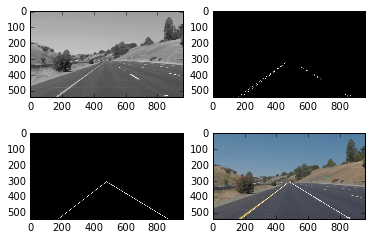

In [213]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [214]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


### Pipeline Description

#### Pipeline Steps:
1. Read in and grayscale the image
2. Define a kernel size and apply Gaussian smoothing
3. Define our parameters for Canny and apply to get edges image
4. Mask edges image using cv2.fillPoly() (ignore everything outside region of interest)
5. Define Hough transform parameters and run Hough transform on masked edge-detected image
6. Draw line segments
7. Draw lines extrapolated from line segments
8. Combine line image with original image to see how accurate the line annotations are.

#### Focus on Step 7 (Drawing lines extrapolated from line segments)
The time I spent the most time on was Step 7, drawing lines extrapolated from line segments. This step required custom code in addition to the helper functions provided.
1. Divide the hough line segments into those with positive slopes (left lane line) and negative slopes (negative lane line). Take only those with length greater than 50 to remove noise.
    * For each Hough line segment (two points), if (1) the slope of the line is positive and (2) if the line segment length is greater than 50 pixels (length chosen by observation), add the slope and intercept to an array `positive_slope_intercept`. I also added the clause that if the array is empty, we should go through the Hough lines again and add at least one pair of points to the array `positive_slope_intercept`. 
    * Do the same for Hough line segments with negative slope.
    * Line segments with positive slope belong to the negative 
2. Fit a line to the points belonging to the left lane line and to the points belonging to the right lane line separately using `find_line_fit`. Get the intercept and coefficient of the fitted lines.
    * If there is only one slope and intercept, return those.
    * Remove noise: remove points with slope not within 1.5 standard deviations of the mean. (1.5 chosen arbitrarily) This may fail if there is only one datapoint (it failed on one frame of the yellow lane line video), which is why I added the clause above.
    * Take the estimate of the slope and intercept to be that of the remaining values.
3. Calculate where the lane lines intersect.
4. Draw the lines from the intersection point to the bottom of the image.


### Shortcomings

* There are a few instances in the yellow lane line video and at least one instance in the white lane line video where the lane lines are marked incorrectly. The error is always (to my knowledge) in the lane line that is not solid.
* Image dimensions were hard-coded in at least one case.
* If the lane lines are not straight lines but have high curvature, this algorithm may give weird results.

### Possible Improvements

* Tune Hough transform parameters more systematically with more test images instead of by 'feel'.
* Currently the lane lines are drawn in solid white. It would be nice if they were drawn in thicker, semi-transparent red (say).

Reflection describes the current pipeline, identifies its potential shortcomings and suggests possible improvements. There is no minimum length. Writing in English is preferred but you may use any language.



I have included some debugging plots below for fun.


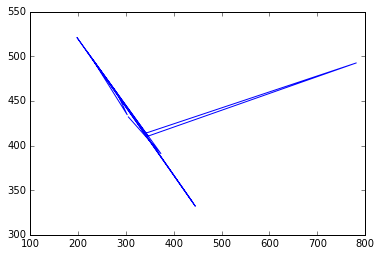

In [215]:
# Debugging plot 1: Plotting the midpoints of the Hough line segments
# for a test image to see why the final line plotted was wrong.
plt.plot([305.0, 373.0, 229.0, 302.5, 281.5, 197.5, 445.0, 339.5, 781.5, 346.0, 217.0, 439.5],
         [432.0, 391.0, 497.5, 434.5, 458.5, 521.0, 332.0, 413.5, 492.5, 410.5, 506.5, 336.5])
plt.show()

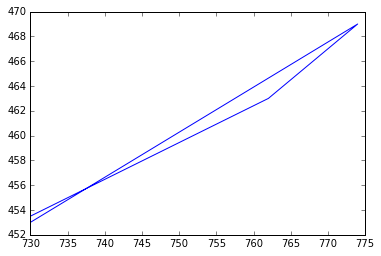

In [216]:
# Debugging plot 2: Plotting the midpoints of the Hough line segments
# for a test image to see why the final line plotted was wrong.
plt.plot([730.0, 762.0, 774.0, 730.0],[453.5, 463.0, 469.0, 453.0])
plt.show()

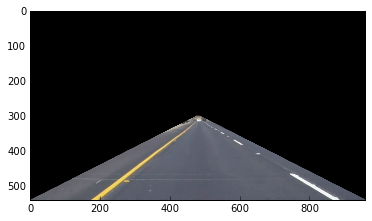

In [217]:
# Debugging mask
border = 80
imshape = [540, 960]
vertices = np.array([[(0,imshape[0]),(475, 300), (485, 300), 
                      (imshape[1],imshape[0])]], 
                    dtype=np.int32)    
plt.imshow(region_of_interest(test_images[5], vertices))

## Submission

If you're satisfied with your video outputs it's time to submit!


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

Slope:  0.453716855918 Intercept:  168.784139695
Slope:  -0.410234776306 Intercept:  686.998810598
Point one:  (599, 440) Point two:  (960, 604)
Point one:  (599, 440) Point two:  (0, 686)
(720, 1280, 3)
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4








  0%|          | 0/251 [00:00<?, ?it/s]





  0%|          | 1/251 [00:00<00:28,  8.89it/s]

Slope:  0.453716855918 Intercept:  168.784139695
Slope:  -0.410234776306 Intercept:  686.998810598
Point one:  (599, 440) Point two:  (960, 604)
Point one:  (599, 440) Point two:  (0, 686)
(720, 1280, 3)
Slope:  0.421073159801 Intercept:  190.087200078
Slope:  -0.484448732405 Intercept:  746.369524675
Point one:  (614, 448) Point two:  (960, 594)
Point one:  (614, 448) Point two:  (0, 746)








  1%|          | 2/251 [00:00<00:27,  8.97it/s]

(720, 1280, 3)








  1%|          | 3/251 [00:00<00:27,  9.05it/s]

Slope:  0.33310653518 Intercept:  234.264007214
Slope:  -0.421824596149 Intercept:  704.359067161
Point one:  (622, 441) Point two:  (960, 554)
Point one:  (622, 441) Point two:  (0, 704)
(720, 1280, 3)
Slope:  0.374703846321 Intercept:  194.435862984
Slope:  -0.398947202717 Intercept:  664.965782496
Point one:  (608, 422) Point two:  (960, 554)
Point one:  (608, 422) Point two:  (0, 664)








  2%|▏         | 4/251 [00:00<00:27,  9.00it/s]

(720, 1280, 3)








  2%|▏         | 5/251 [00:00<00:30,  7.95it/s]

Slope:  0.359557057366 Intercept:  212.214871418
Slope:  -0.303960054982 Intercept:  642.375485197
Point one:  (648, 445) Point two:  (960, 557)
Point one:  (648, 445) Point two:  (0, 642)
(720, 1280, 3)


Slope:  0.360172244845 Intercept:  224.7229965
Slope:  -0.37028629069 Intercept:  687.020519939
Point one:  (632, 452) Point two:  (960, 570)
Point one:  (632, 452) Point two:  (0, 687)








  2%|▏         | 6/251 [00:00<00:35,  6.88it/s]

(720, 1280, 3)
Slope:  0.591447080472 Intercept:  125.982474039
Slope:  -0.595783332274 Intercept:  773.679966752
Point one:  (545, 448) Point two:  (960, 693)
Point one:  (545, 448) Point two:  (0, 773)








  3%|▎         | 7/251 [00:00<00:37,  6.51it/s]

(720, 1280, 3)








  3%|▎         | 8/251 [00:01<00:35,  6.93it/s]

Slope:  0.471757225291 Intercept:  124.461519639
Slope:  -0.35890458093 Intercept:  653.439300985
Point one:  (636, 424) Point two:  (960, 577)
Point one:  (636, 424) Point two:  (0, 653)
(720, 1280, 3)
Slope:  0.437748678524 Intercept:  163.4498392
Slope:  -0.461694430284 Intercept:  728.858045675
Point one:  (628, 438) Point two:  (960, 583)
Point one:  (628, 438) Point two:  (0, 728)








  4%|▎         | 9/251 [00:01<00:32,  7.49it/s]

(720, 1280, 3)








  4%|▍         | 10/251 [00:01<00:30,  7.99it/s]

Slope:  0.454826893156 Intercept:  136.248001141
Slope:  -0.575578164709 Intercept:  761.010204346
Point one:  (606, 412) Point two:  (960, 572)
Point one:  (606, 412) Point two:  (0, 761)
(720, 1280, 3)
Slope:  0.373312200969 Intercept:  201.547441484
Slope:  -1.11996557768 Intercept:  1003.10120253
Point one:  (536, 401) Point two:  (960, 559)
Point one:  (536, 401) Point two:  (0, 1003)








  4%|▍         | 11/251 [00:01<00:28,  8.40it/s]

(720, 1280, 3)








  5%|▍         | 12/251 [00:01<00:28,  8.53it/s]

Slope:  0.397722771991 Intercept:  184.323169416
Slope:  -0.376511534887 Intercept:  668.296236884
Point one:  (625, 432) Point two:  (960, 566)
Point one:  (625, 432) Point two:  (0, 668)
(720, 1280, 3)
Slope:  0.423287102012 Intercept:  172.913018915
Slope:  -0.491355426604 Intercept:  730.66636842
Point one:  (609, 431) Point two:  (960, 579)
Point one:  (609, 431) Point two:  (0, 730)








  5%|▌         | 13/251 [00:01<00:30,  7.92it/s]





  6%|▌         | 14/251 [00:01<00:32,  7.40it/s]

(720, 1280, 3)
Slope:  0.391811980279 Intercept:  185.868354011
Slope:  -0.613103231029 Intercept:  763.641429574
Point one:  (574, 411) Point two:  (960, 562)
Point one:  (574, 411) Point two:  (0, 763)
(720, 1280, 3)








  6%|▌         | 15/251 [00:01<00:30,  7.76it/s]





  6%|▋         | 16/251 [00:02<00:28,  8.23it/s]

Slope:  0.420258977117 Intercept:  224.319380651
Slope:  -0.456788096948 Intercept:  725.494439034
Point one:  (571, 464) Point two:  (960, 627)
Point one:  (571, 464) Point two:  (0, 725)
(720, 1280, 3)
Slope:  0.560949381077 Intercept:  127.133570412
Slope:  -0.299425906889 Intercept:  647.979633097
Point one:  (605, 466) Point two:  (960, 665)
Point one:  (605, 466) Point two:  (0, 647)
(720, 1280, 3)








  7%|▋         | 17/251 [00:02<00:27,  8.50it/s]





  7%|▋         | 18/251 [00:02<00:26,  8.80it/s]

Slope:  0.412849694662 Intercept:  170.624476176
Slope:  -0.777699636449 Intercept:  827.532739952
Point one:  (551, 398) Point two:  (960, 566)
Point one:  (551, 398) Point two:  (0, 827)
(720, 1280, 3)
Slope:  0.385313491625 Intercept:  218.441902645
Slope:  -0.506205362935 Intercept:  750.494406394
Point one:  (596, 448) Point two:  (960, 588)
Point one:  (596, 448) Point two:  (0, 750)
(720, 1280, 3)


Slope:  nan Intercept:  nan
Slope:  -0.515298951368 Intercept:  727.868153655


ValueError: cannot convert float NaN to integer

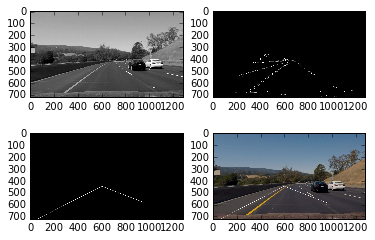

In [218]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## Misc